1 1


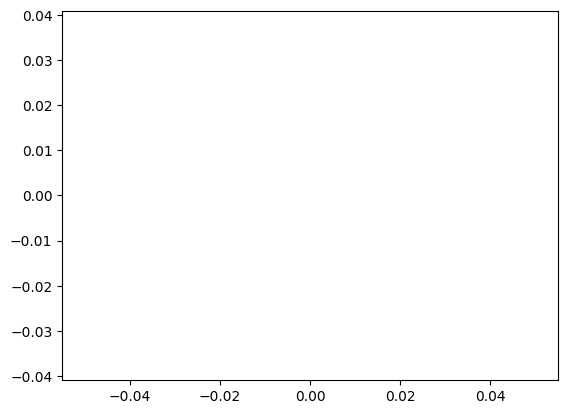

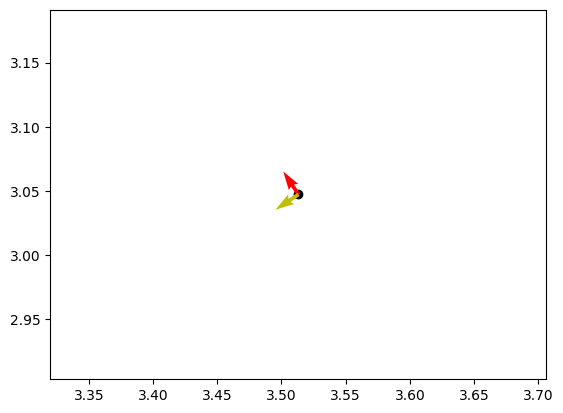

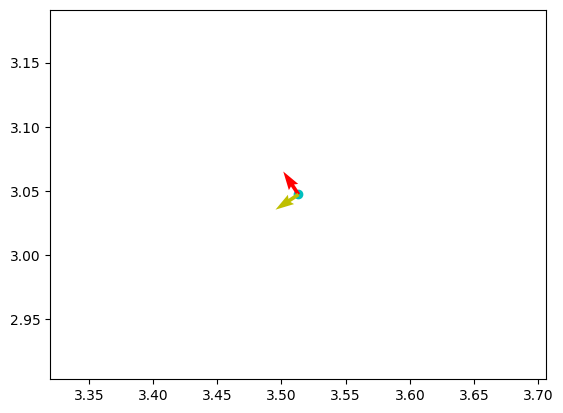

2 2


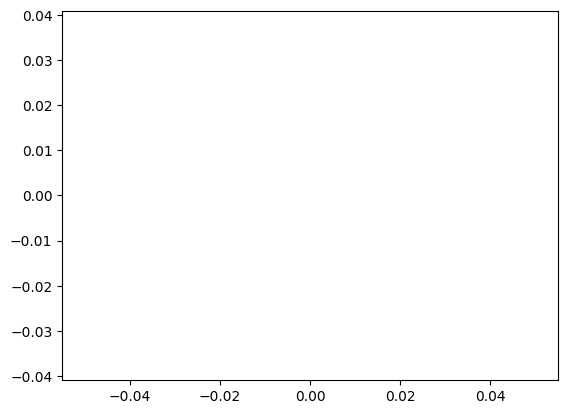

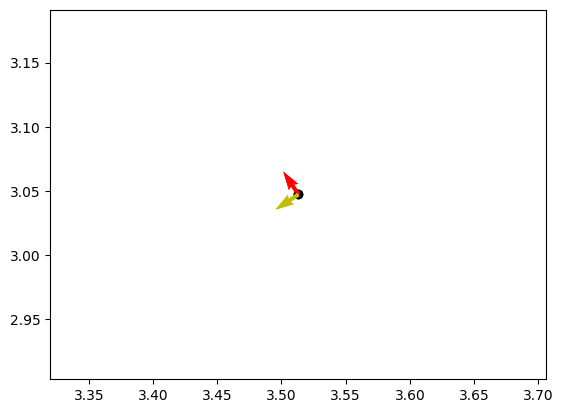

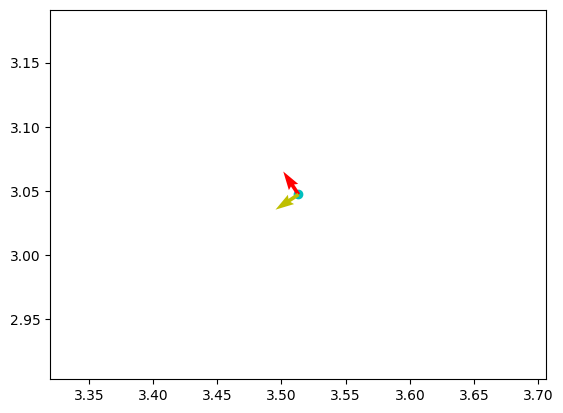

2 2


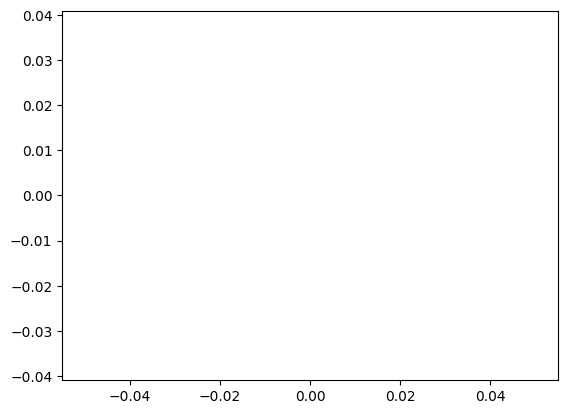

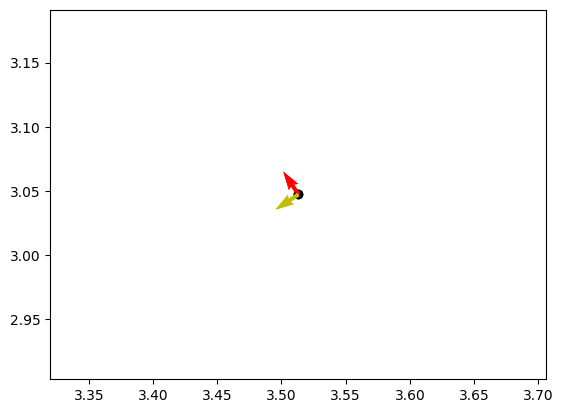

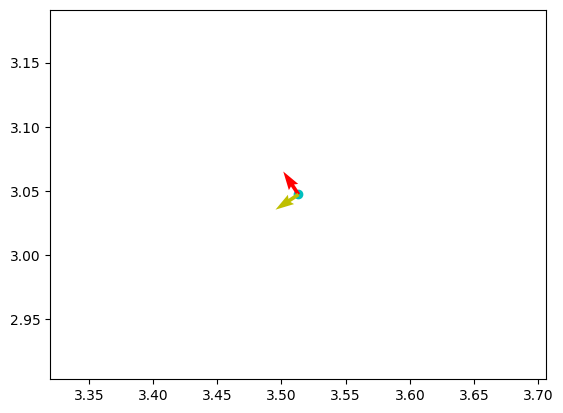

2 3


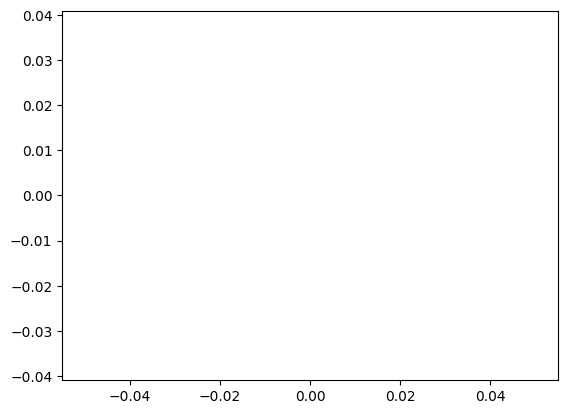

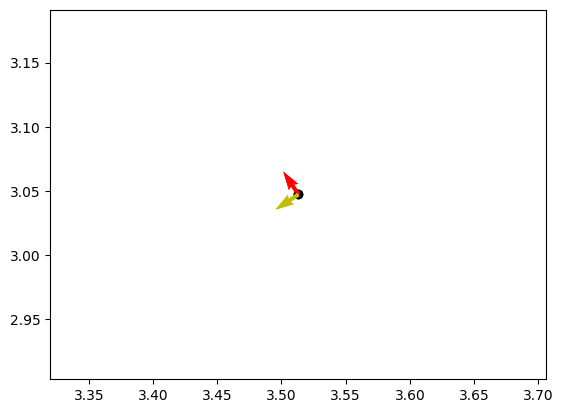

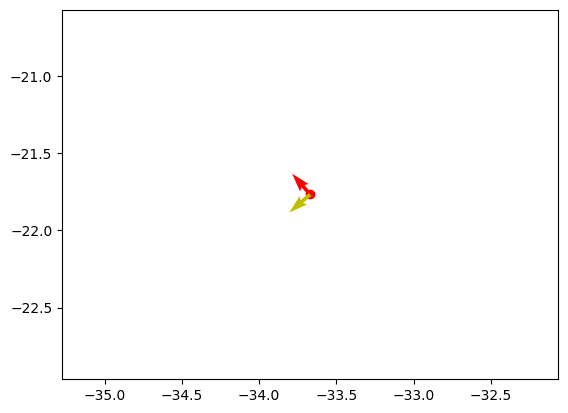

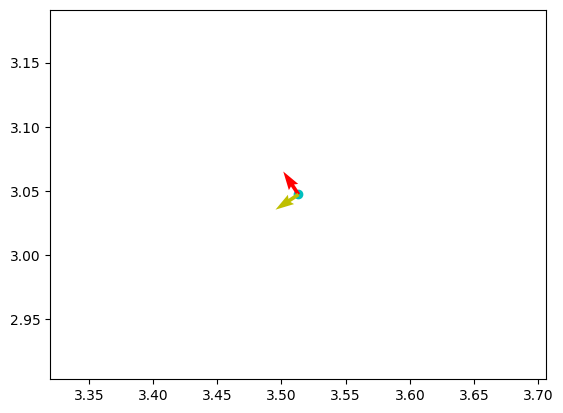

2 3


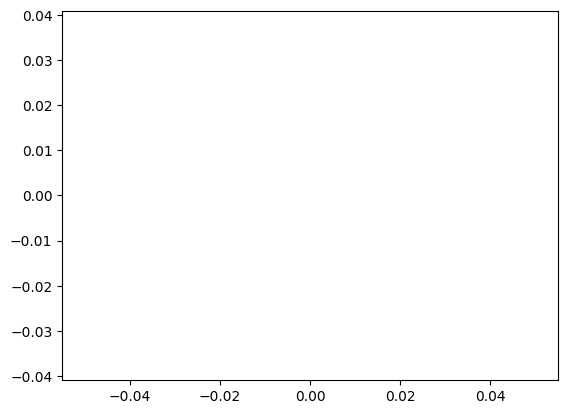

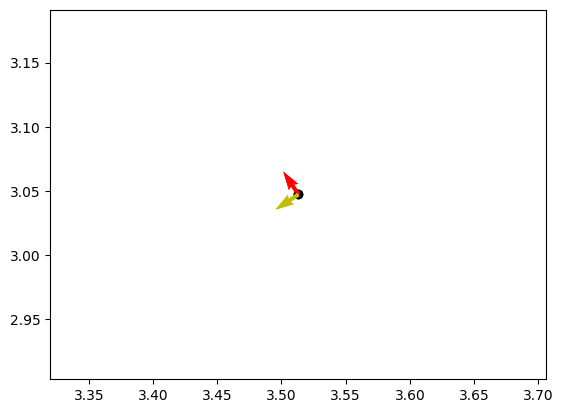

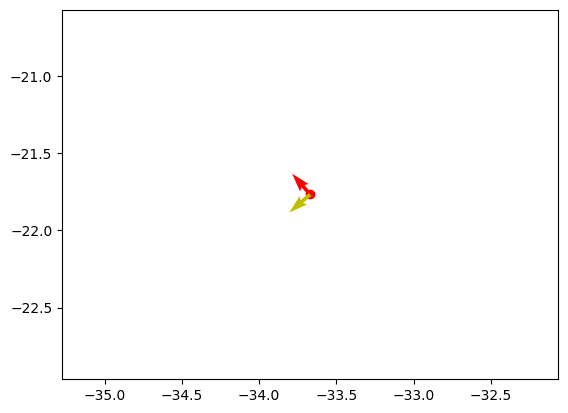

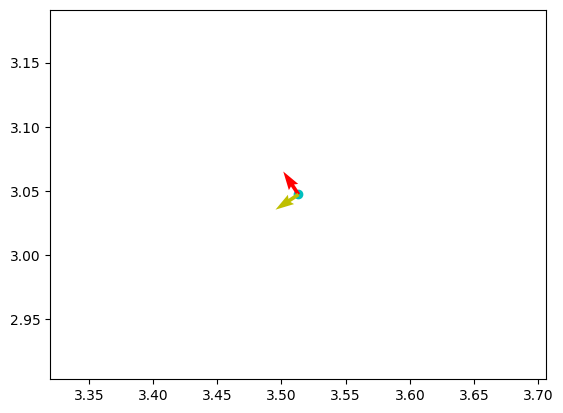

2 3


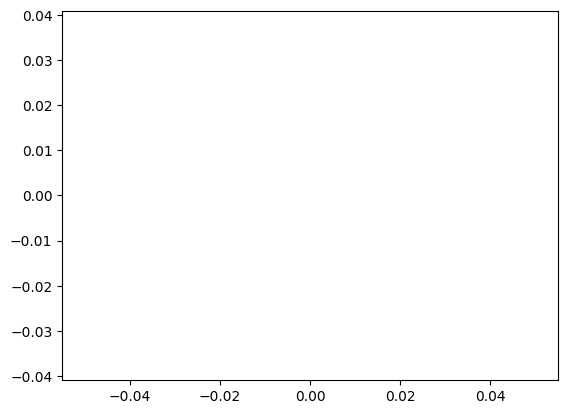

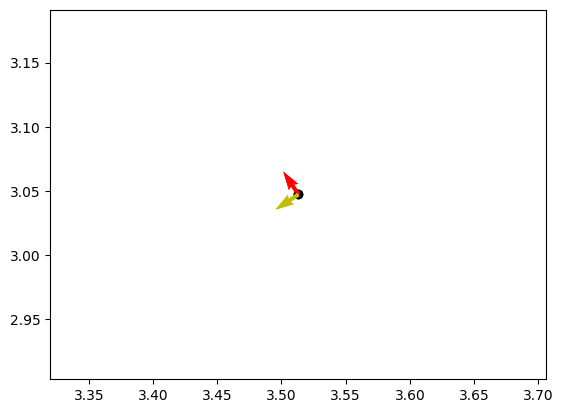

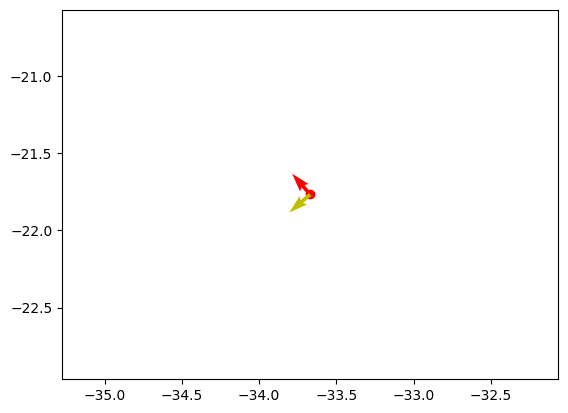

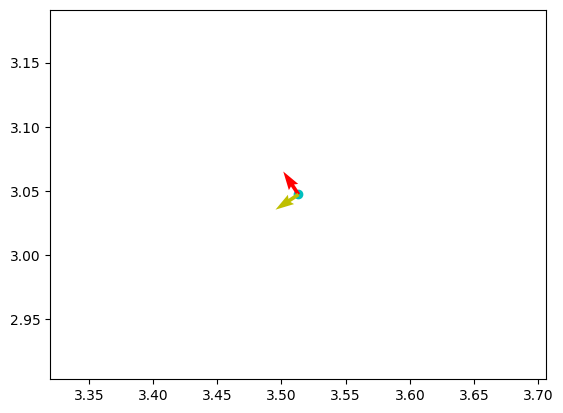

2 3


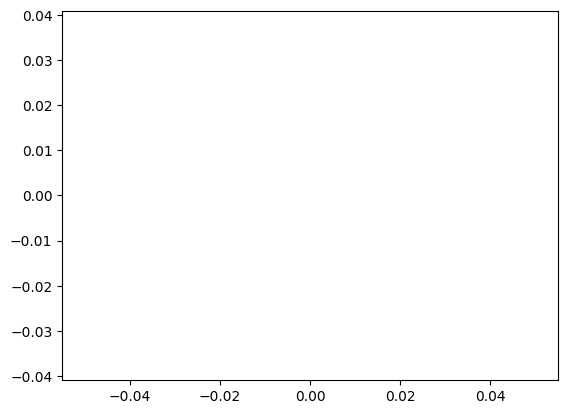

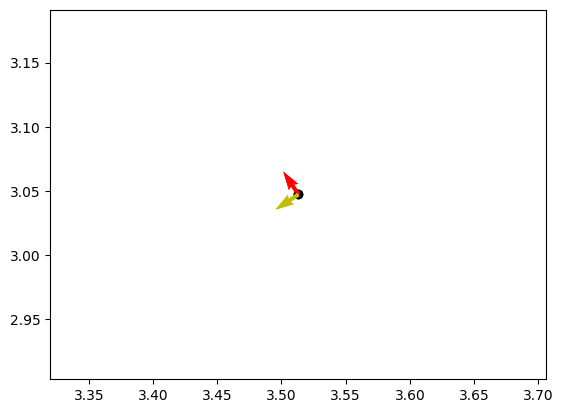

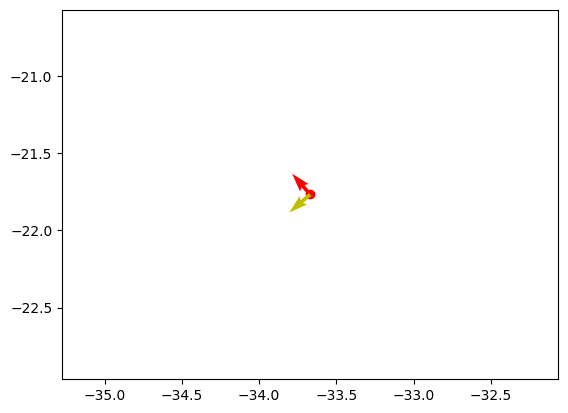

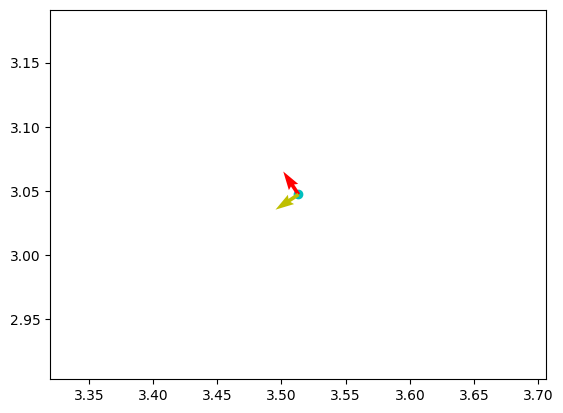

2 3


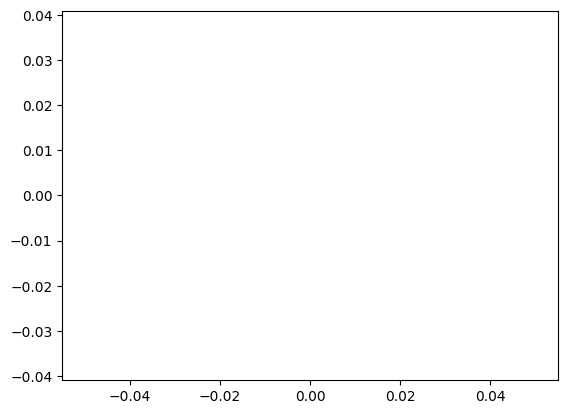

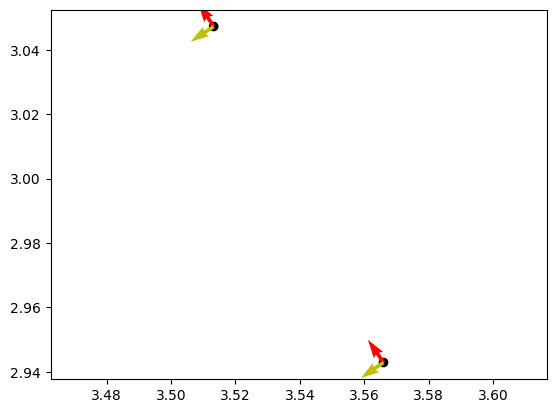

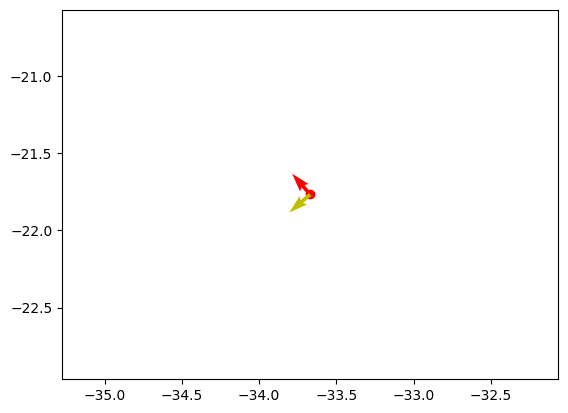

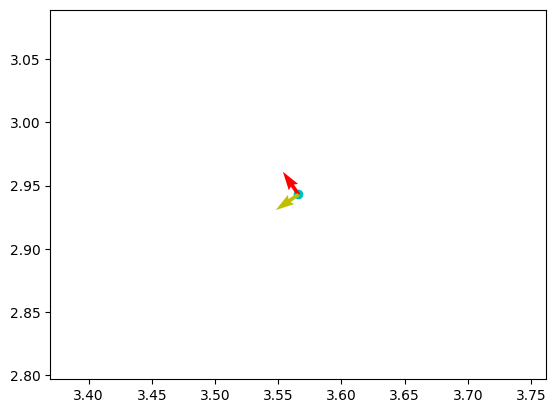

2 3


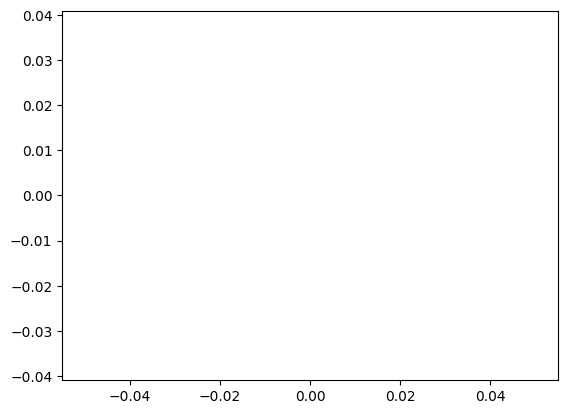

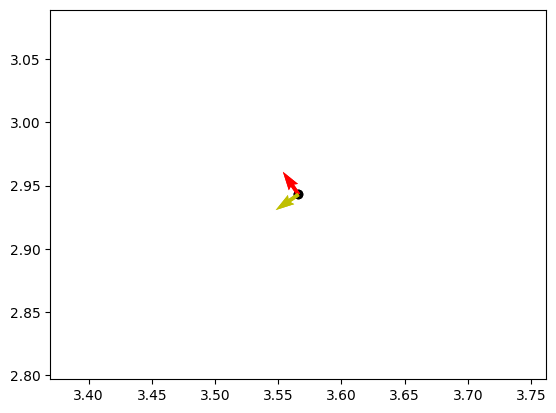

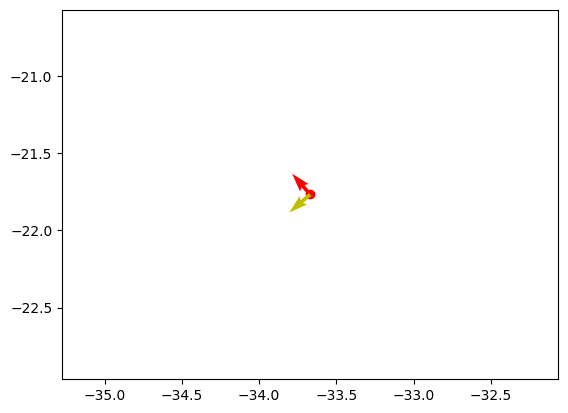

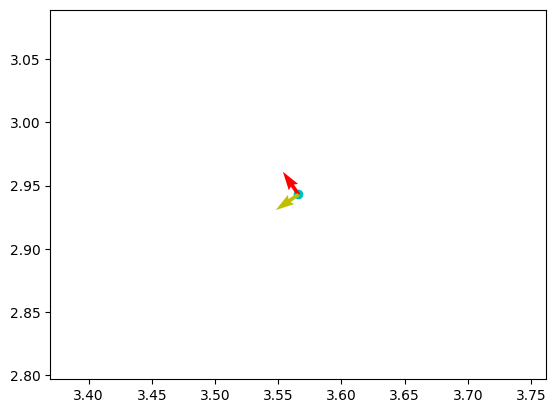

2 3


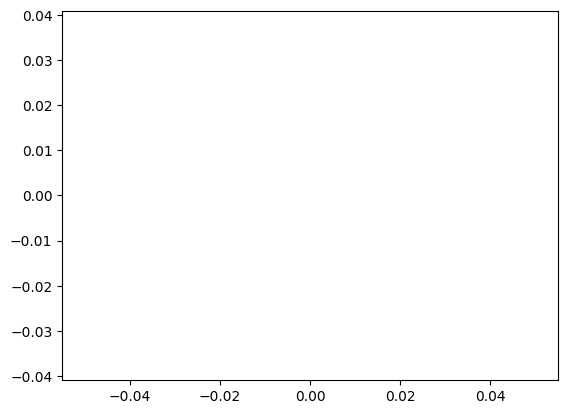

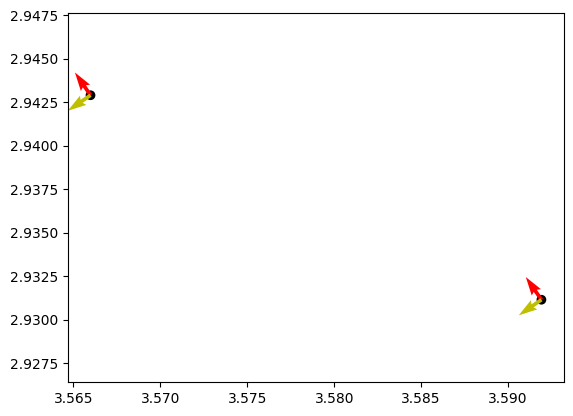

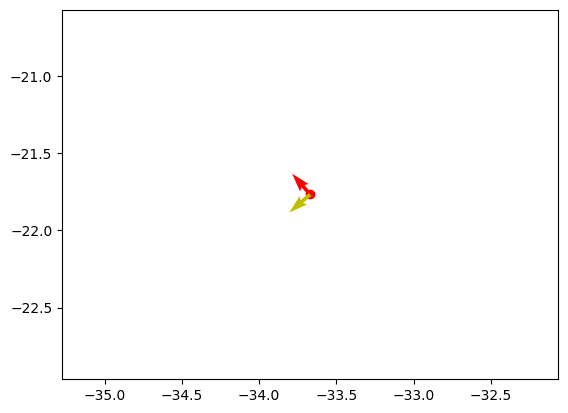

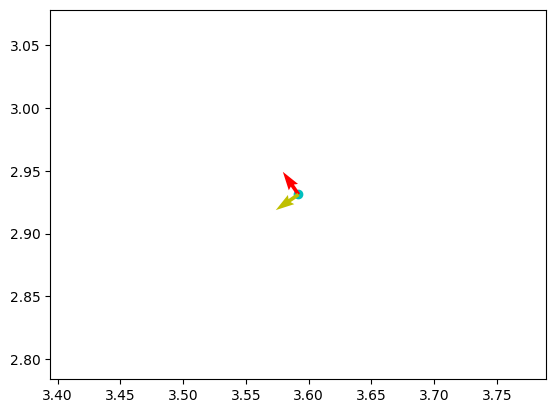

2 3


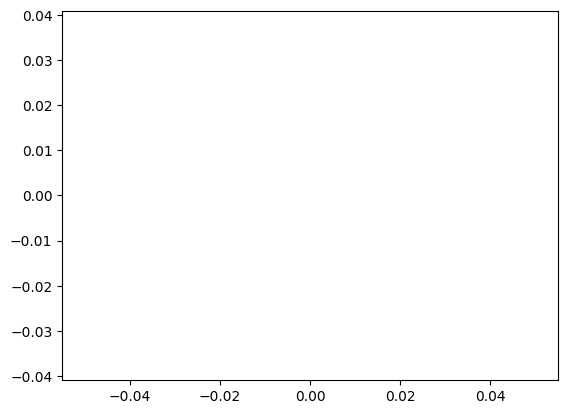

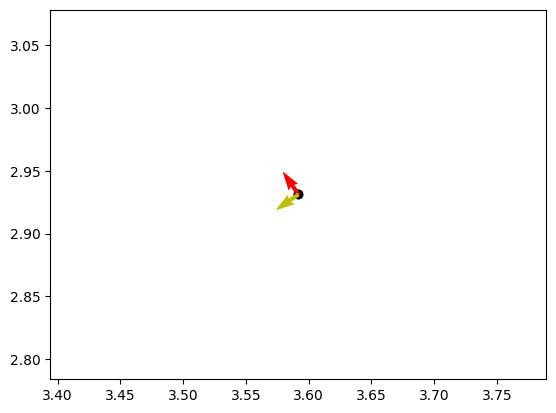

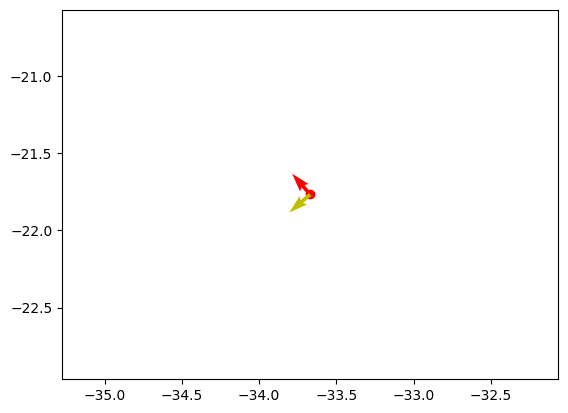

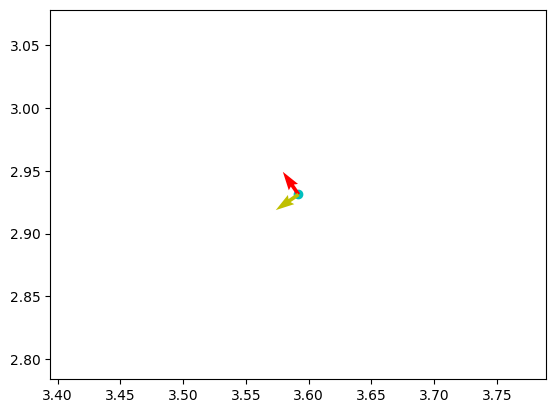

2 3


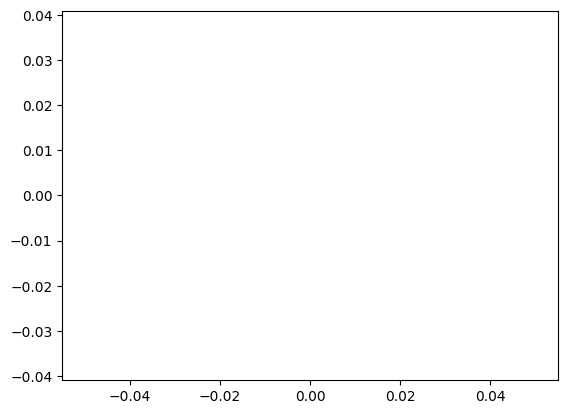

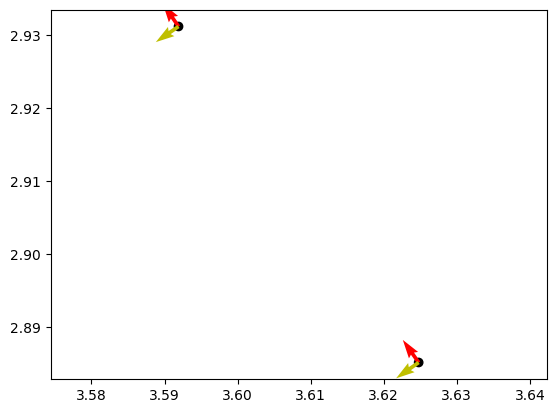

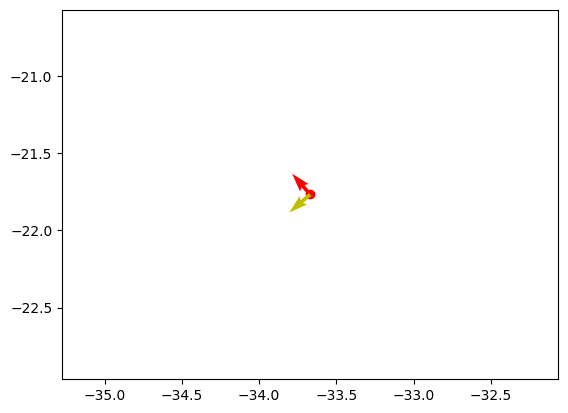

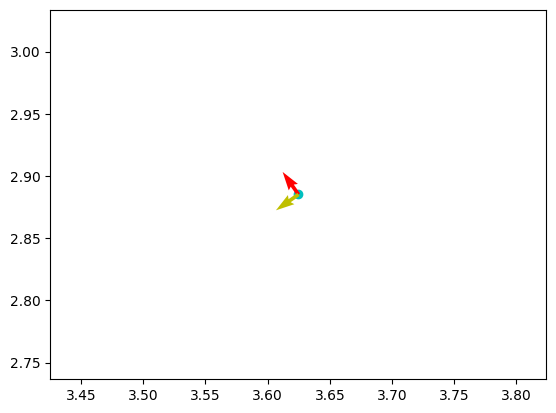

2 3


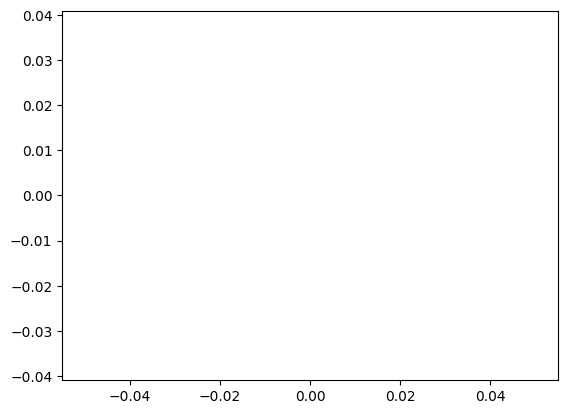

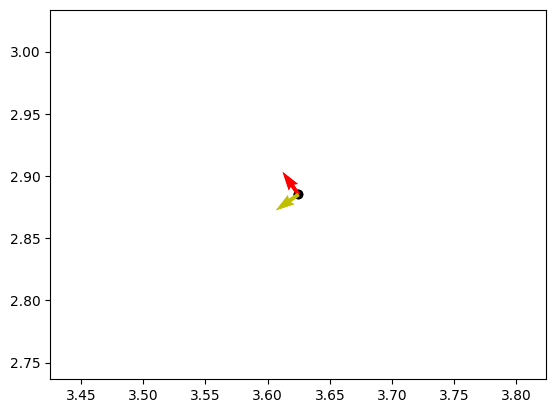

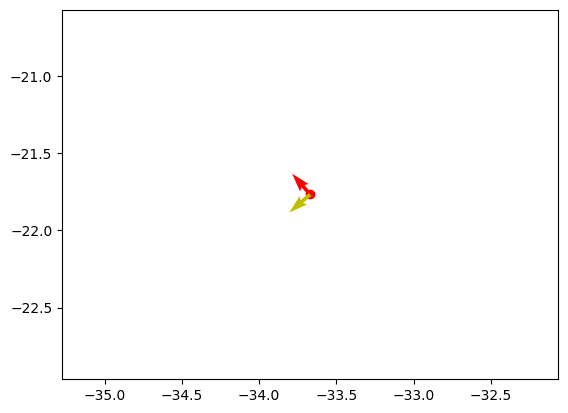

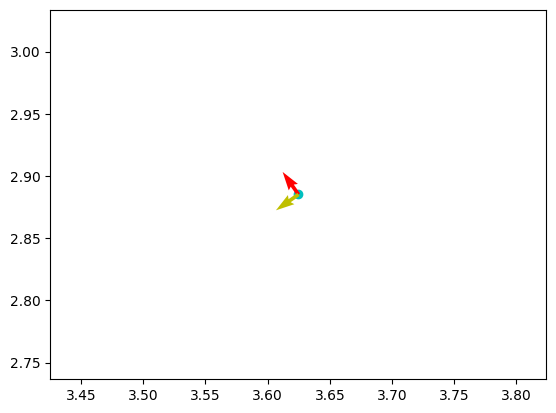

2 3


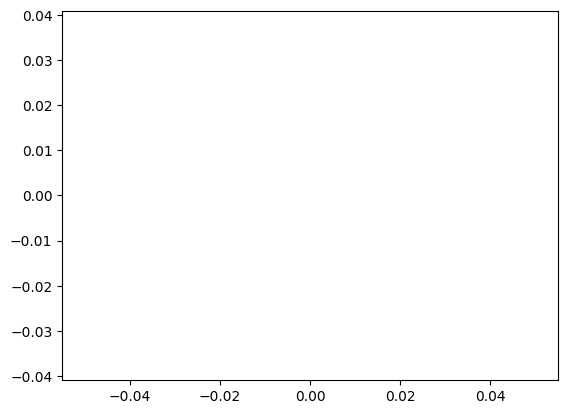

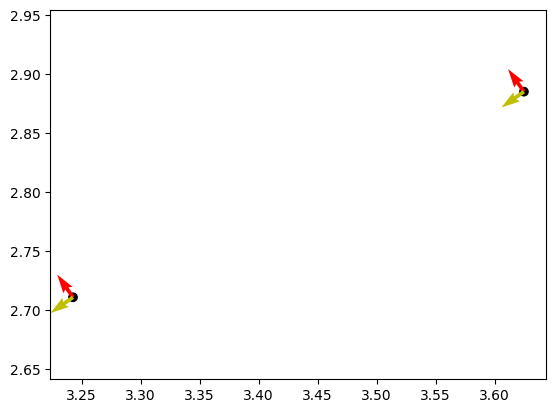

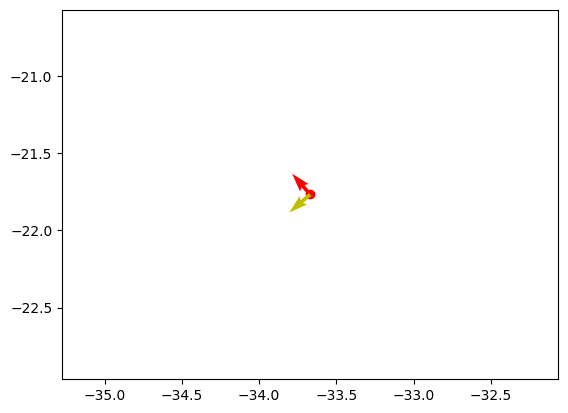

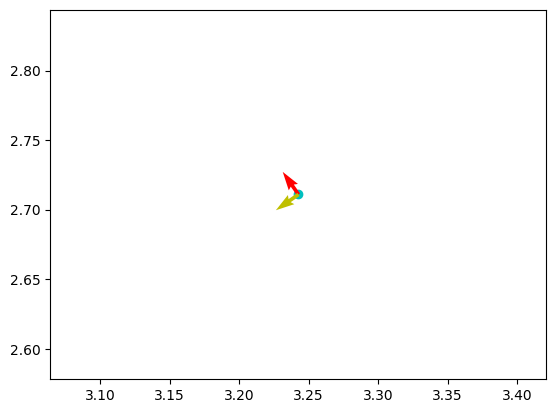

2 3


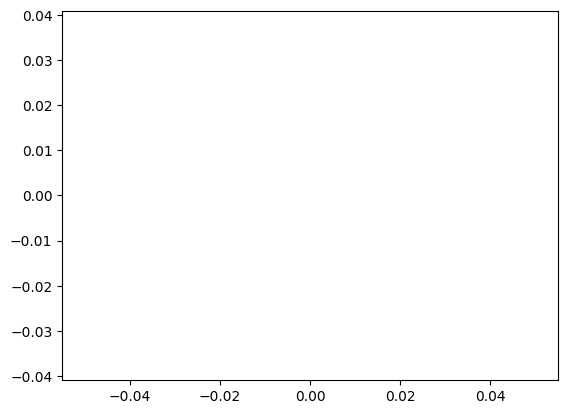

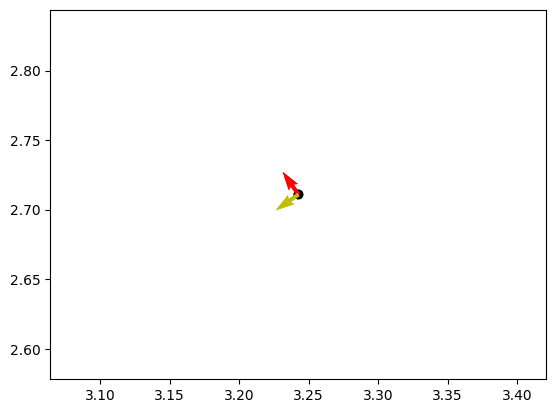

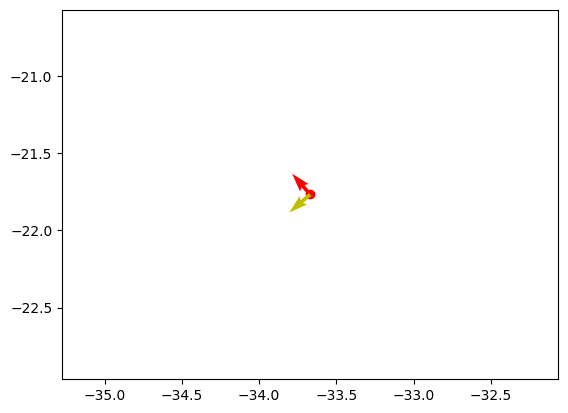

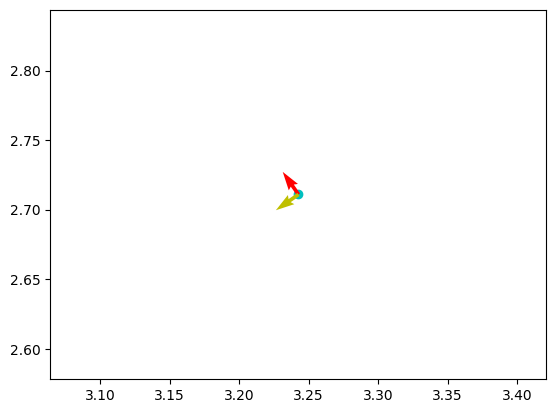

2 3


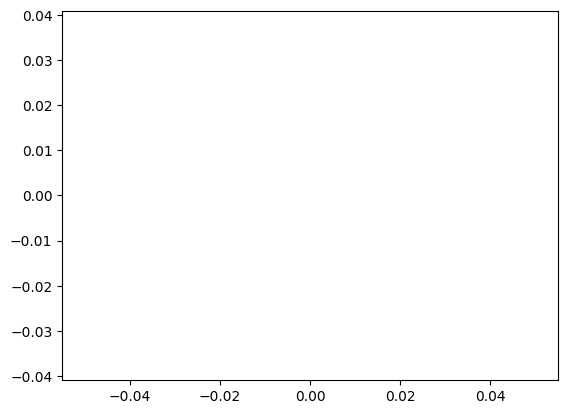

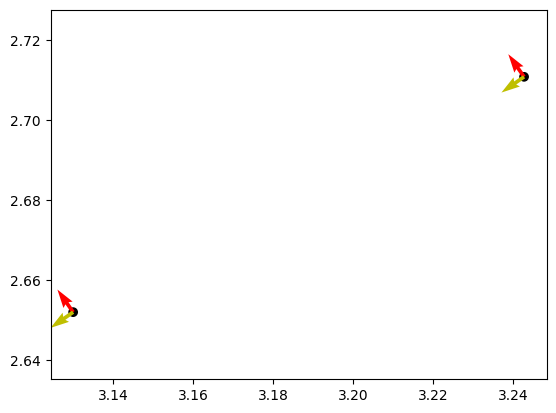

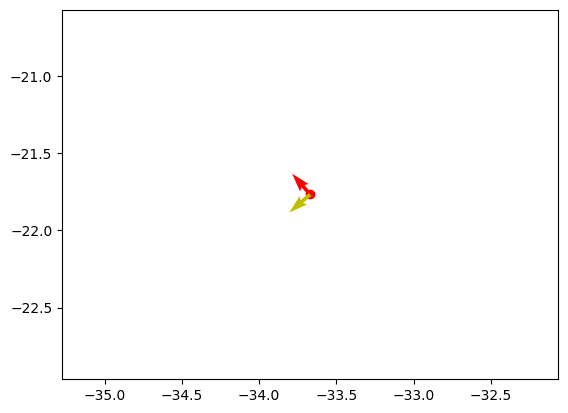

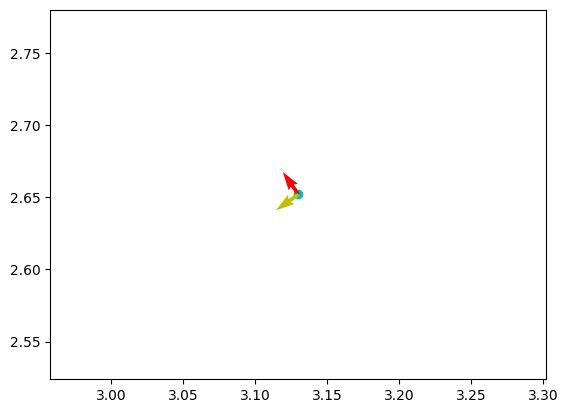

2 3


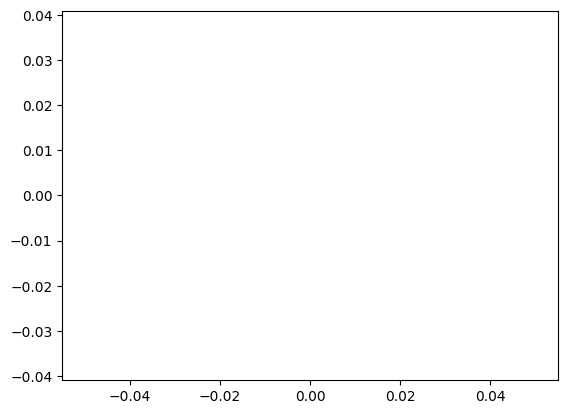

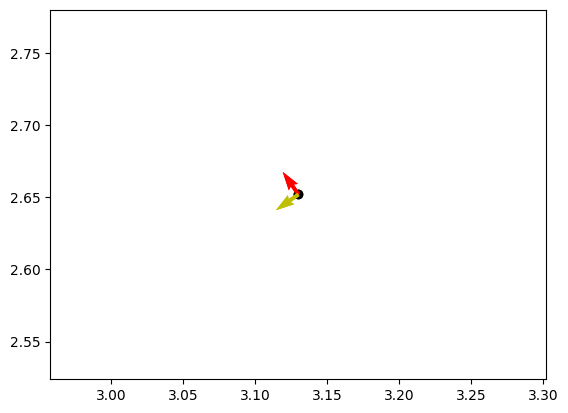

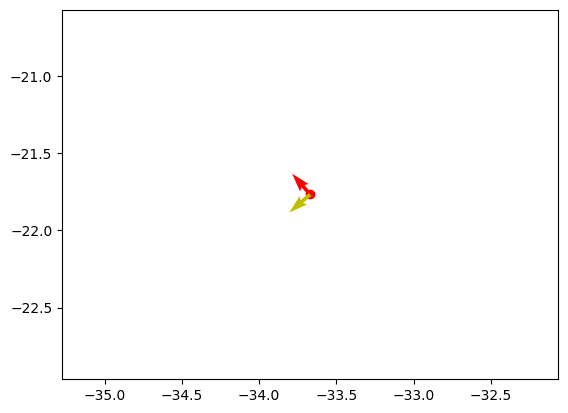

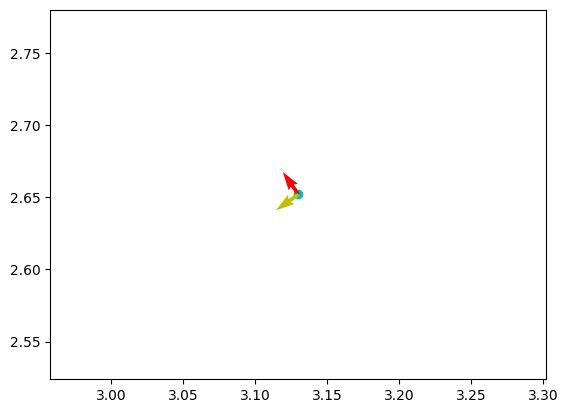

2 3


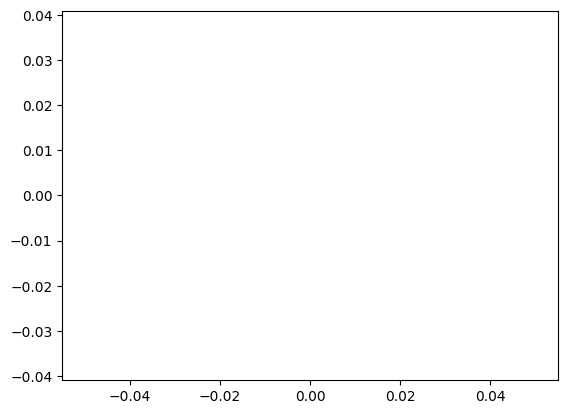

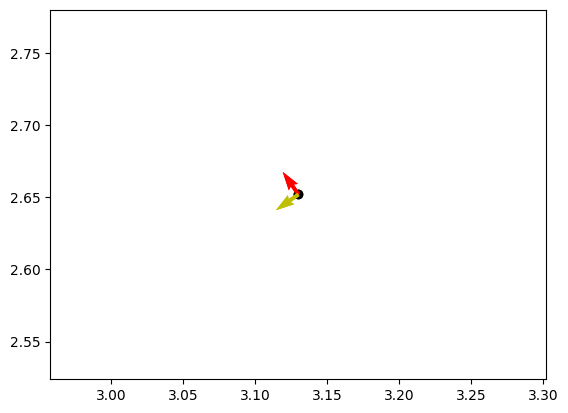

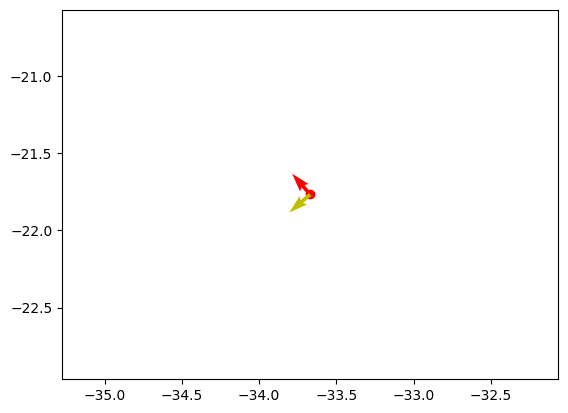

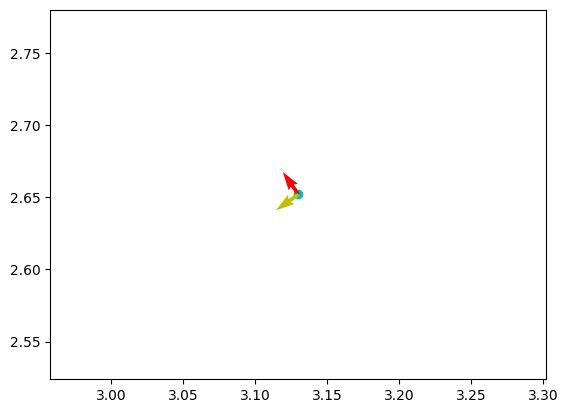

2 3


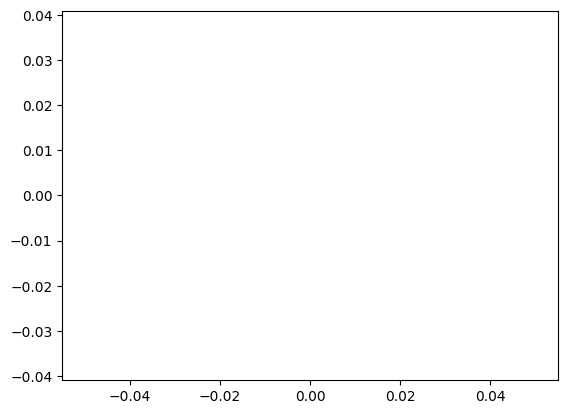

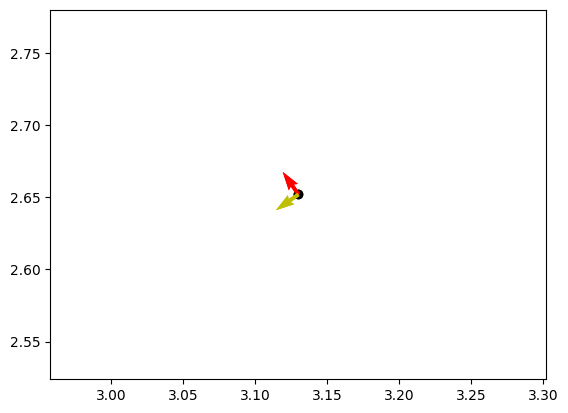

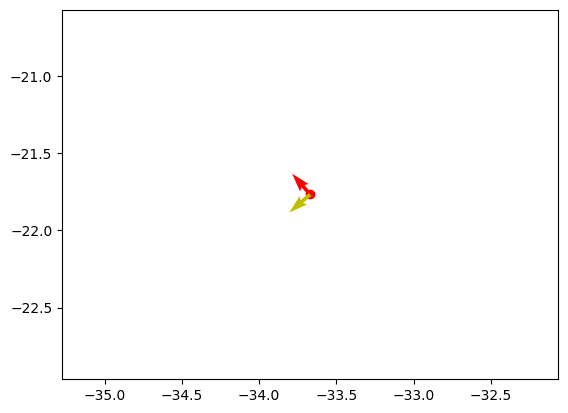

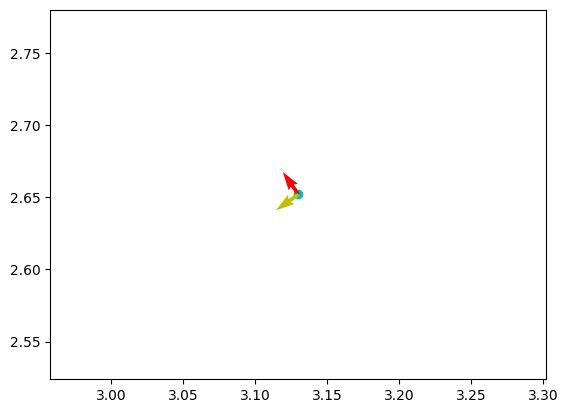

2 3


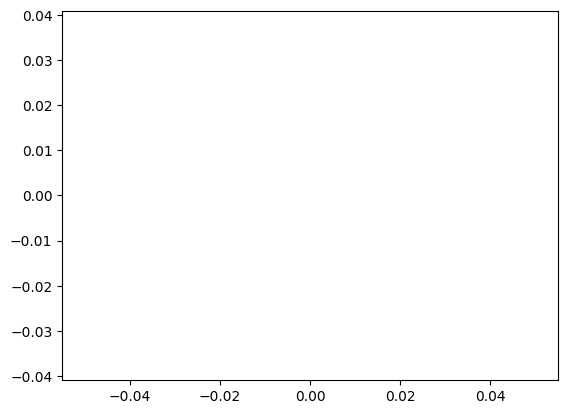

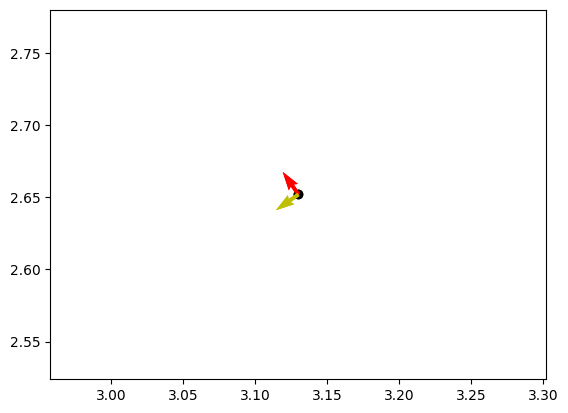

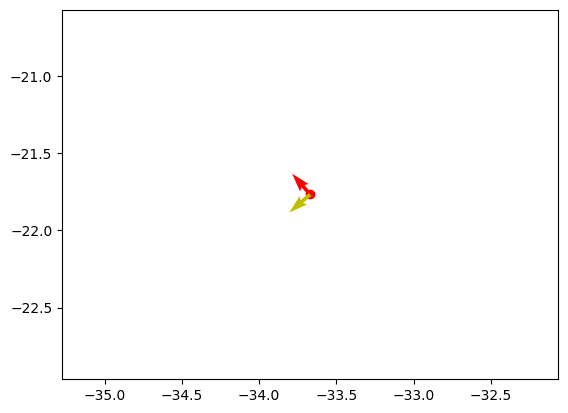

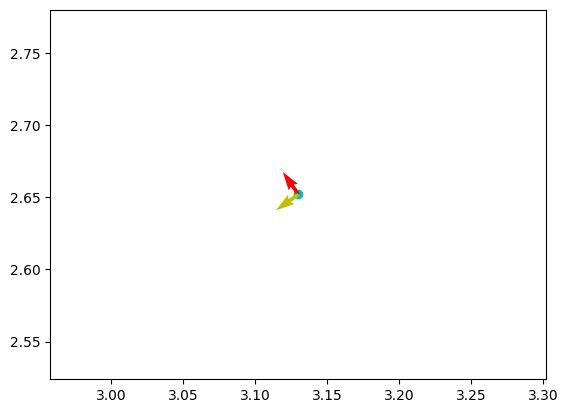

2 3


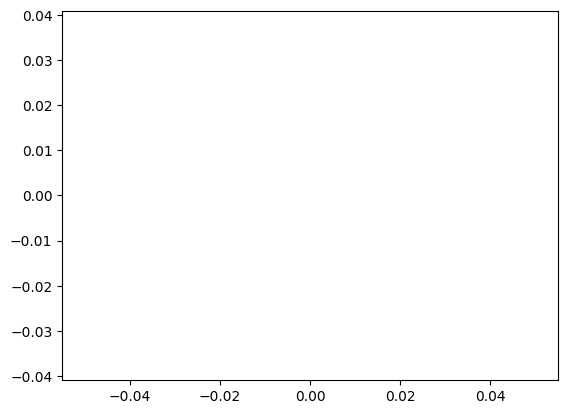

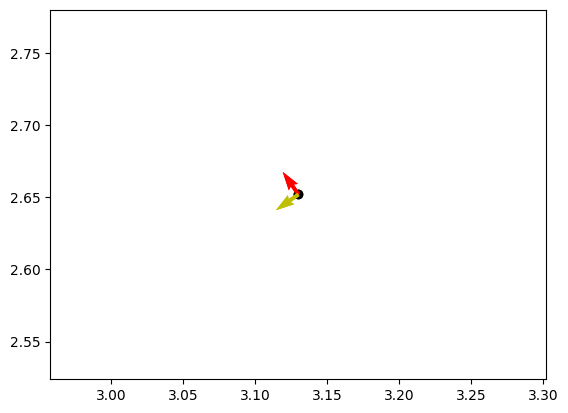

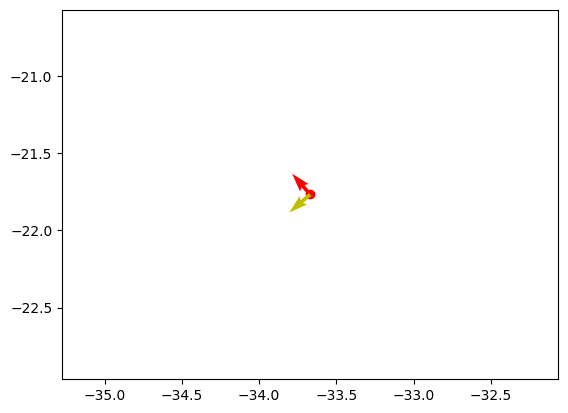

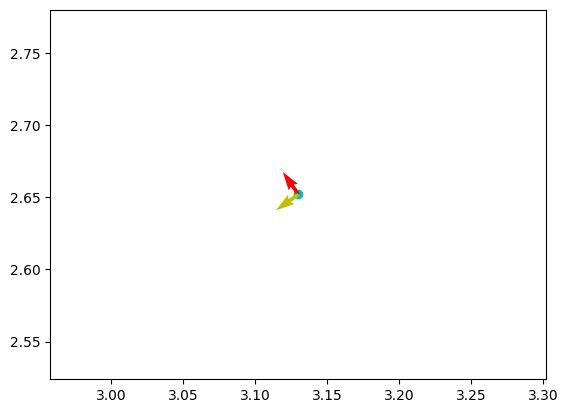

2 3


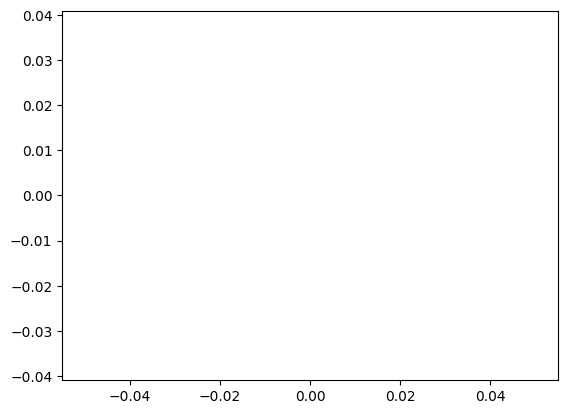

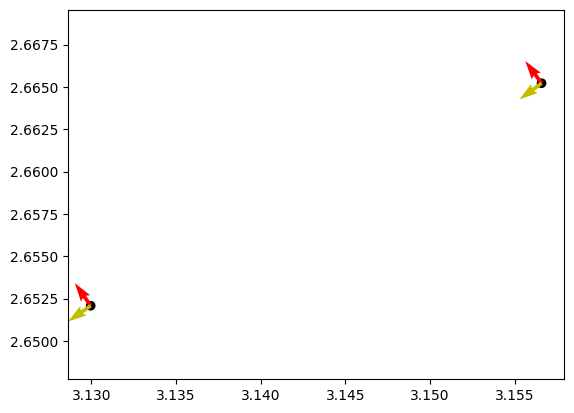

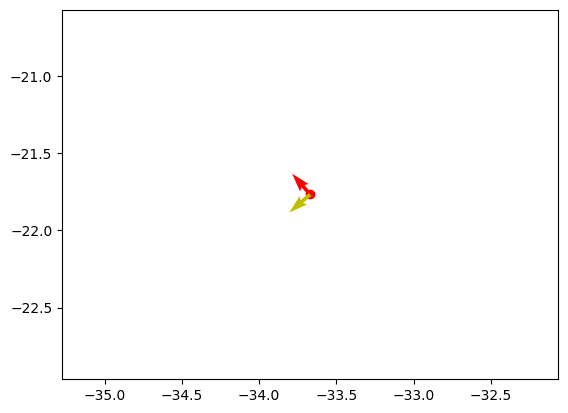

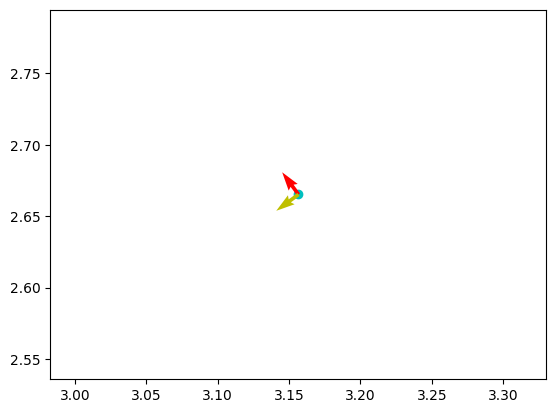

2 3


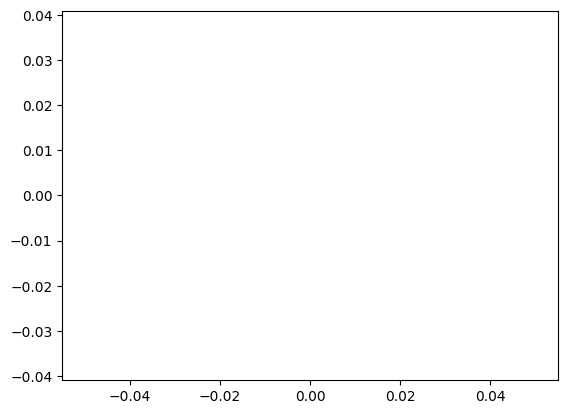

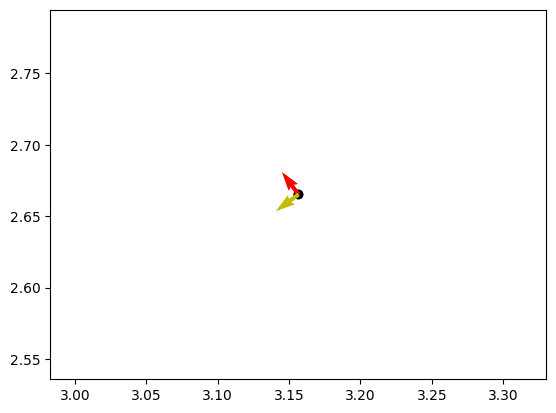

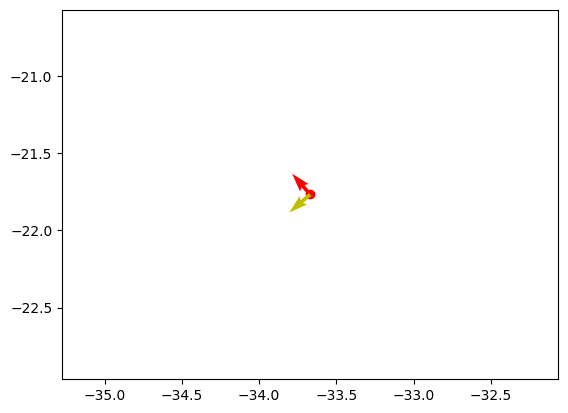

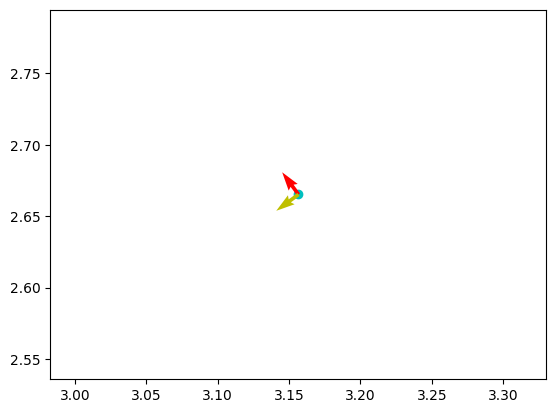

2 3


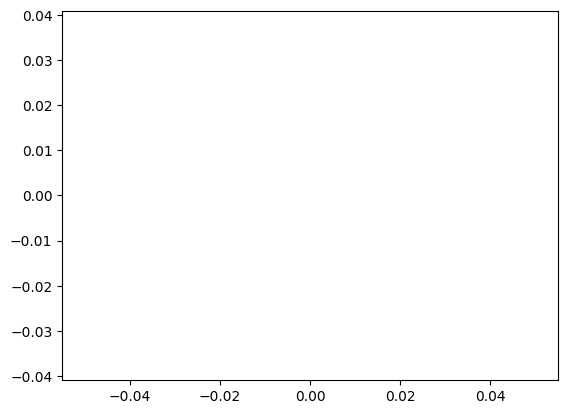

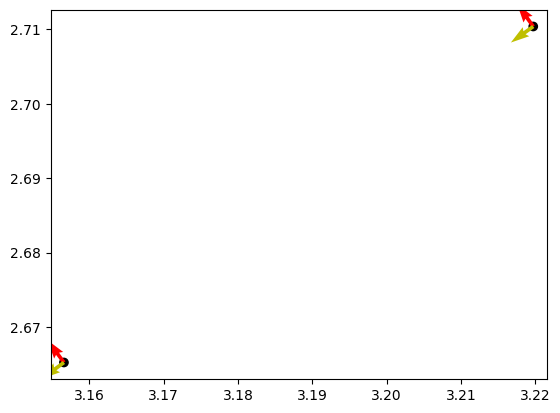

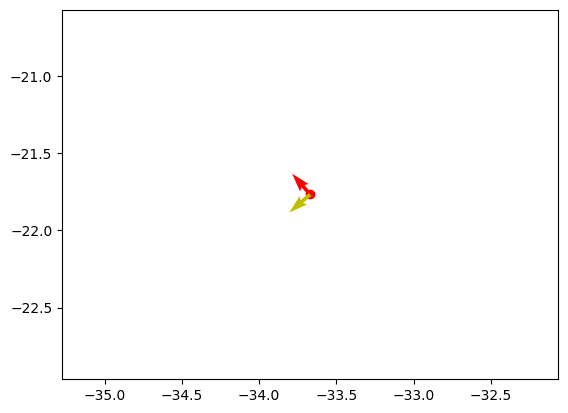

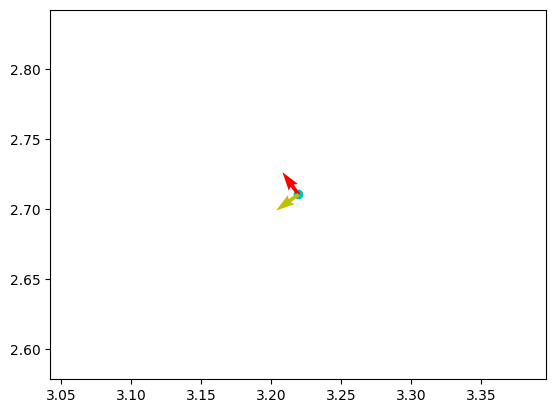

2 3


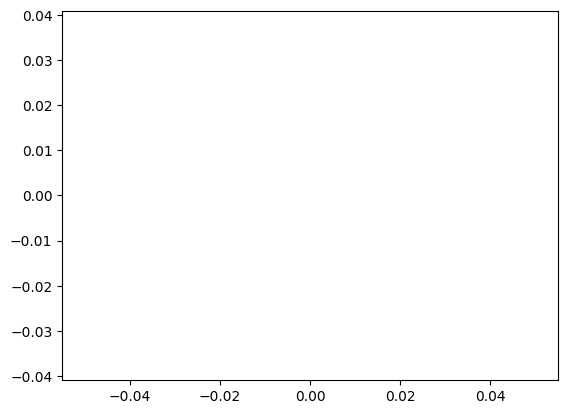

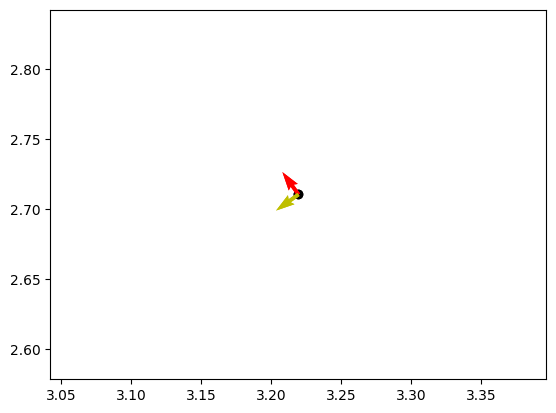

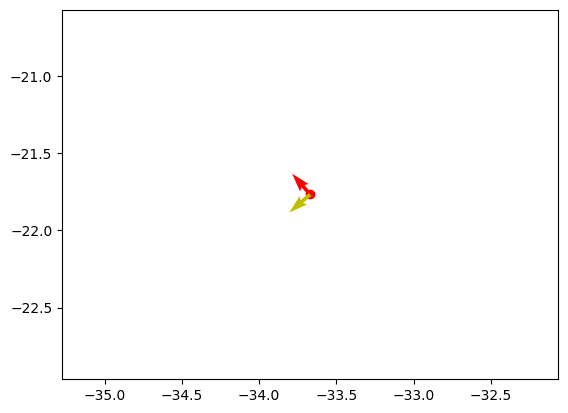

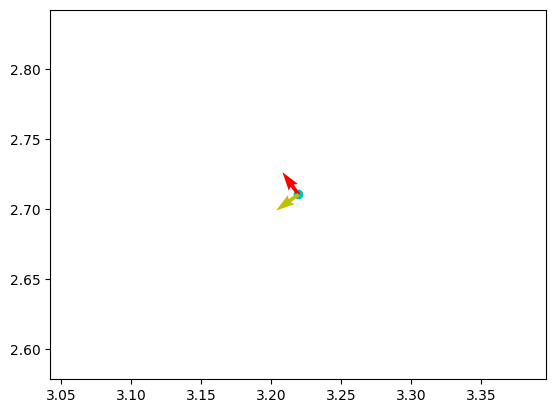

2 3


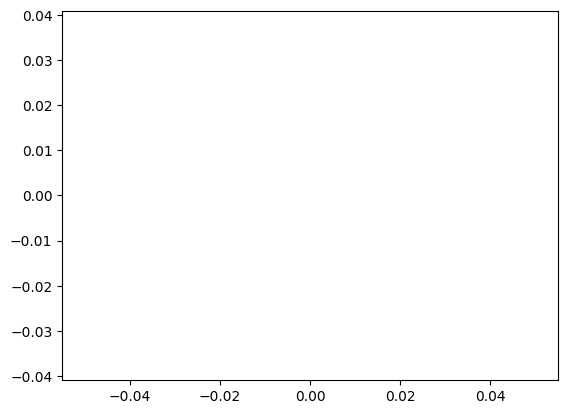

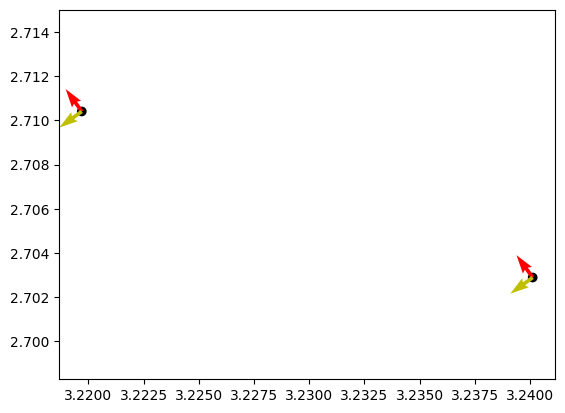

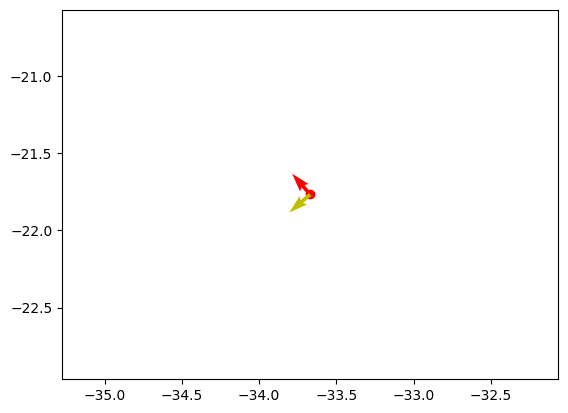

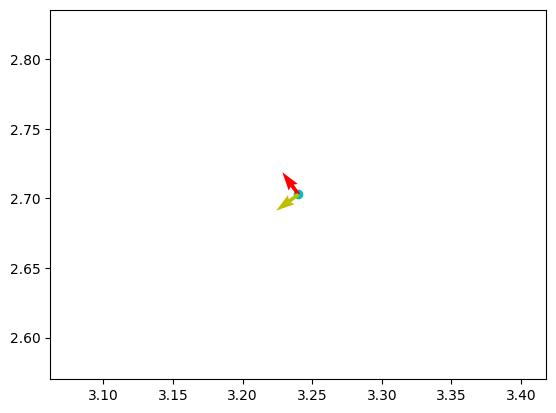

2 3


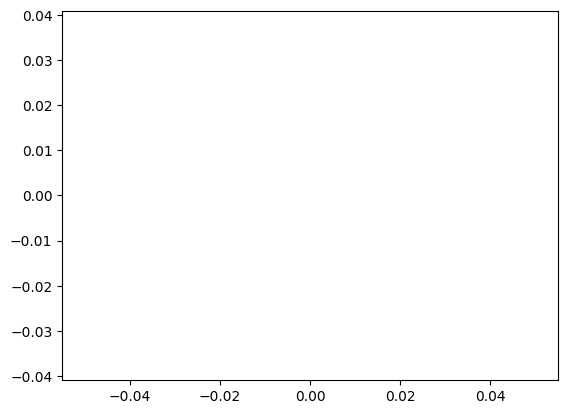

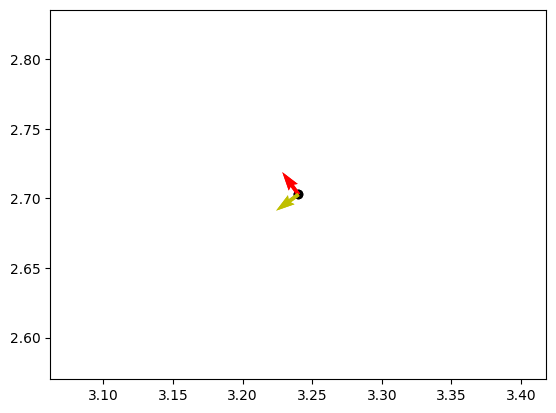

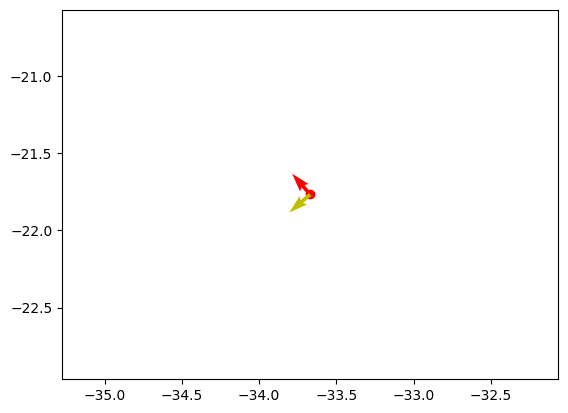

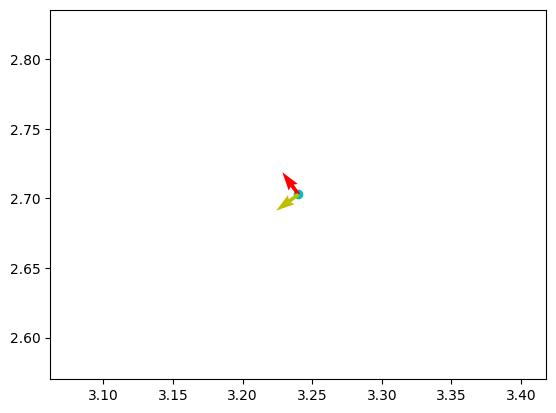

3 4


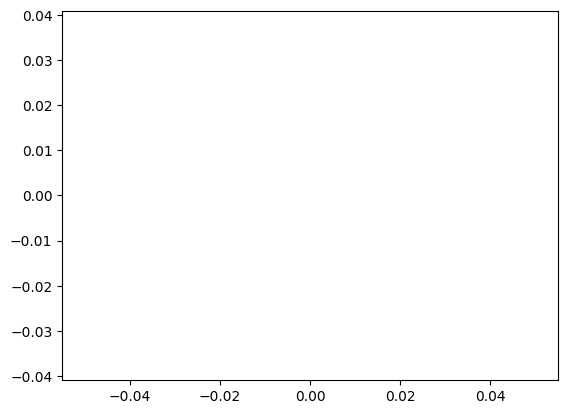

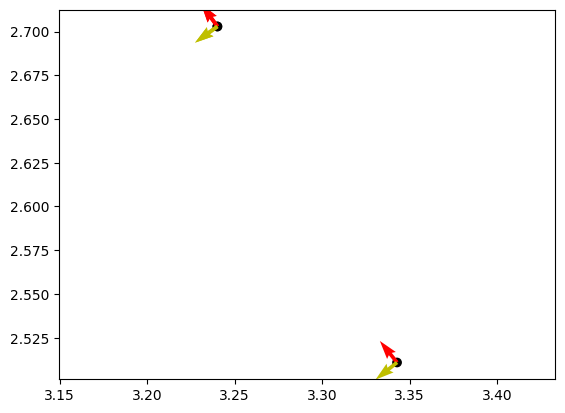

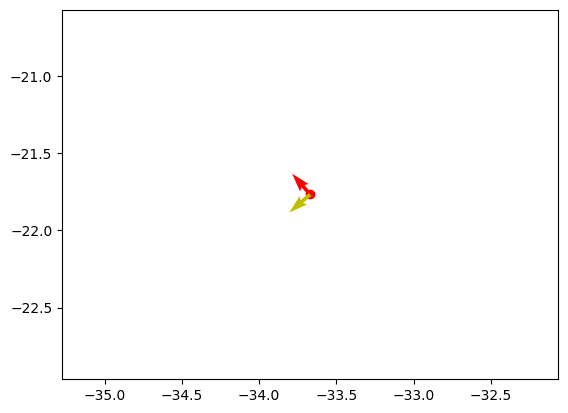

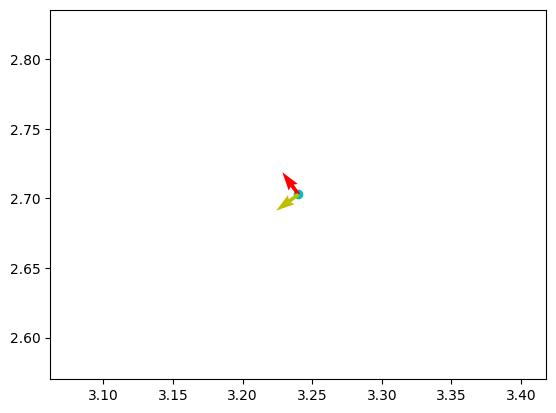

3 4


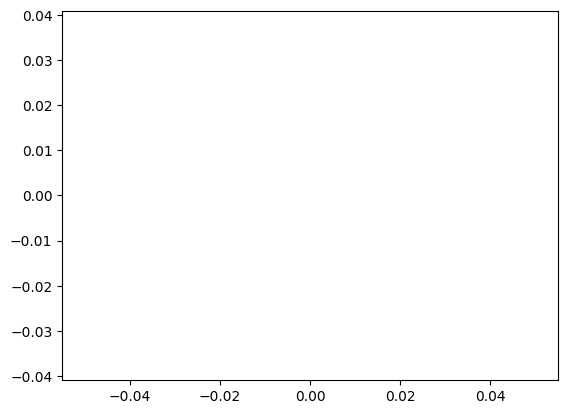

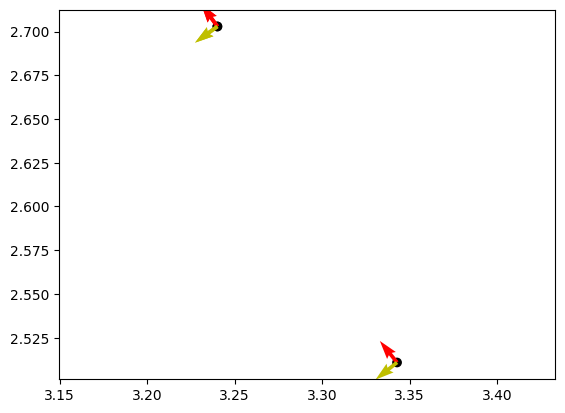

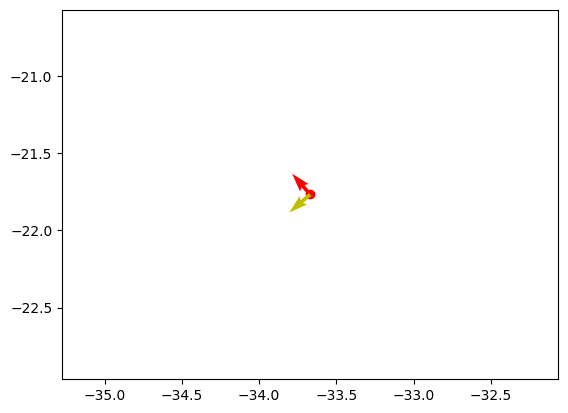

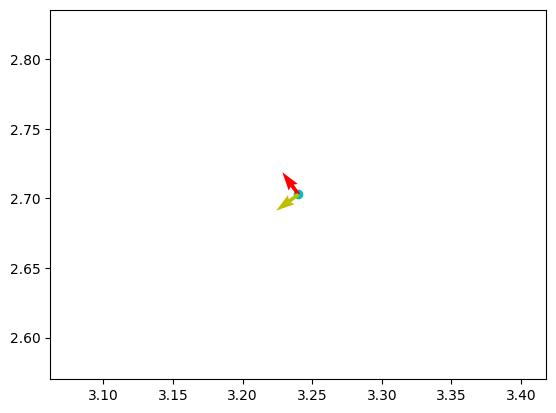

3 4


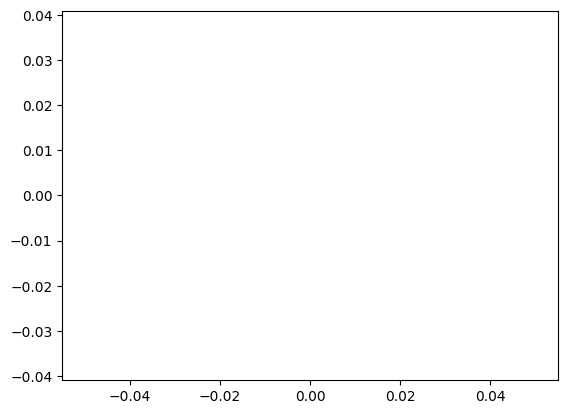

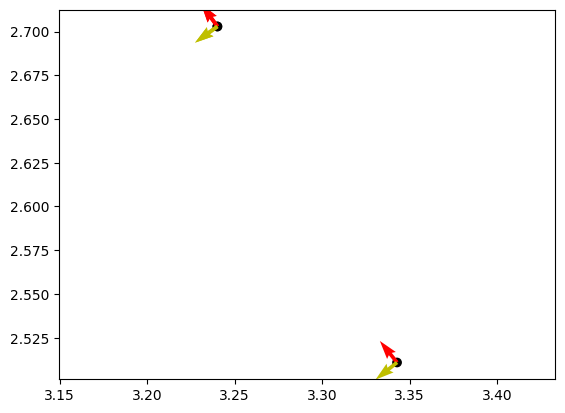

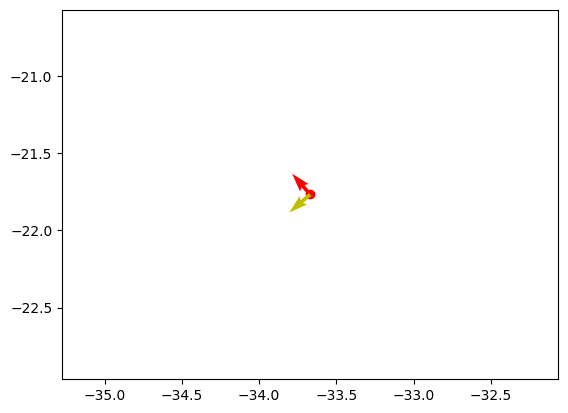

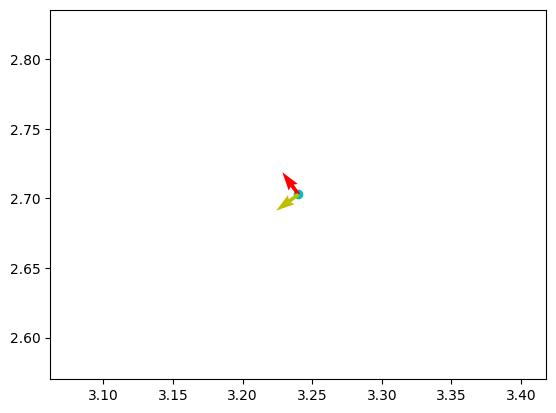

3 4


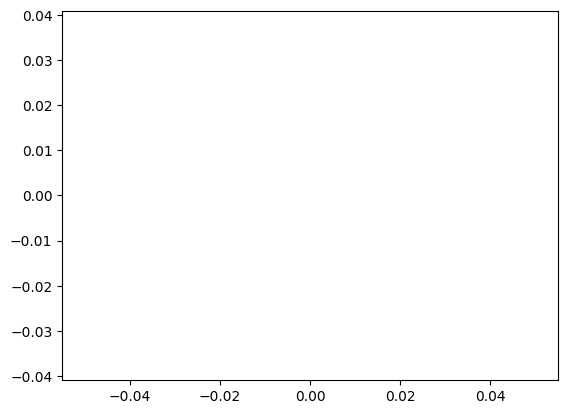

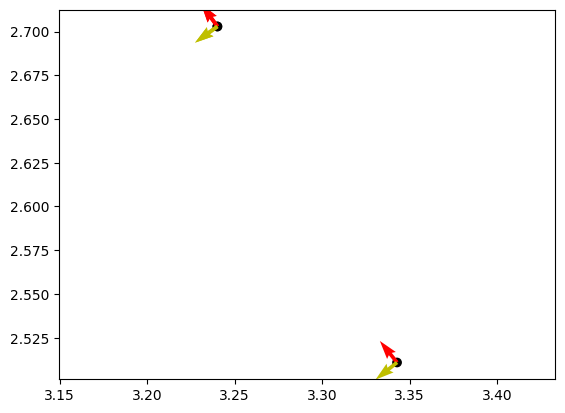

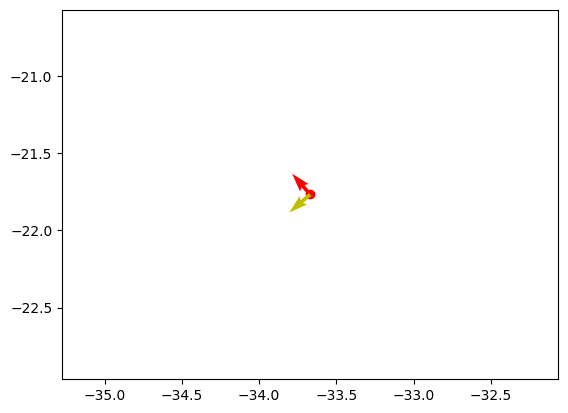

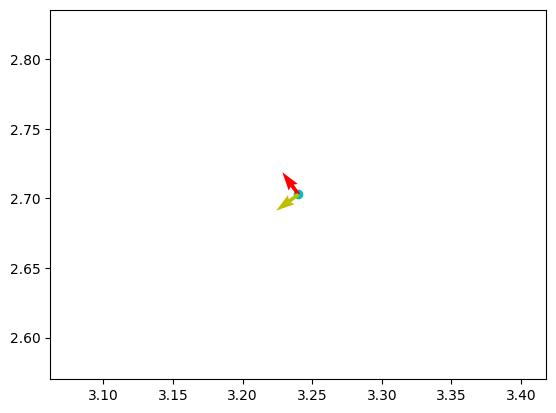

4 5


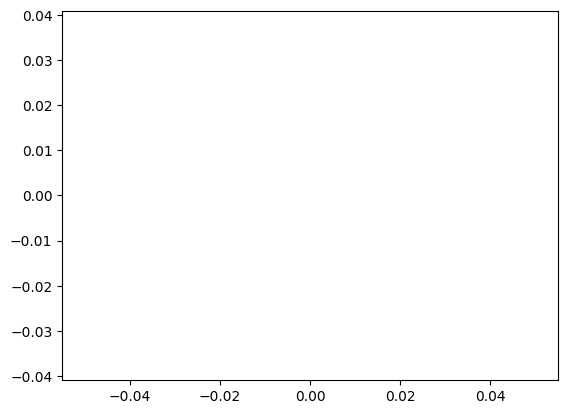

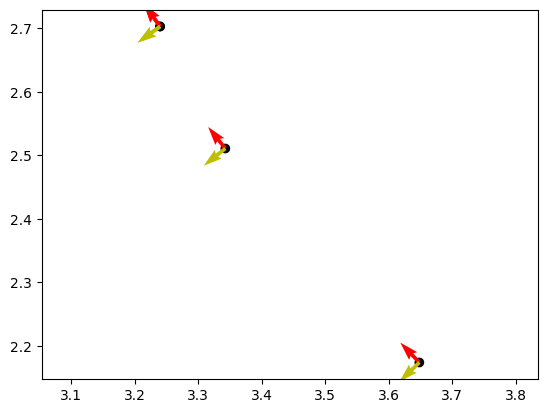

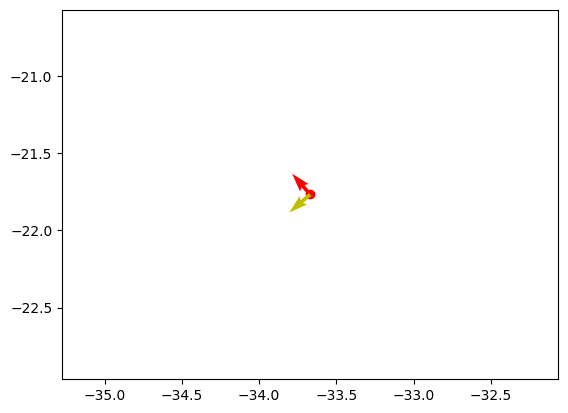

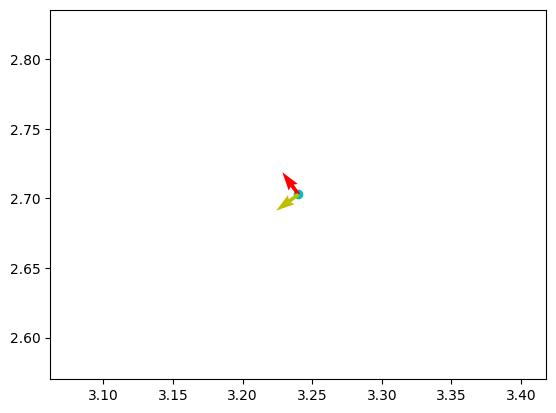

4 5


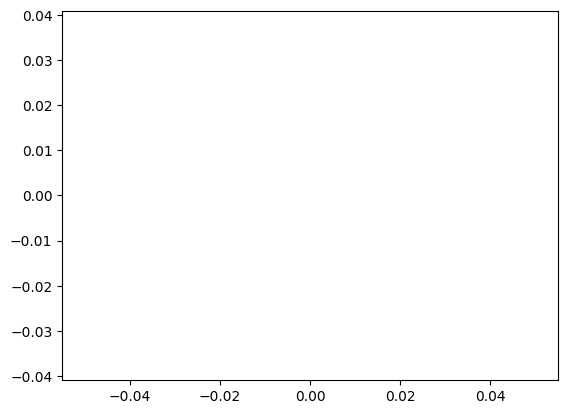

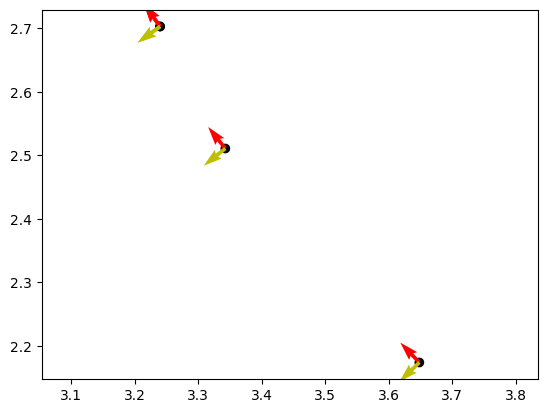

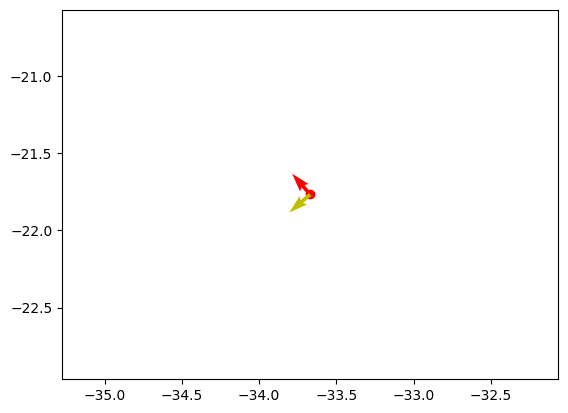

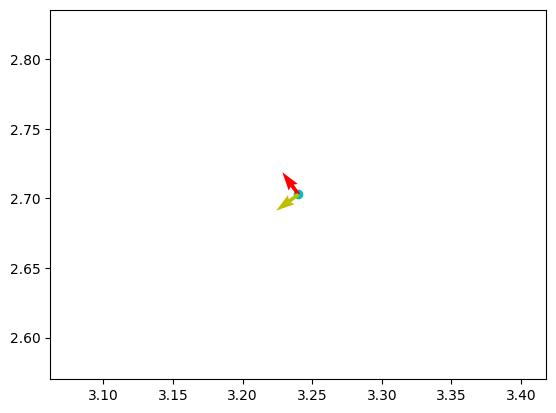

4 5


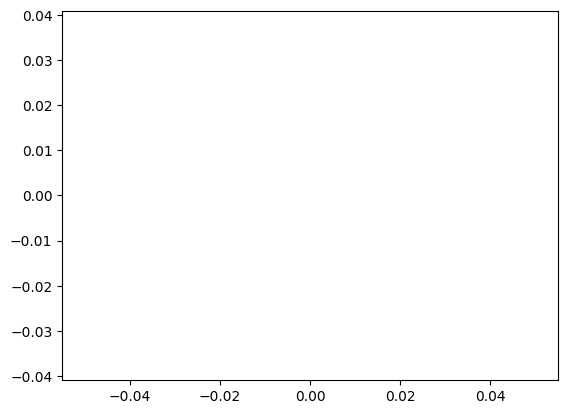

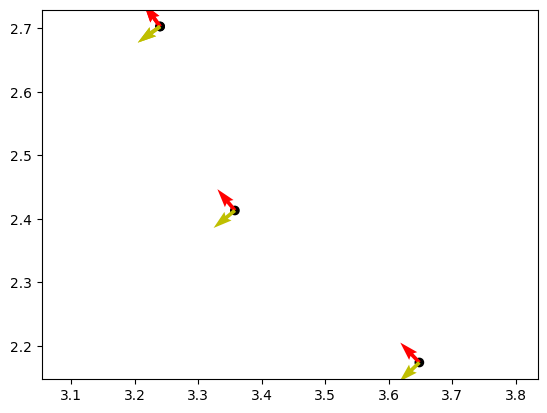

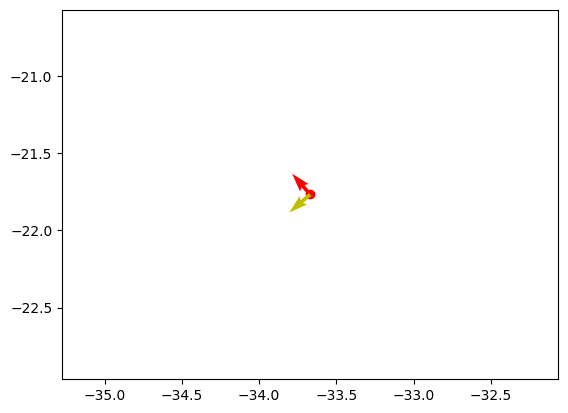

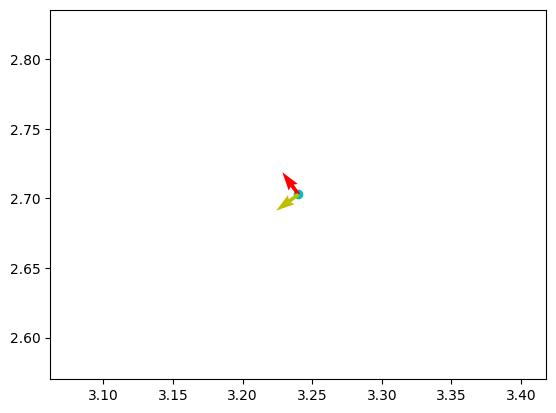

4 5


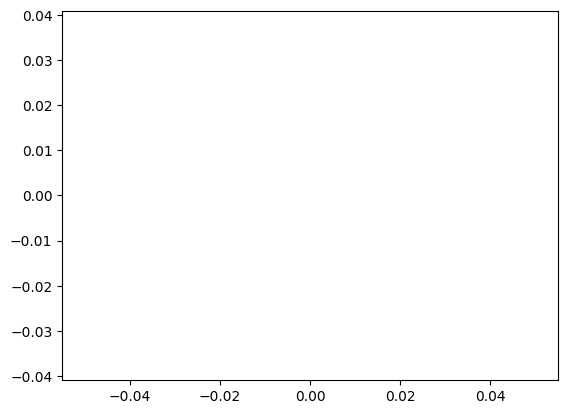

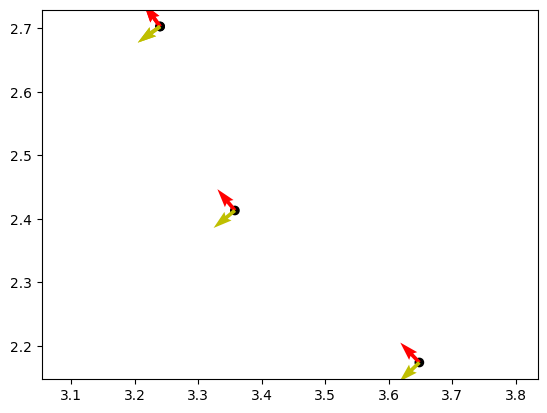

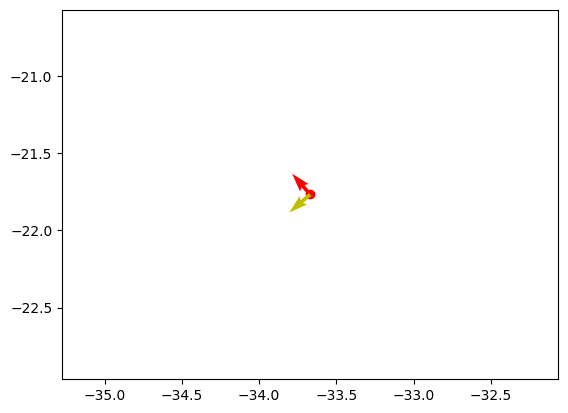

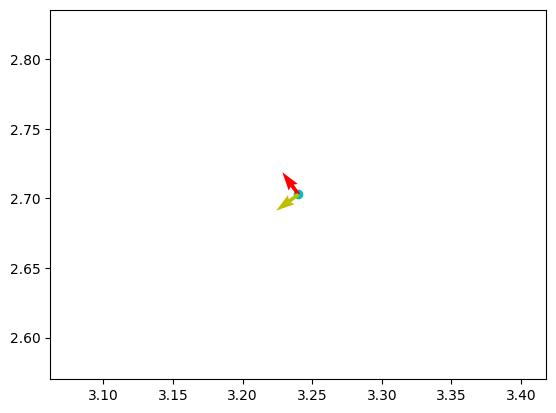

4 5


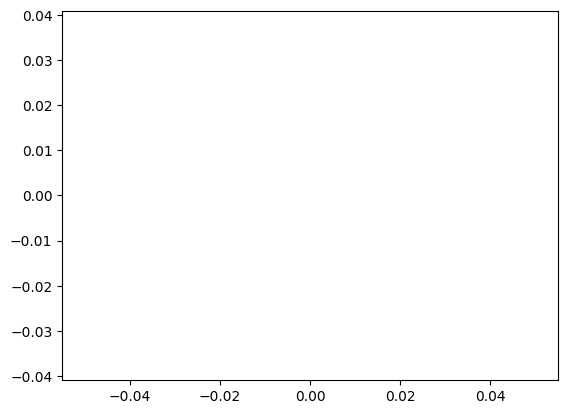

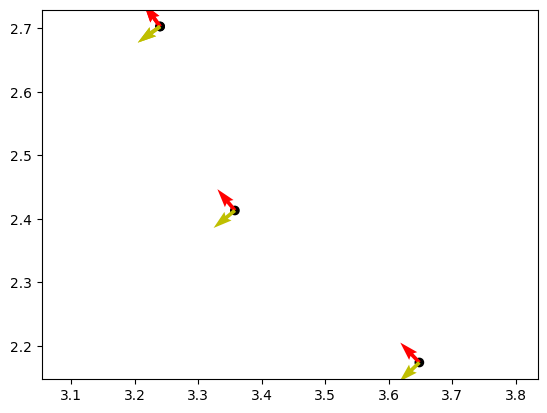

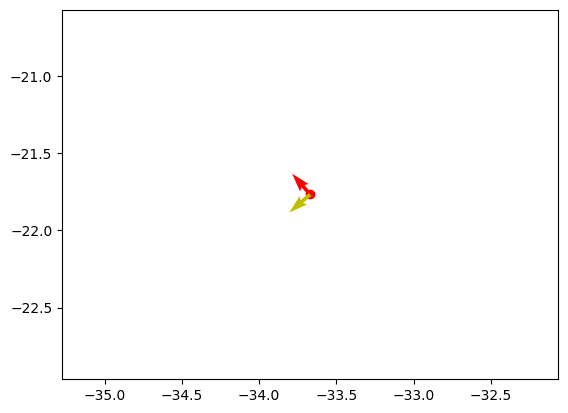

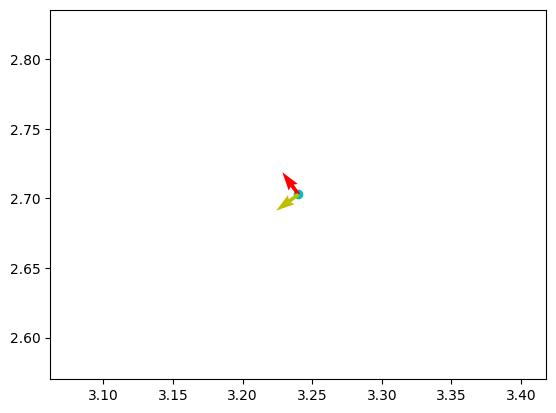

4 5


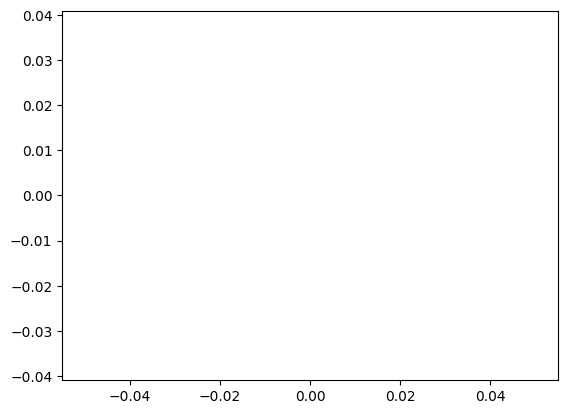

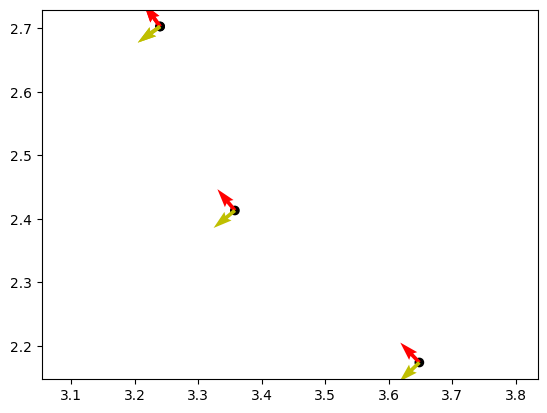

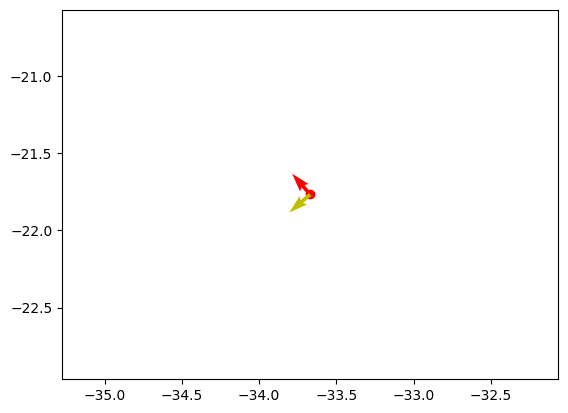

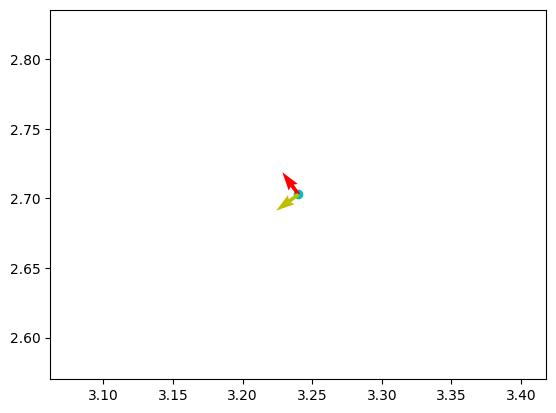

4 5


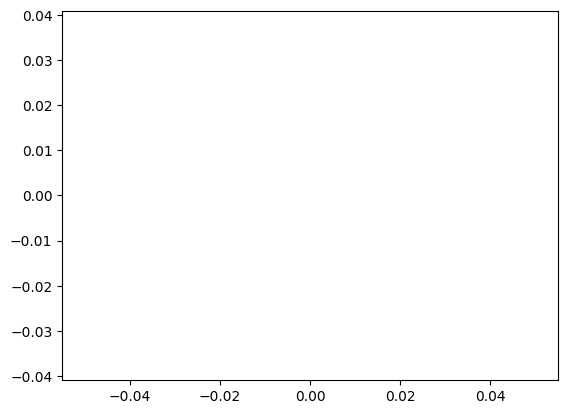

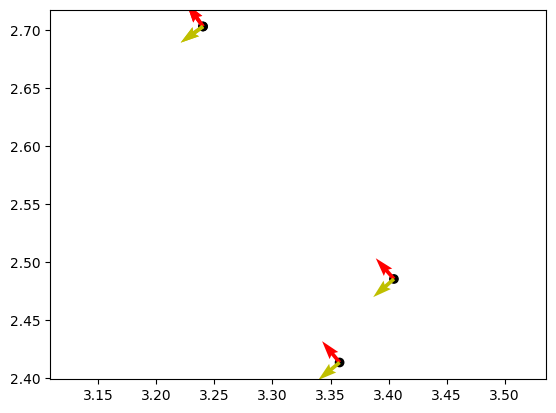

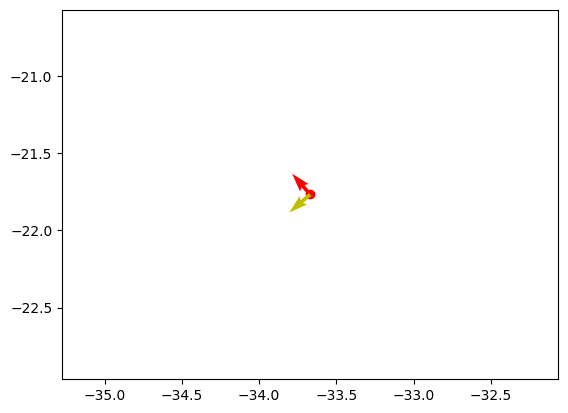

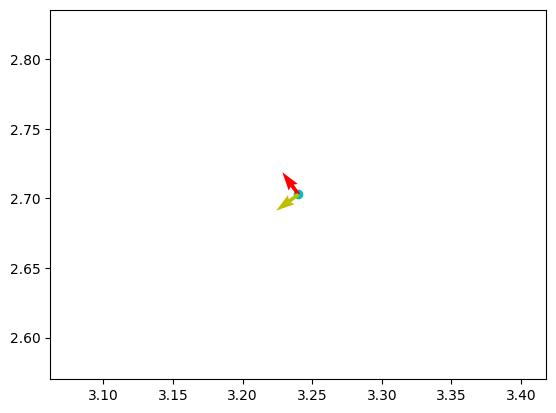

4 5


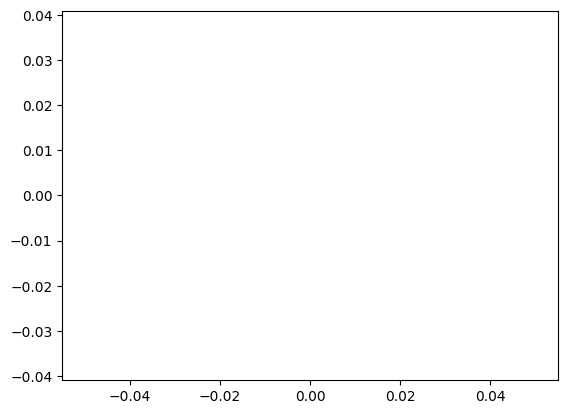

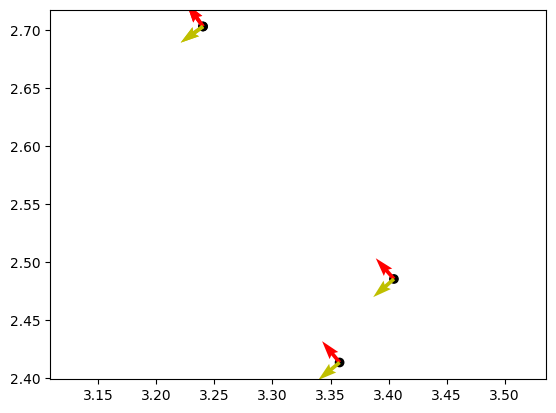

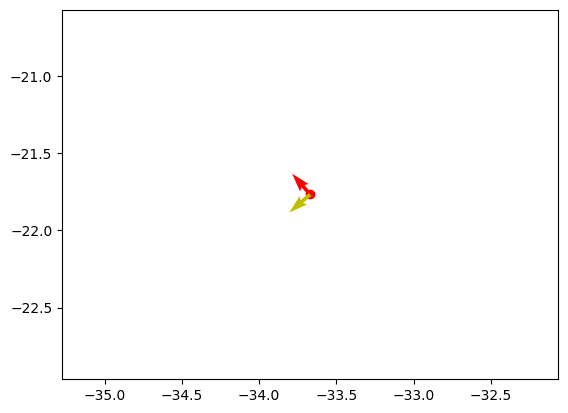

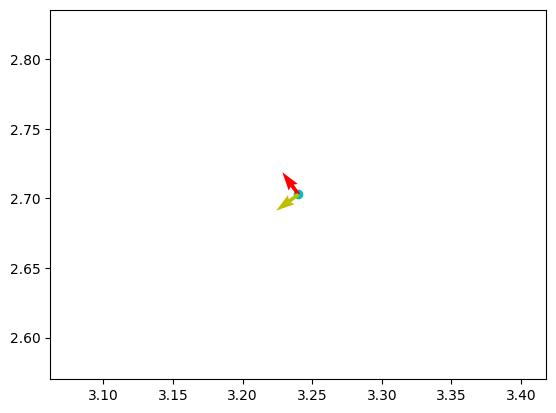

5 6


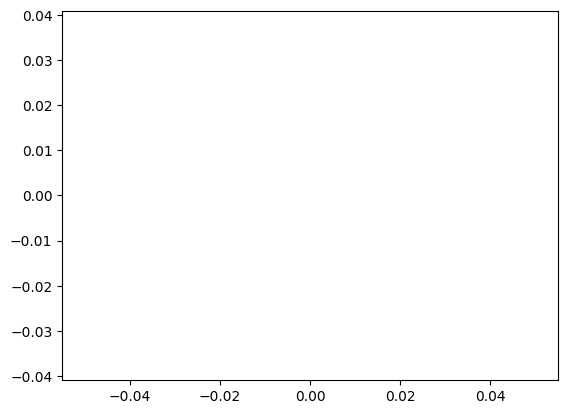

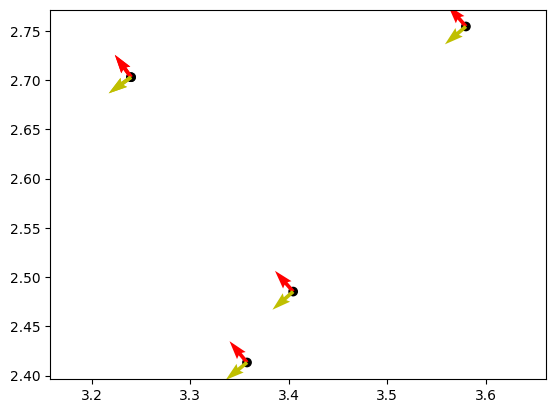

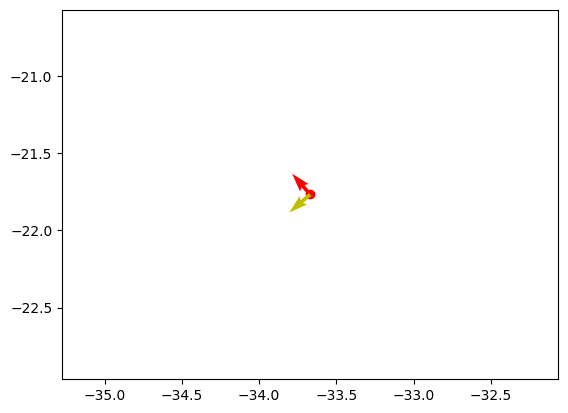

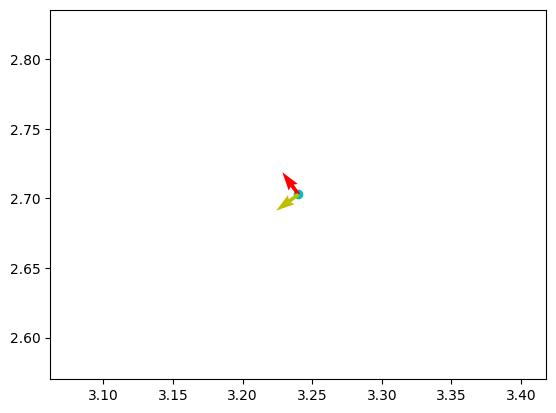

5 6


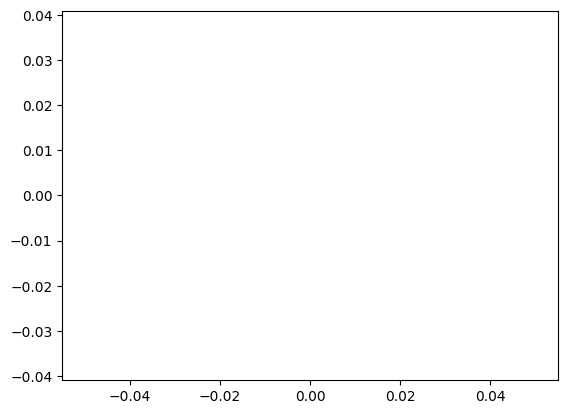

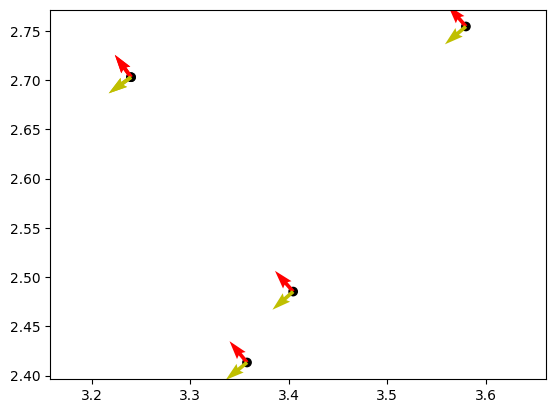

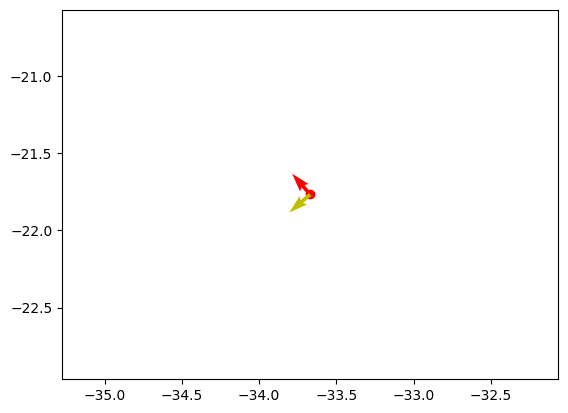

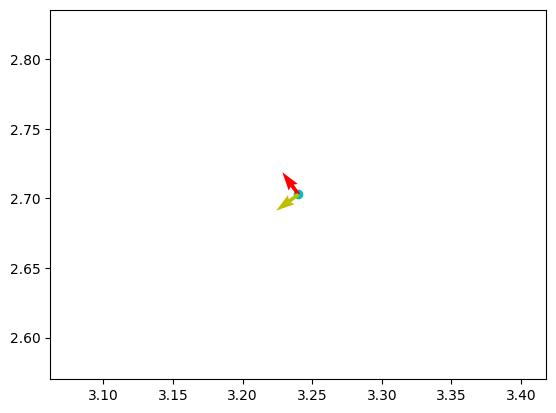

5 6


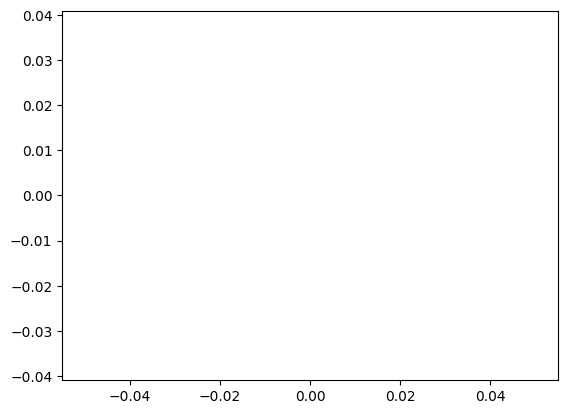

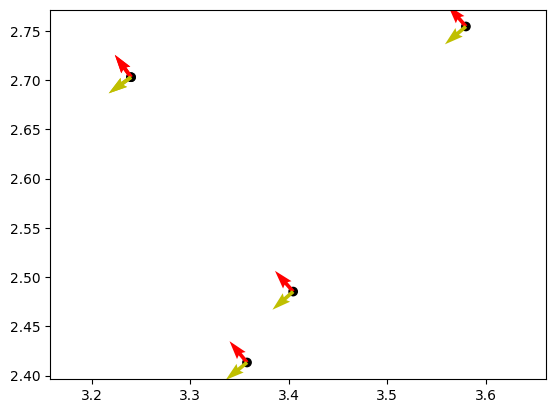

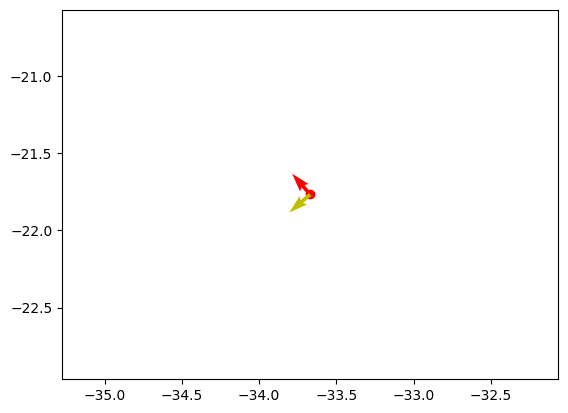

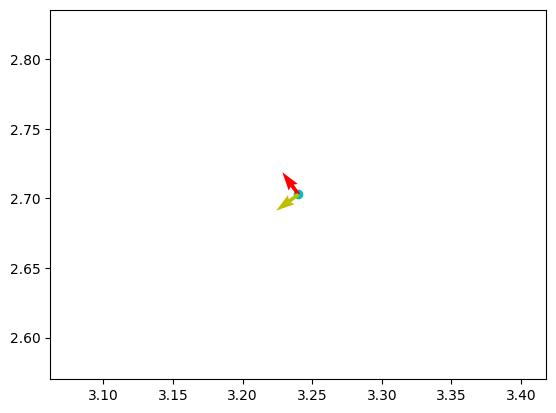

5 6


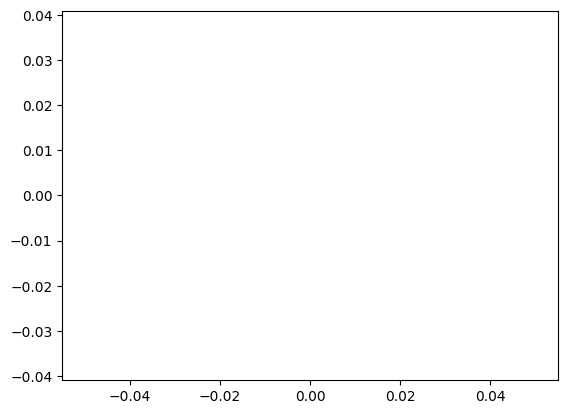

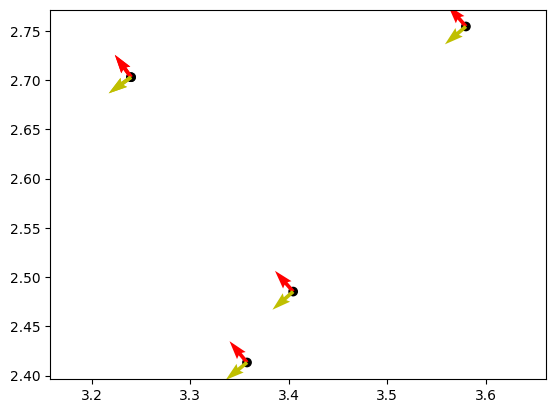

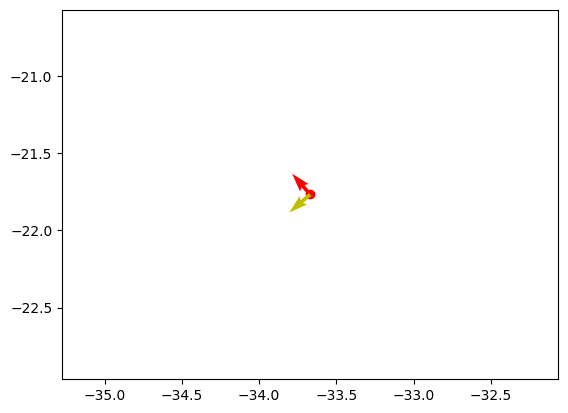

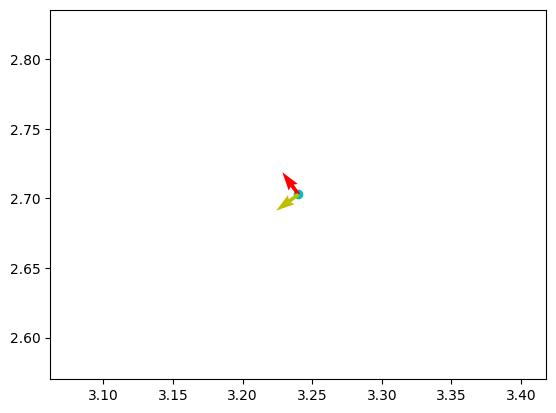

5 6


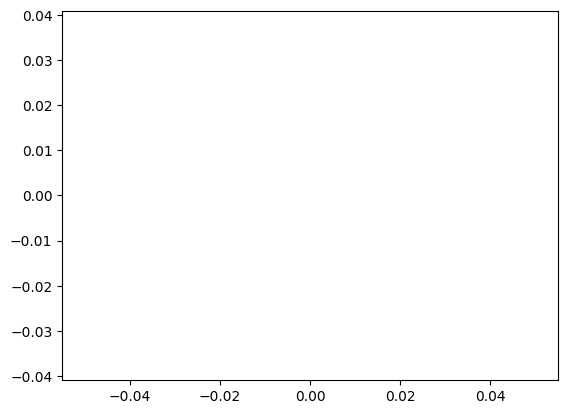

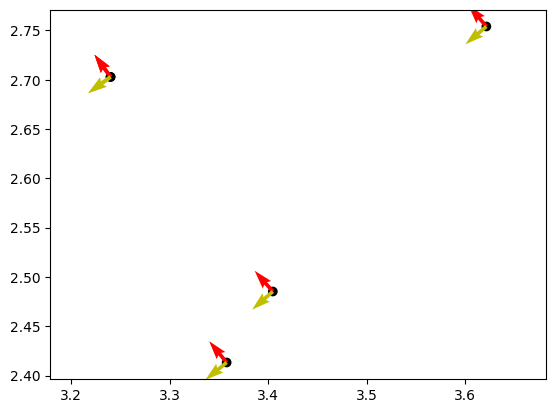

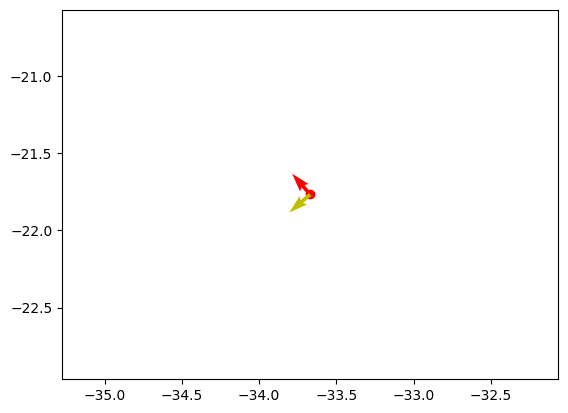

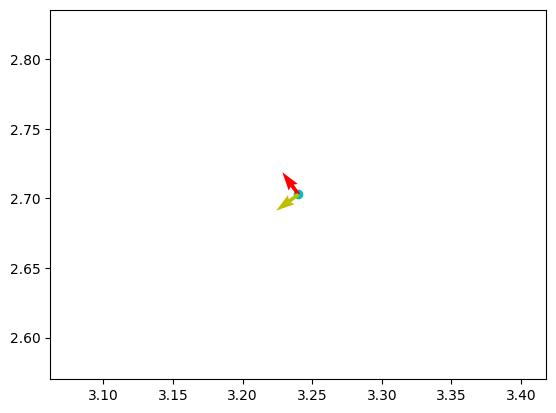

5 6


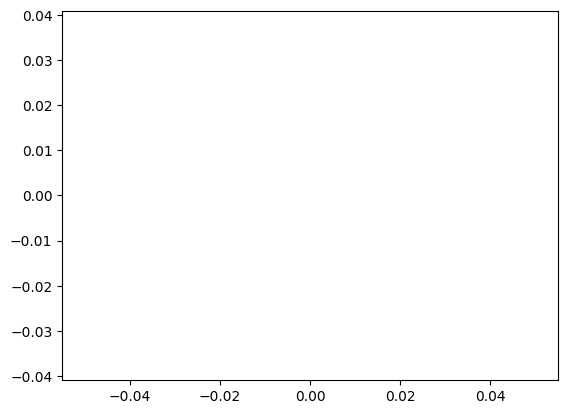

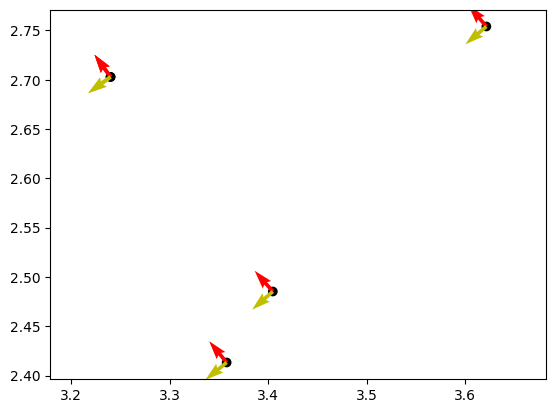

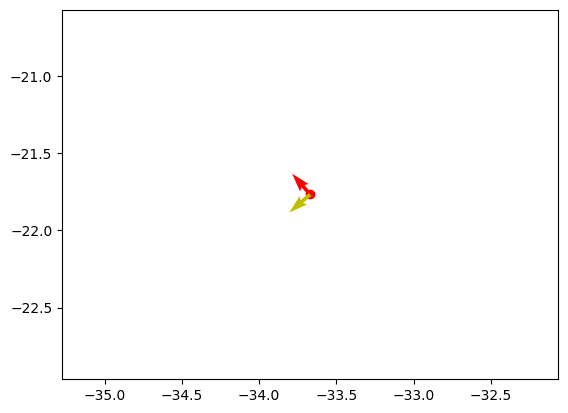

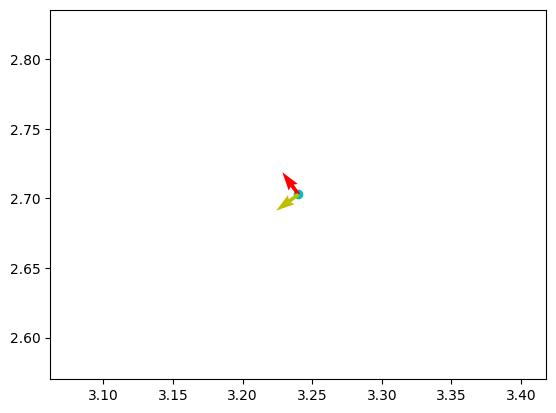

5 6


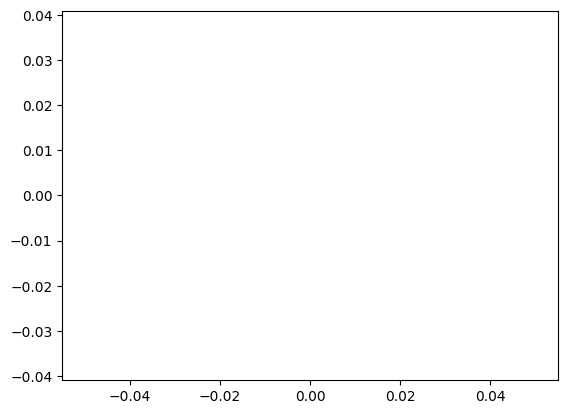

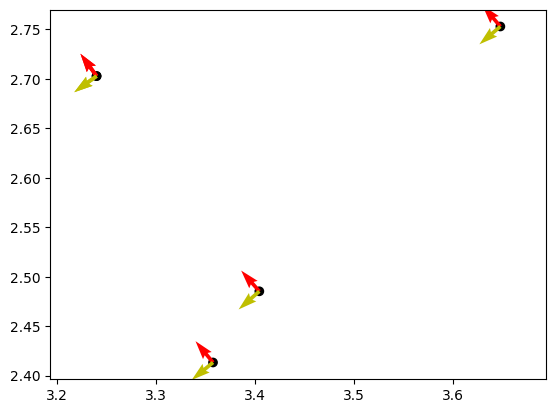

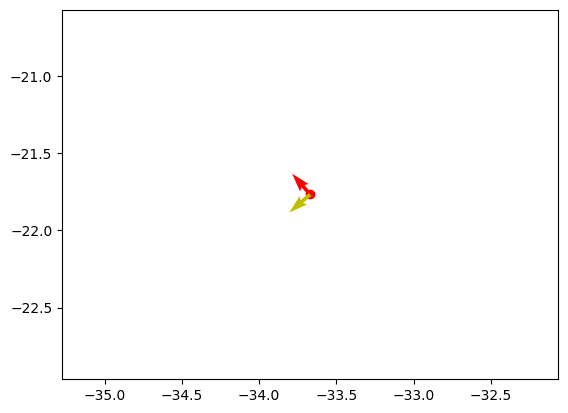

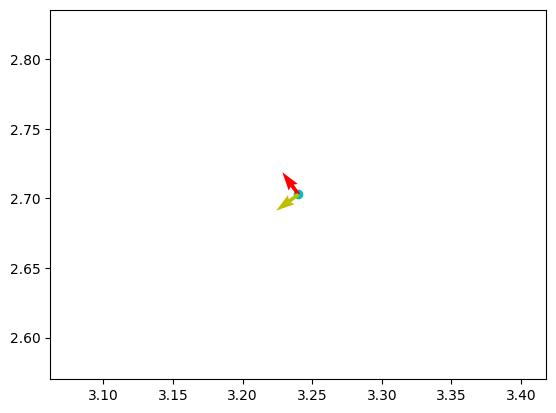

5 6


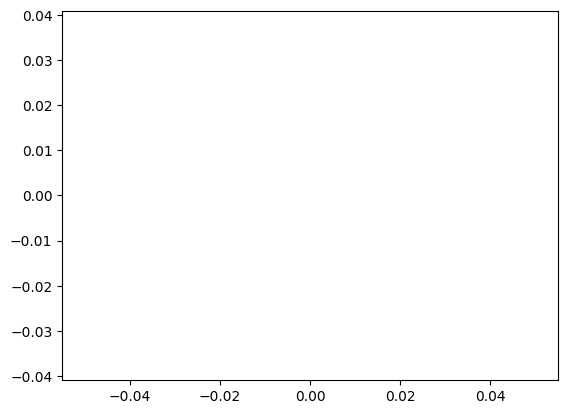

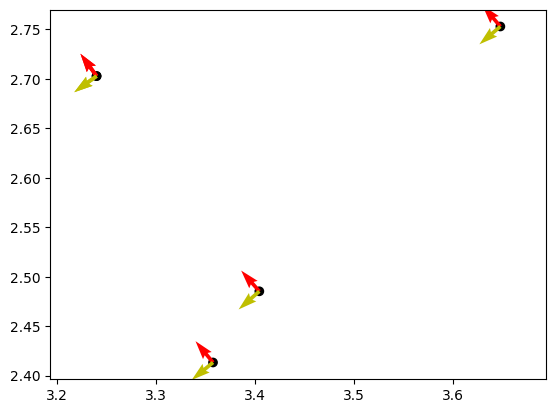

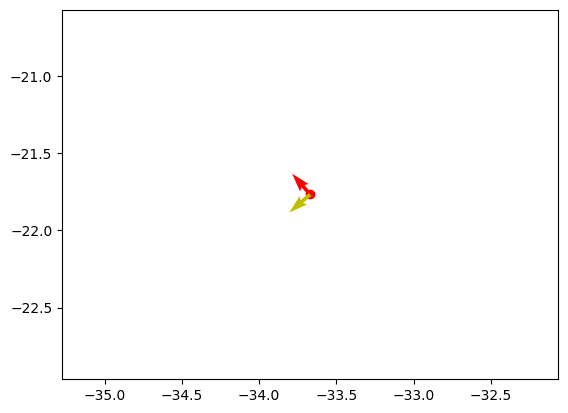

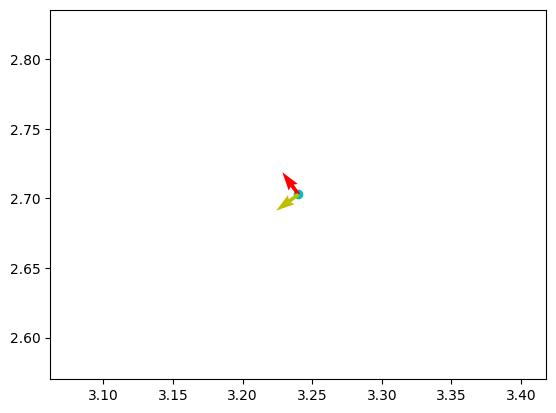

6 7


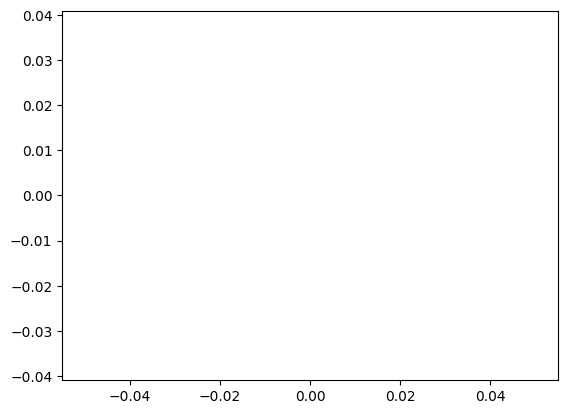

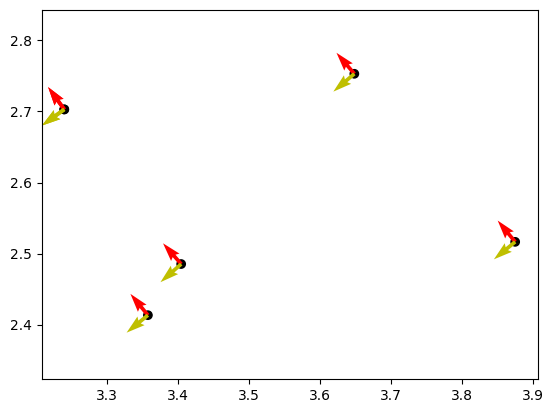

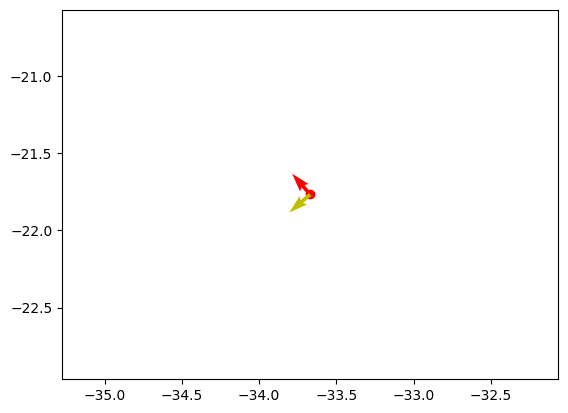

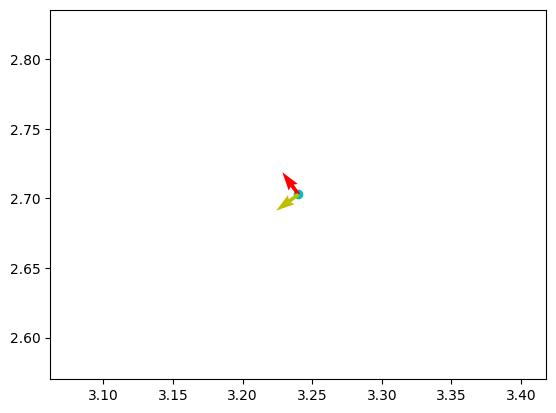

6 7


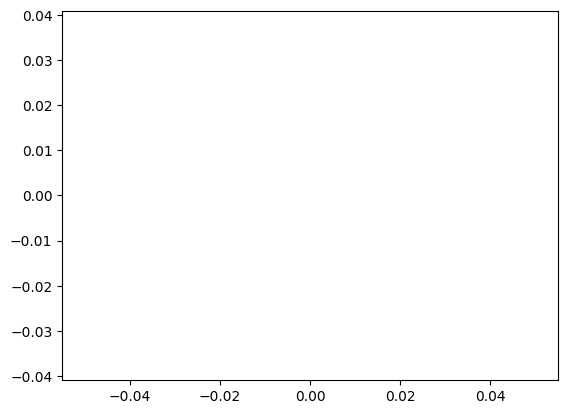

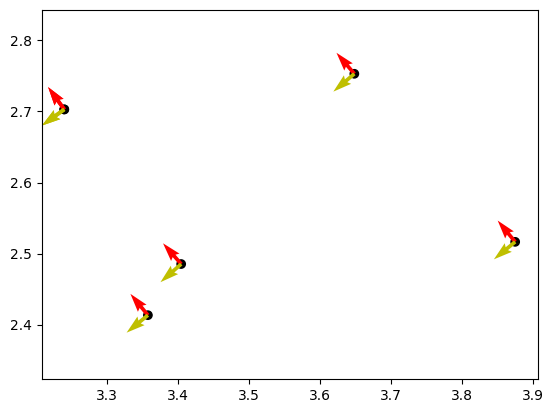

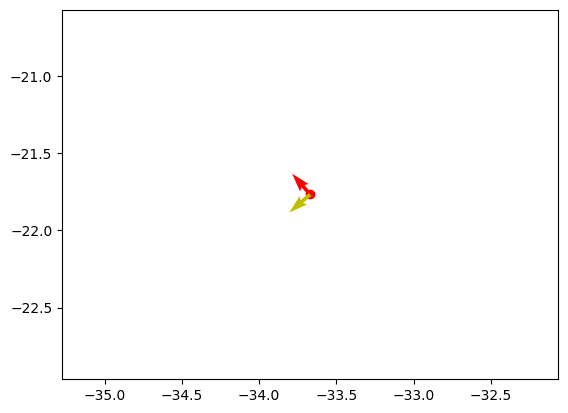

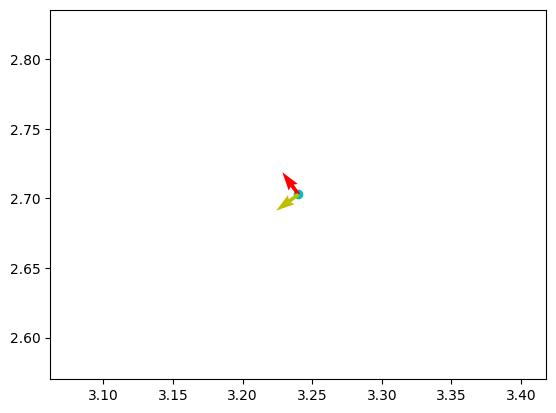

6 7


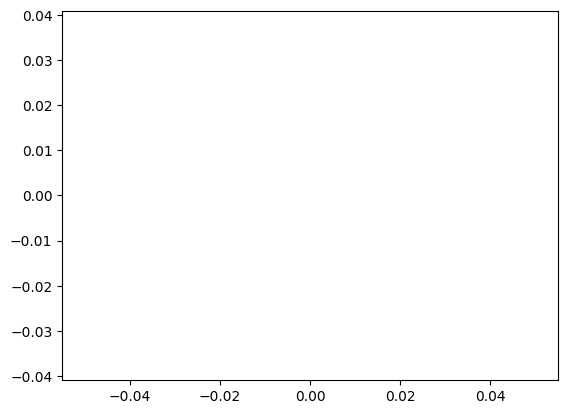

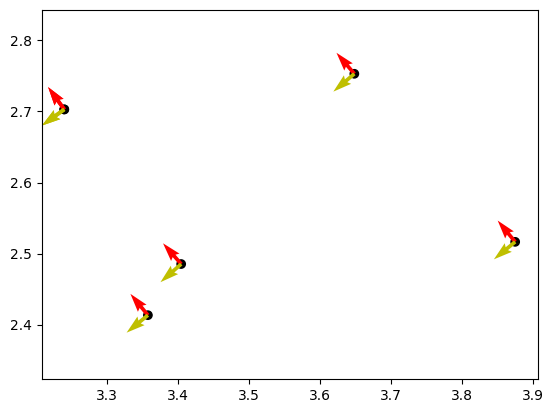

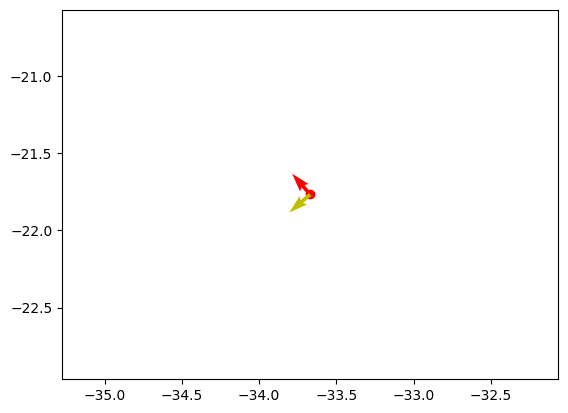

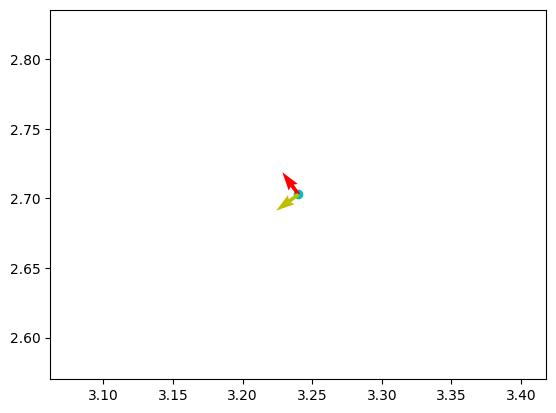

6 7


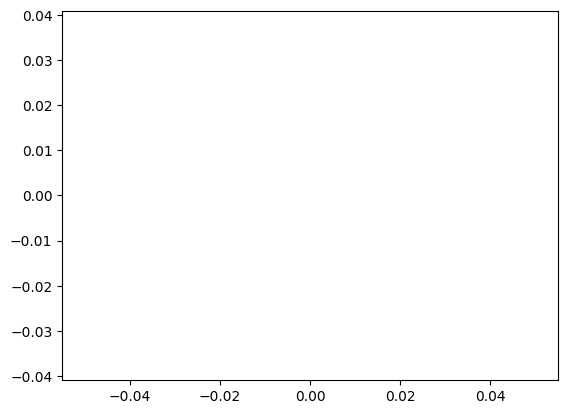

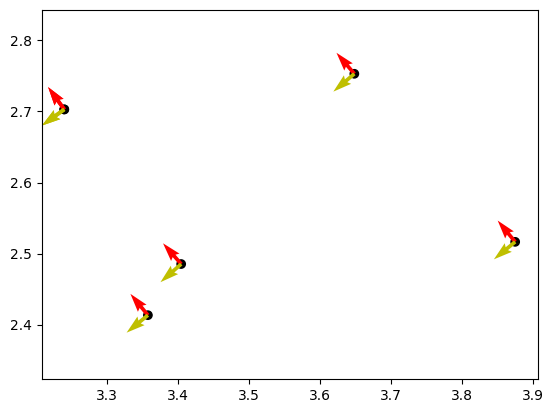

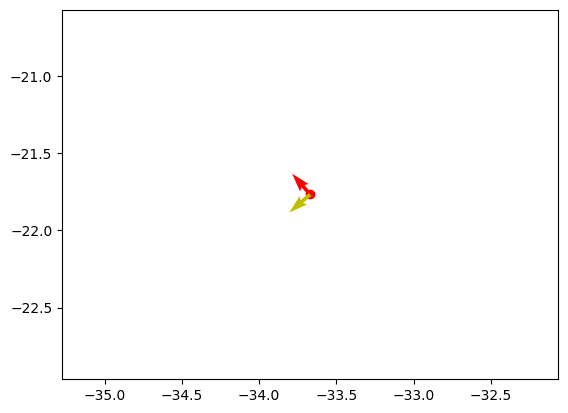

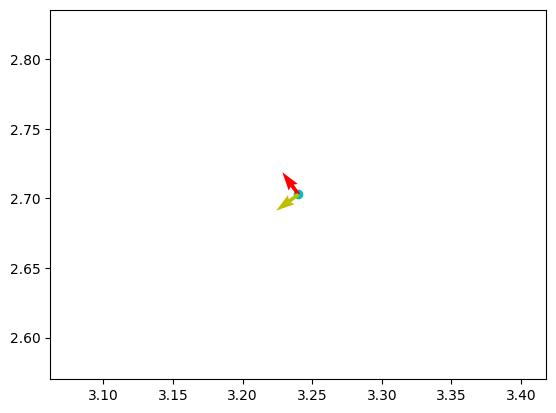

7 8


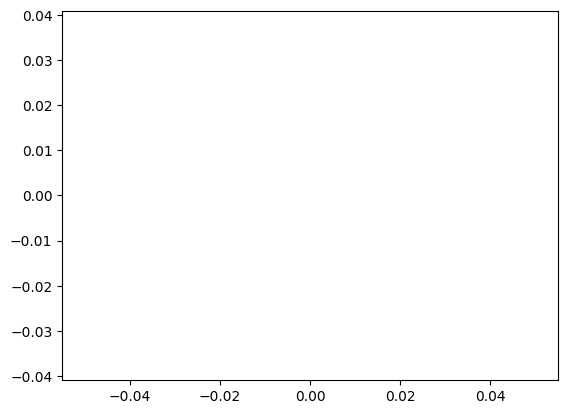

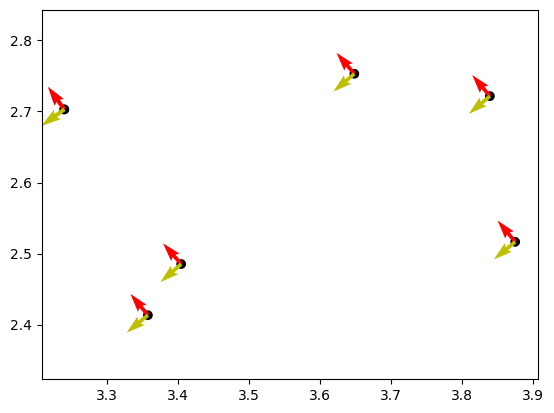

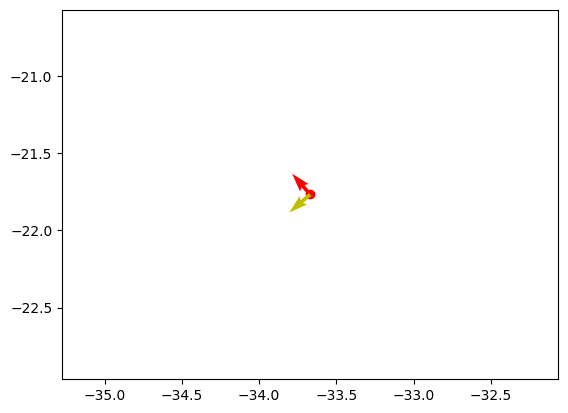

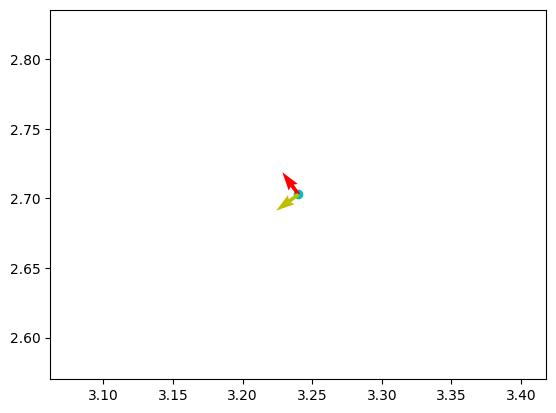

7 8


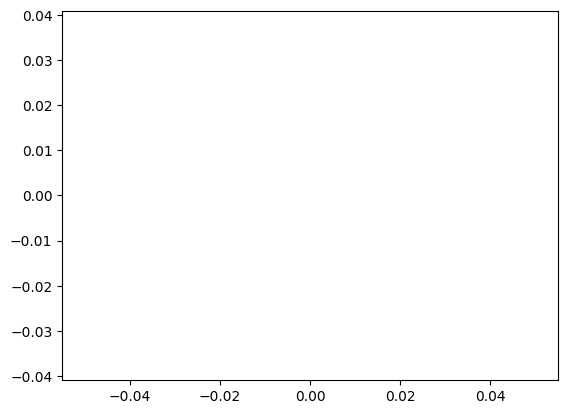

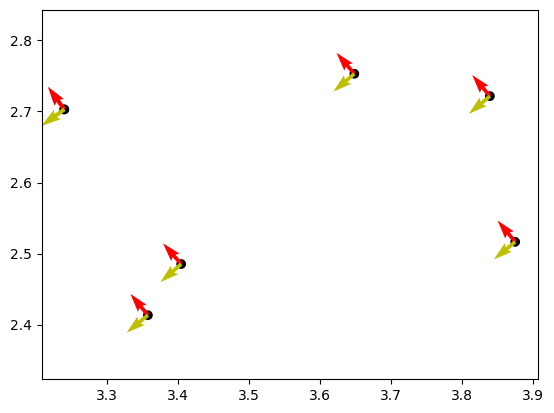

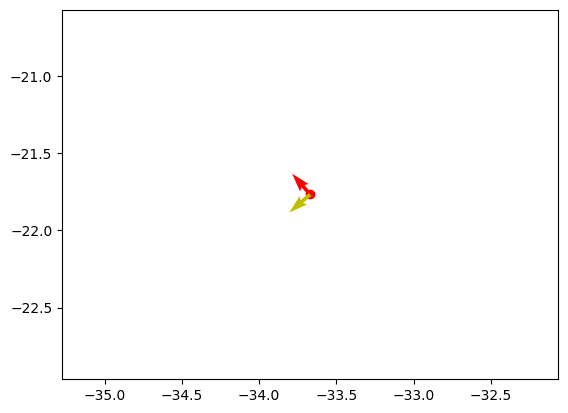

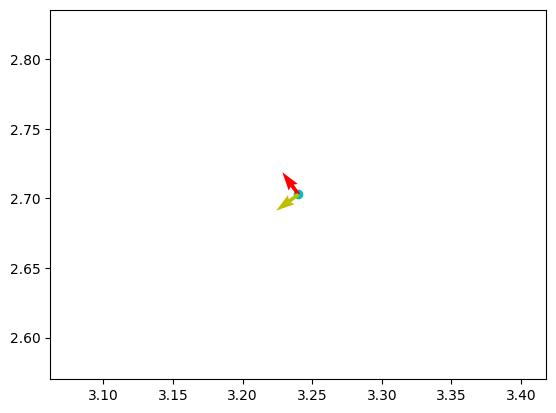

7 8


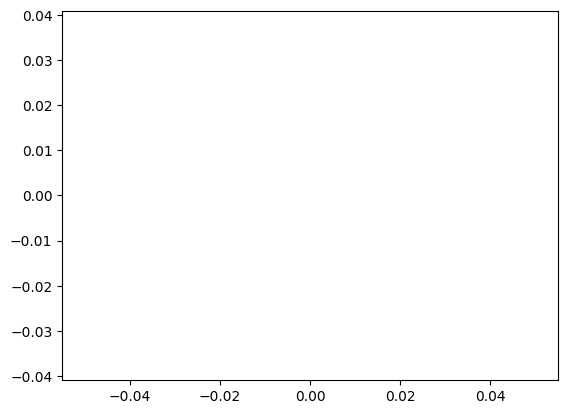

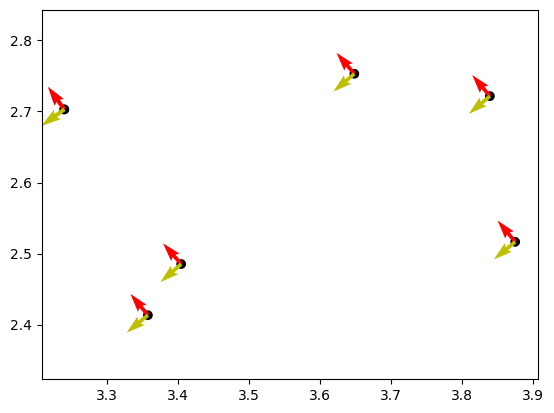

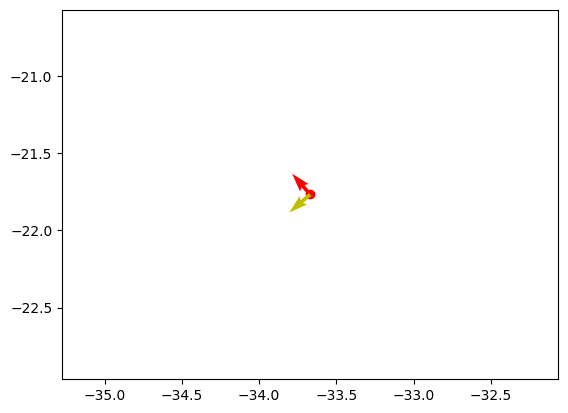

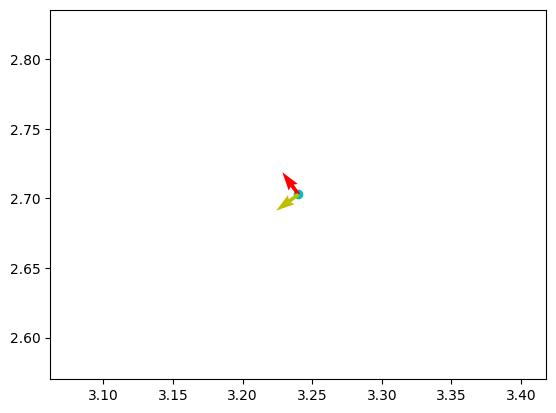

7 8


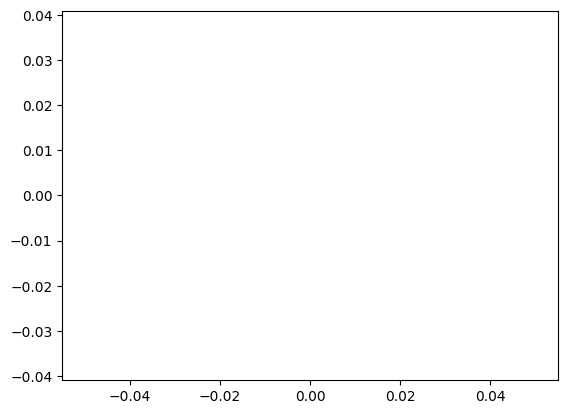

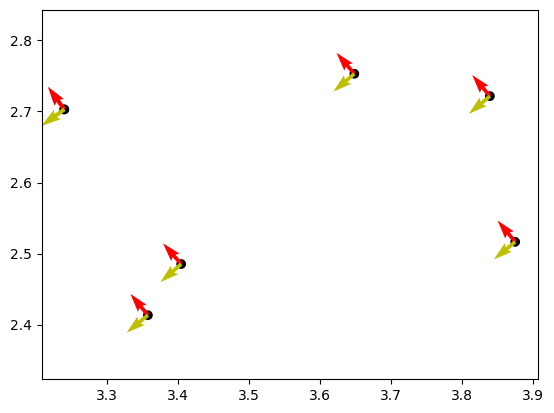

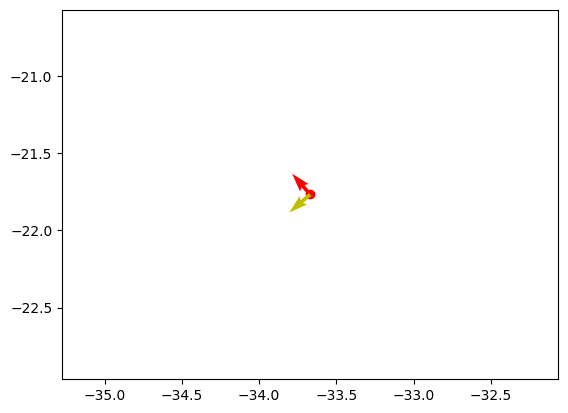

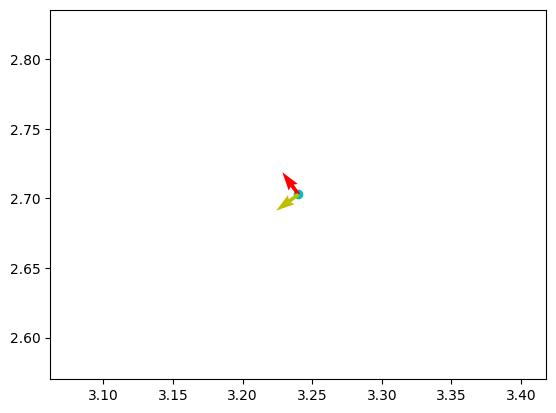

7 8


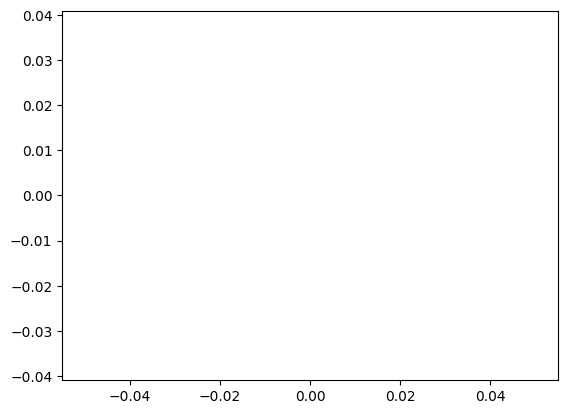

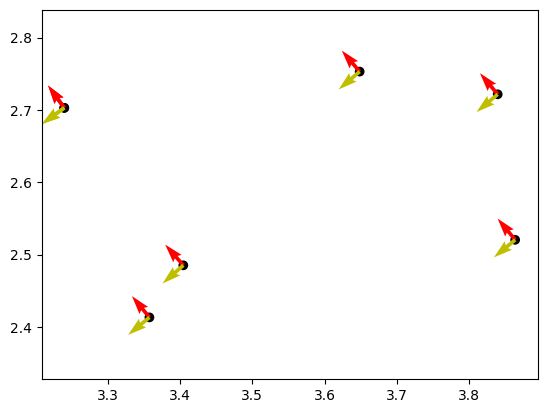

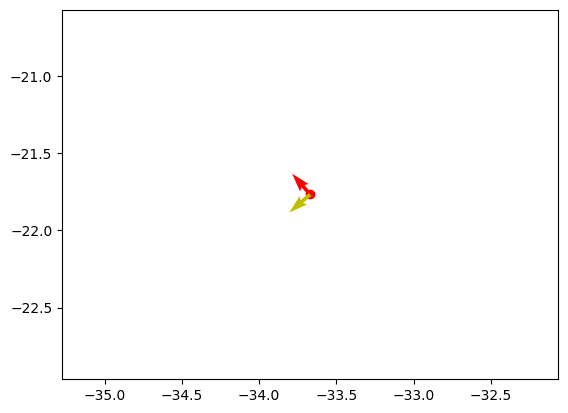

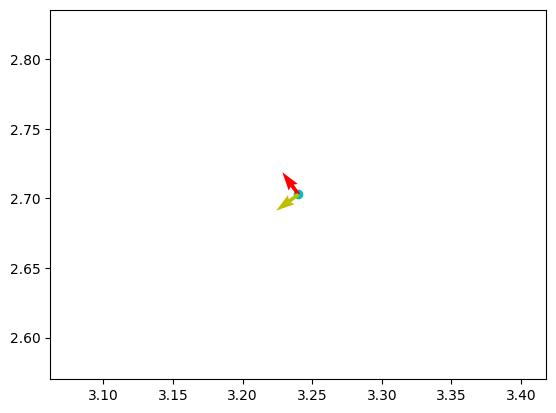

7 8


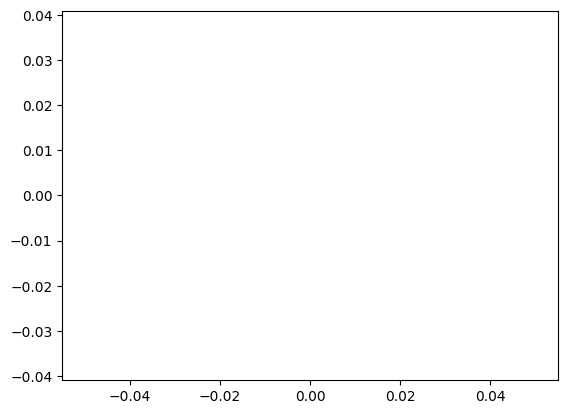

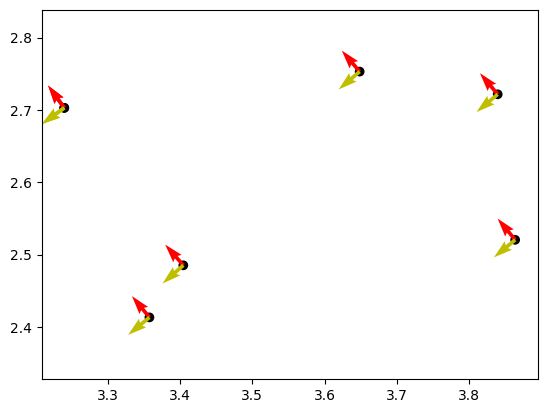

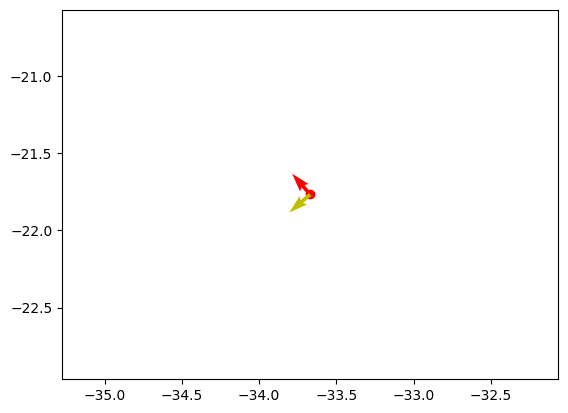

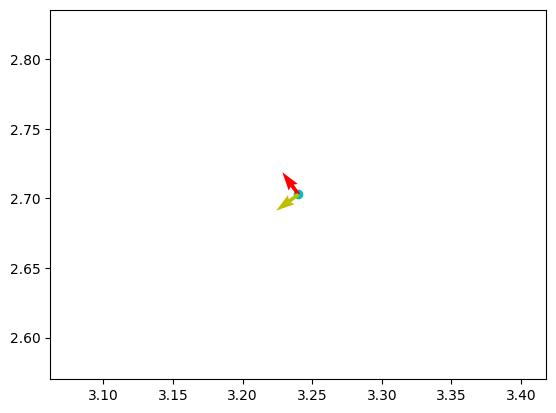

7 8


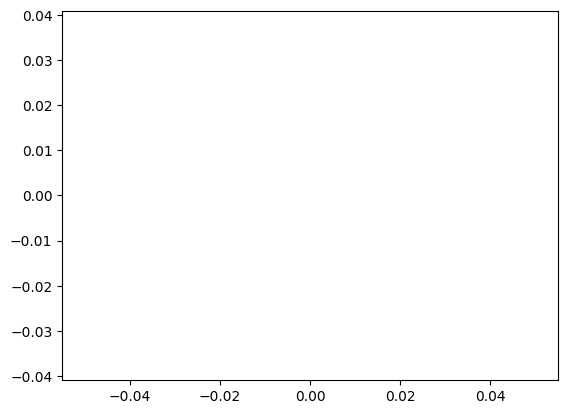

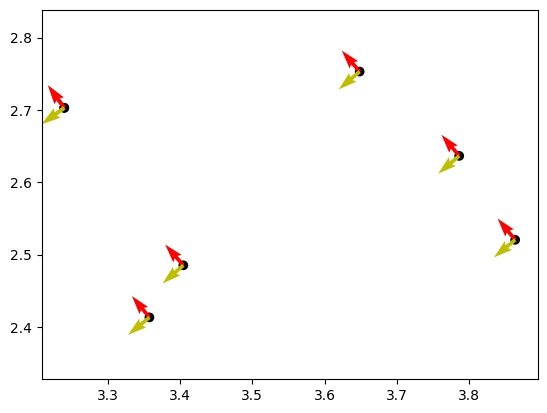

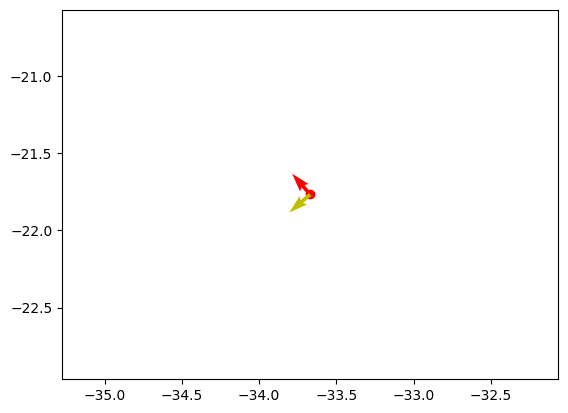

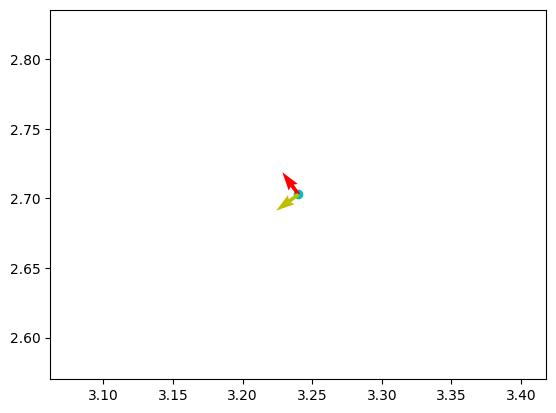

7 8


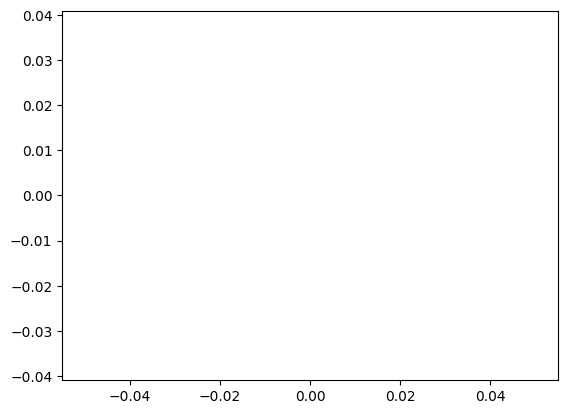

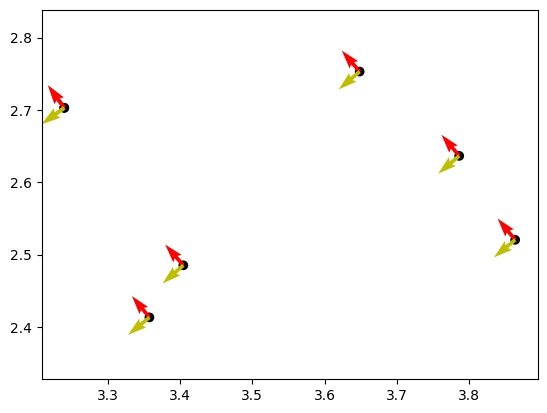

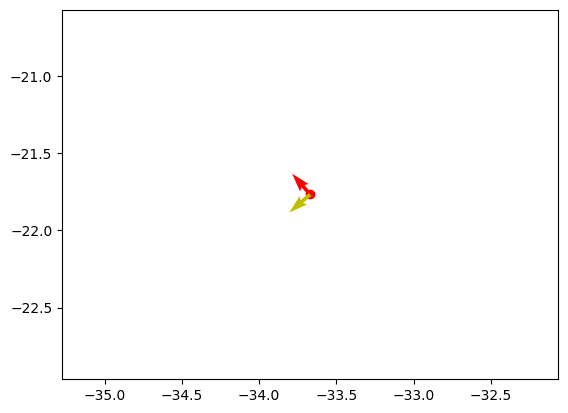

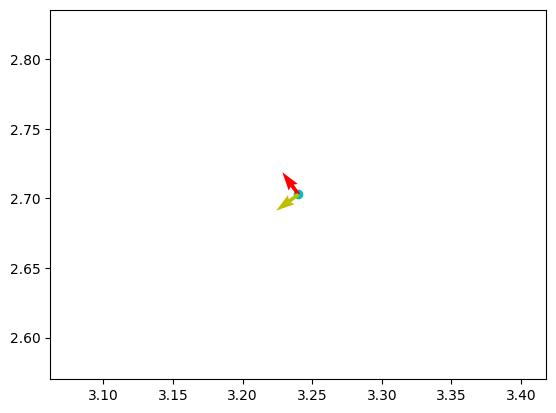

7 8


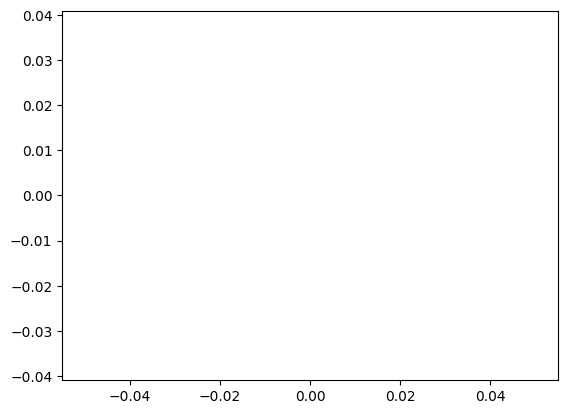

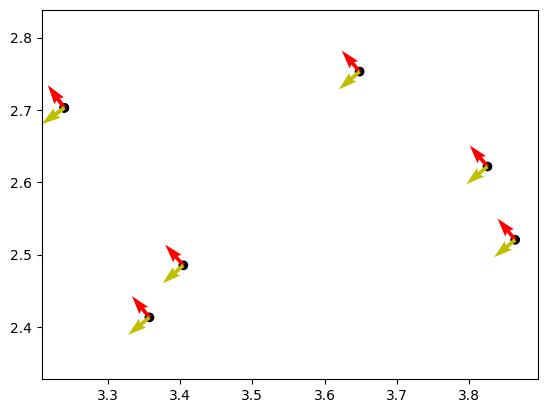

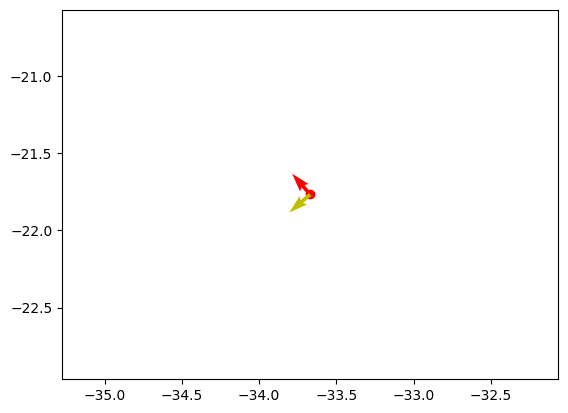

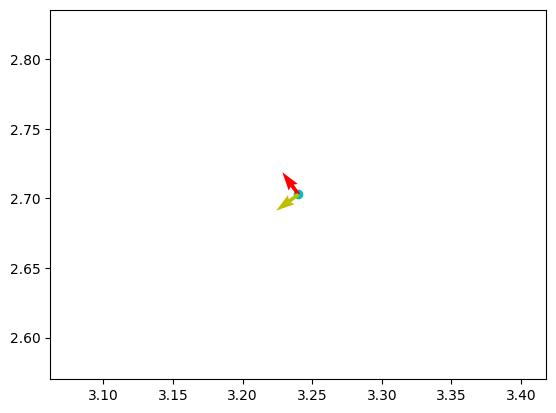

7 8


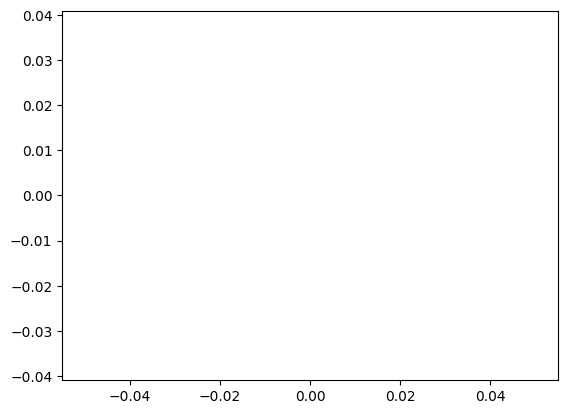

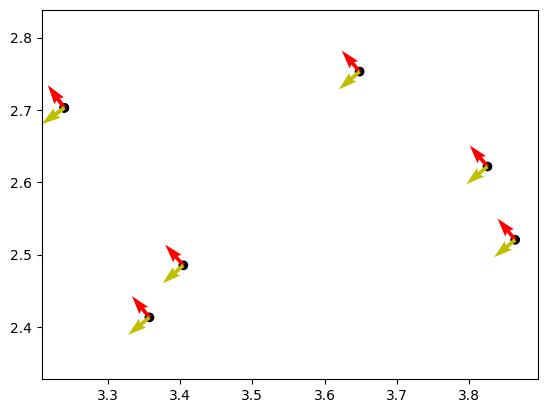

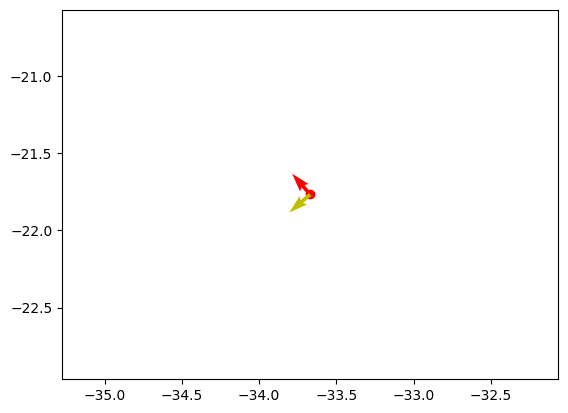

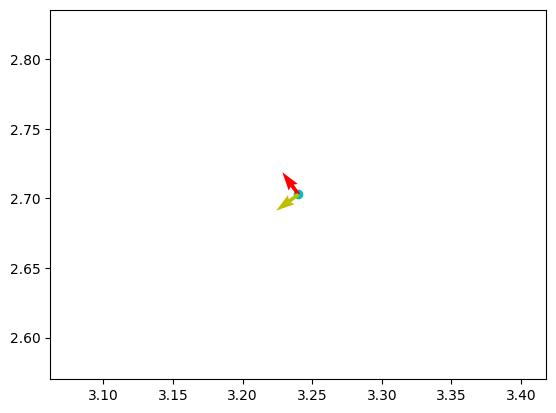

7 8


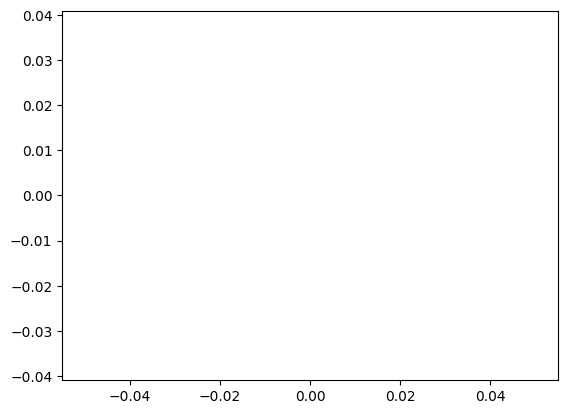

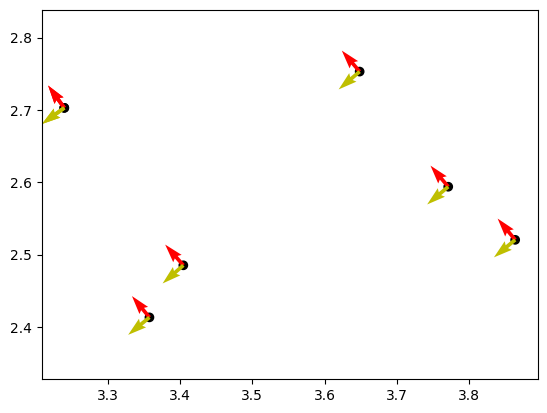

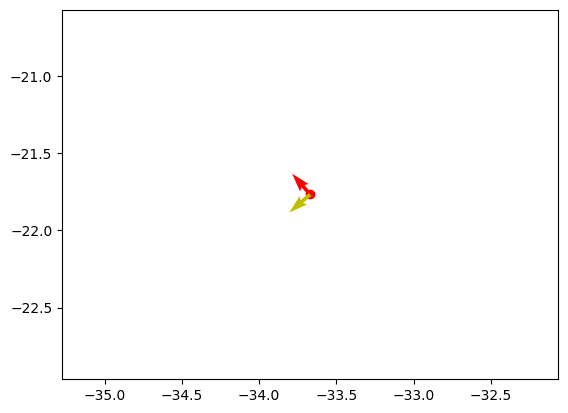

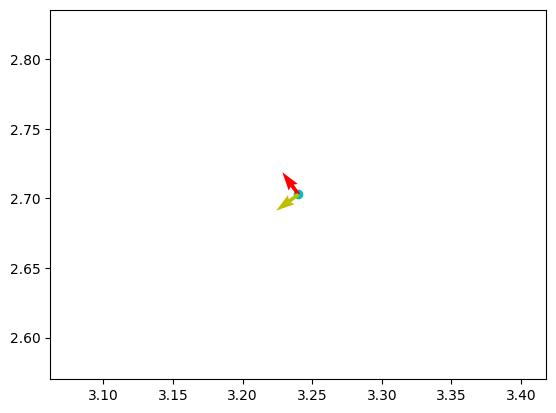

7 8


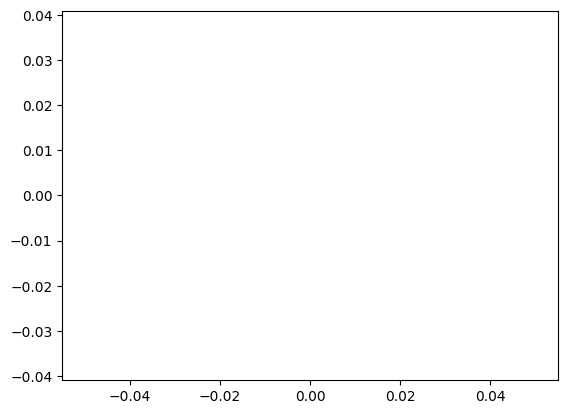

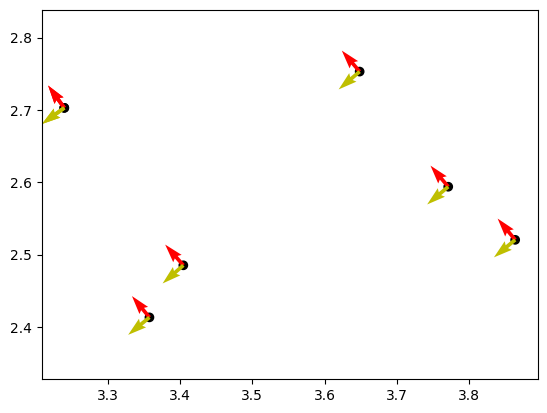

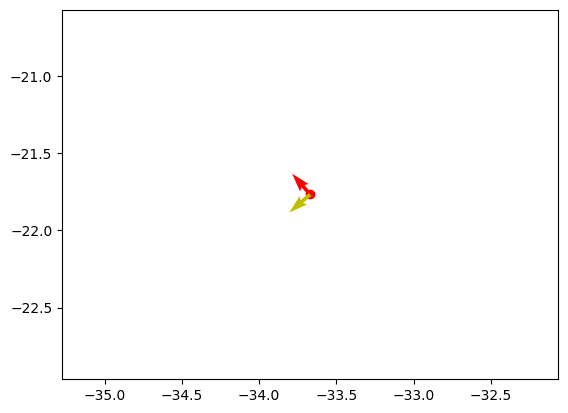

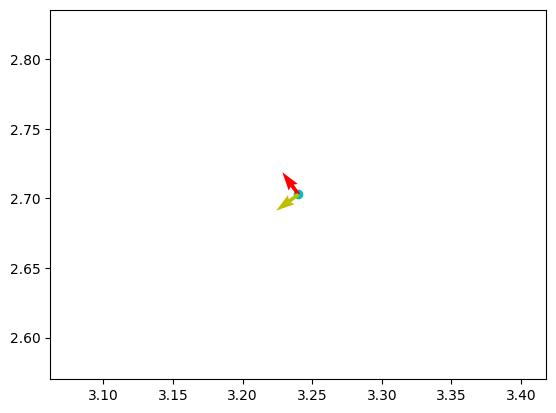

8 9


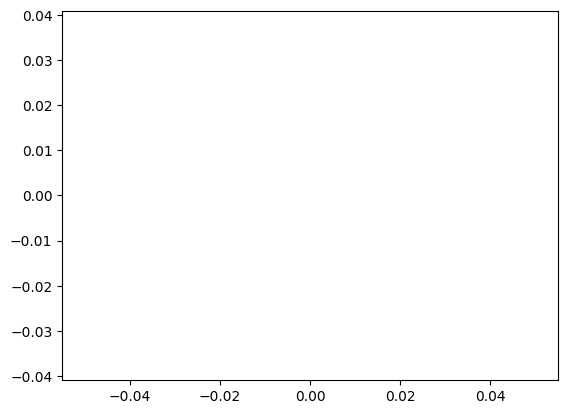

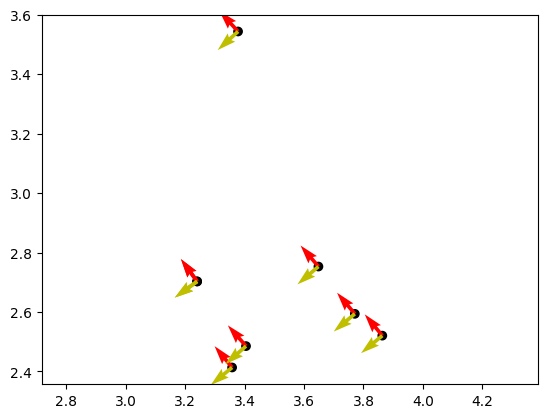

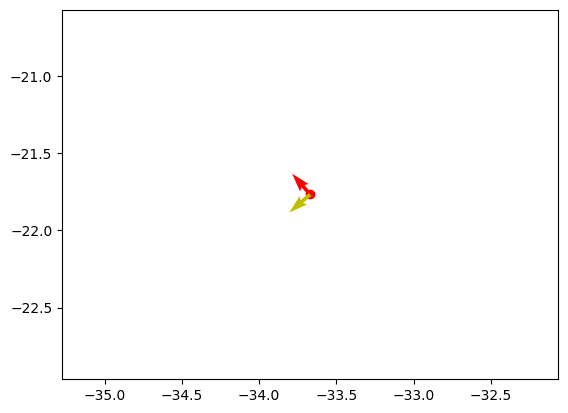

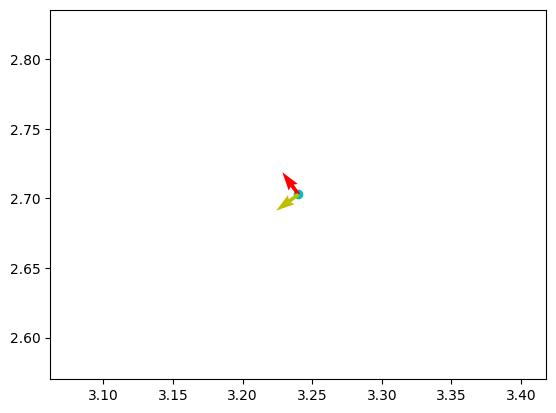

8 9


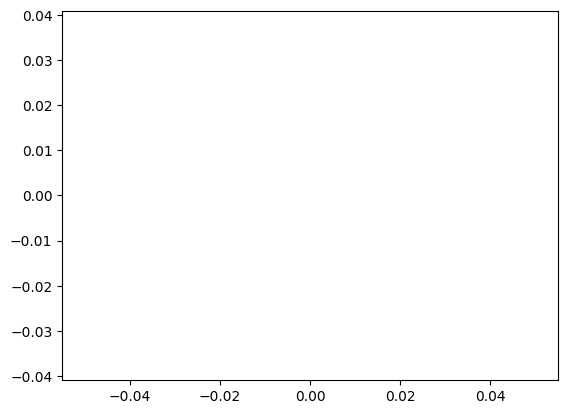

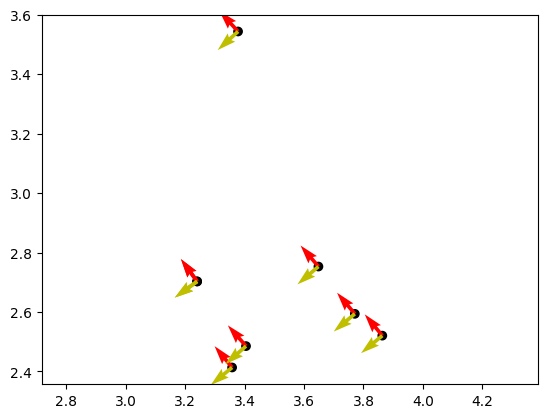

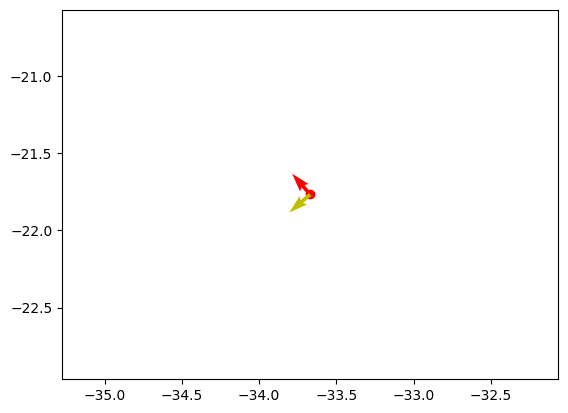

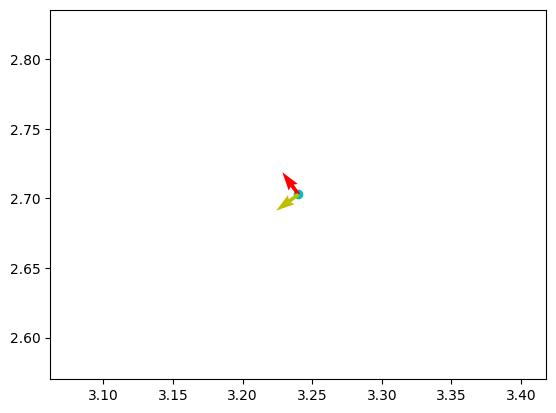

8 9


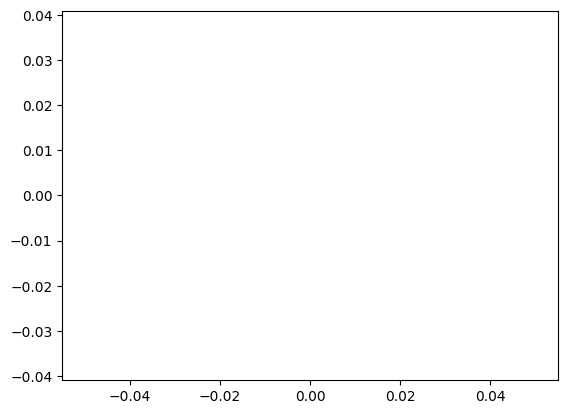

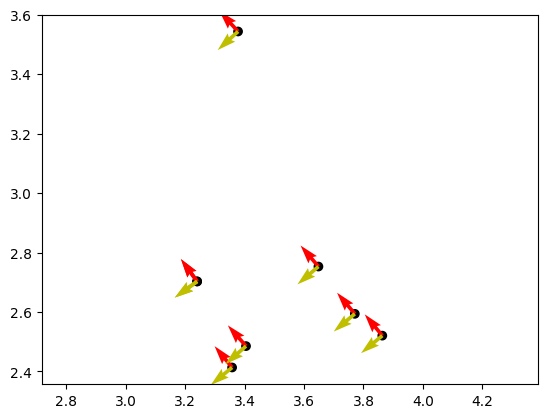

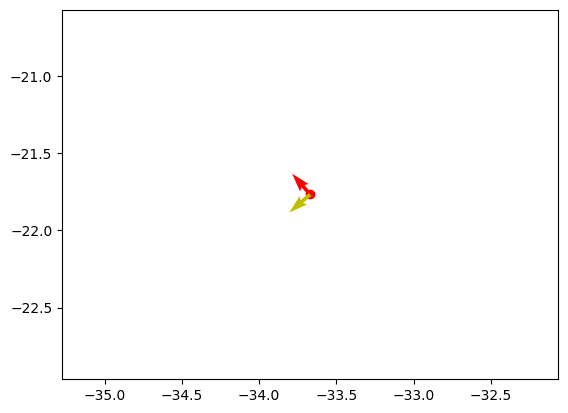

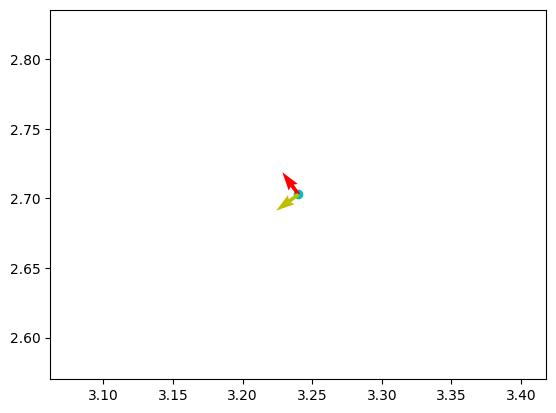

8 9


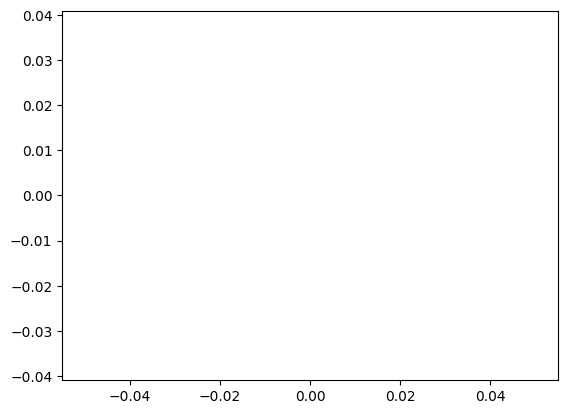

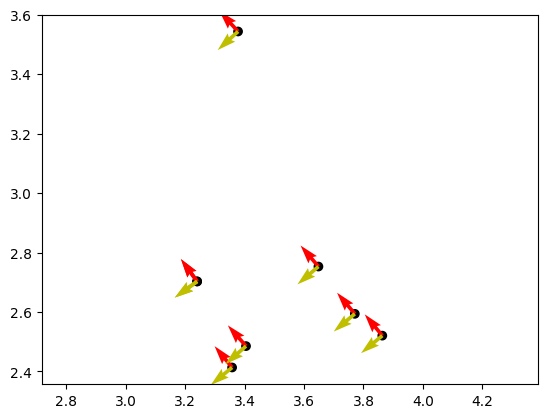

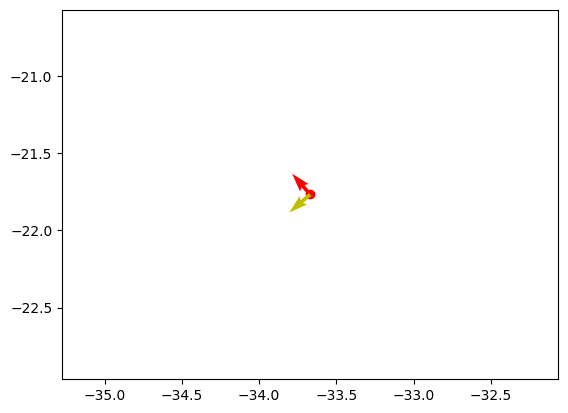

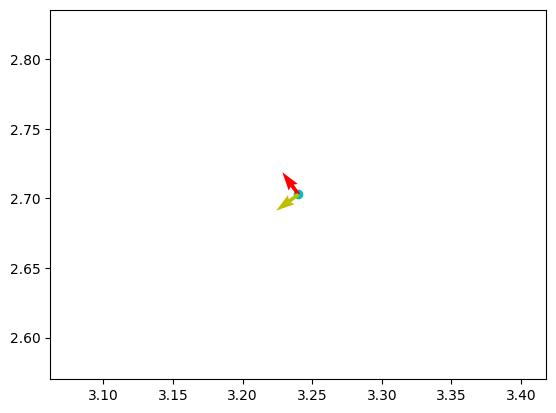

9 10


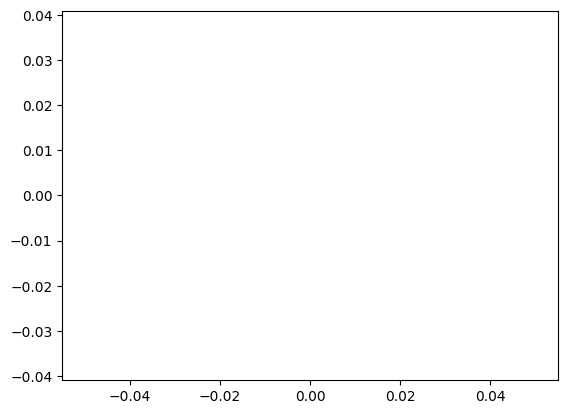

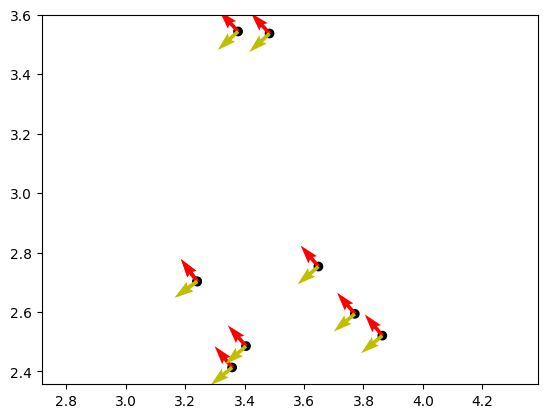

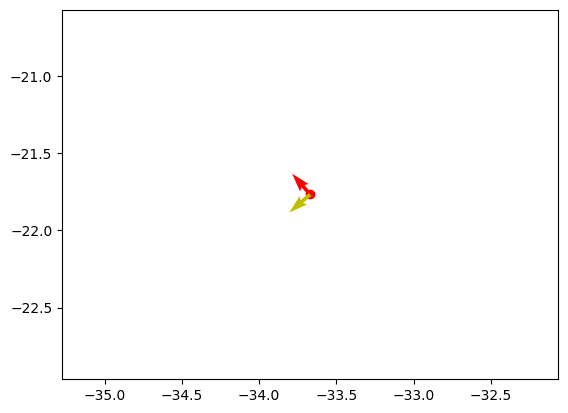

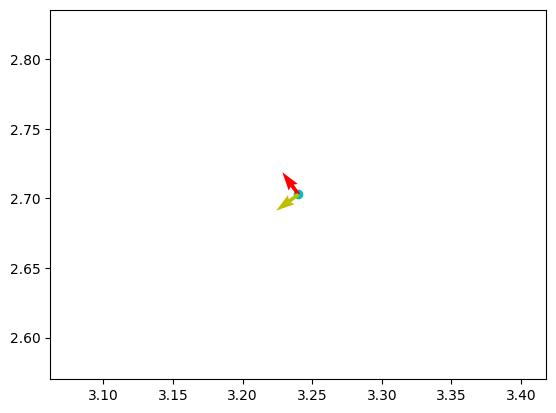

9 10


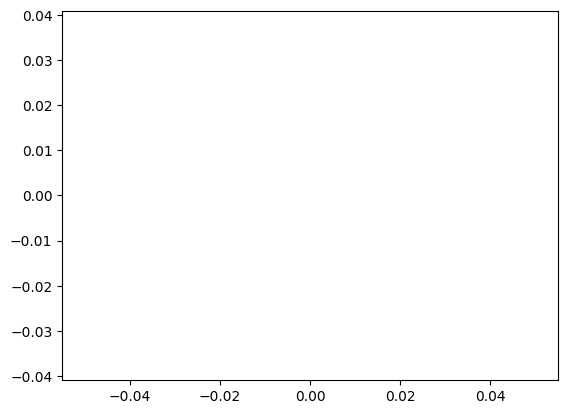

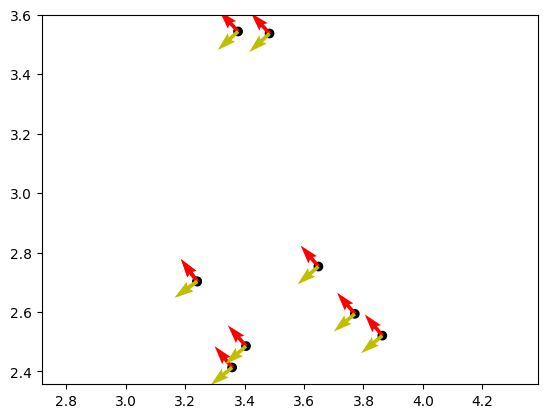

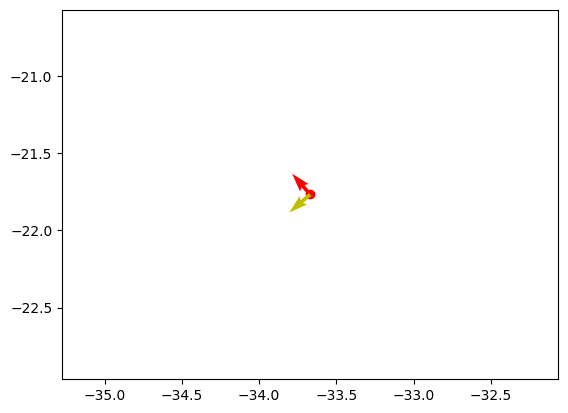

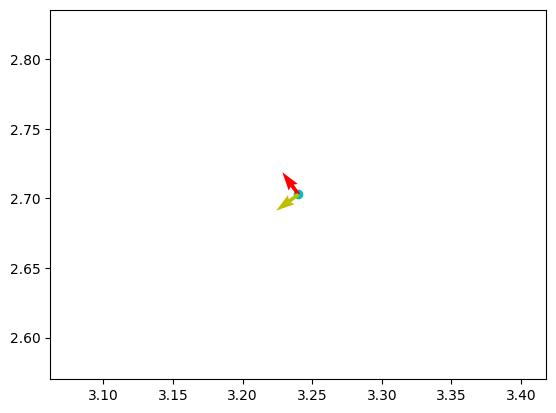

9 10


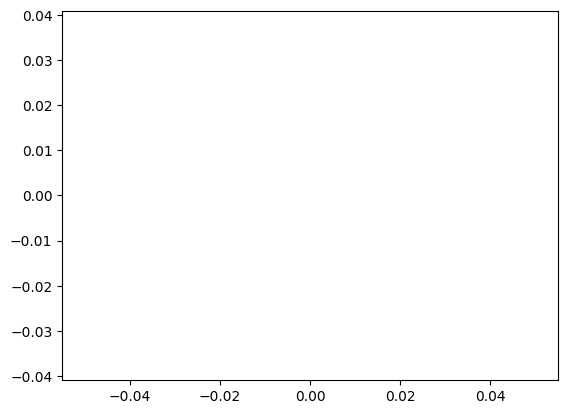

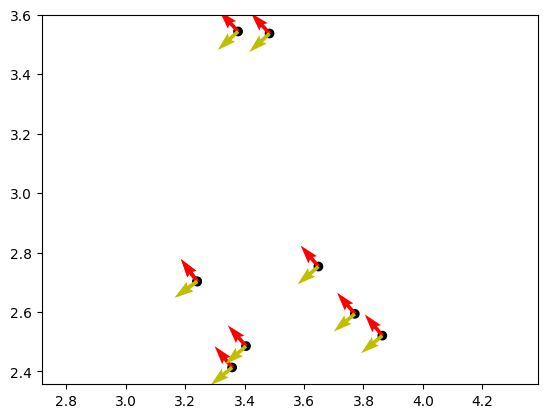

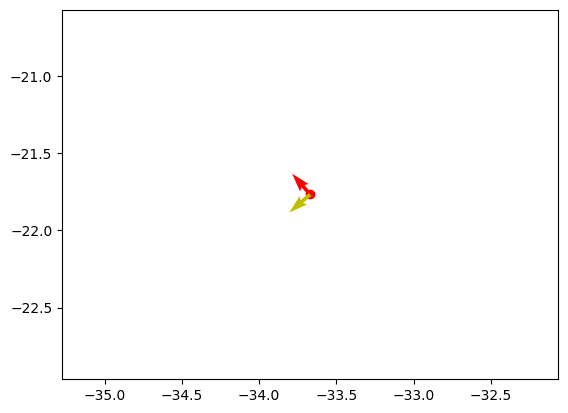

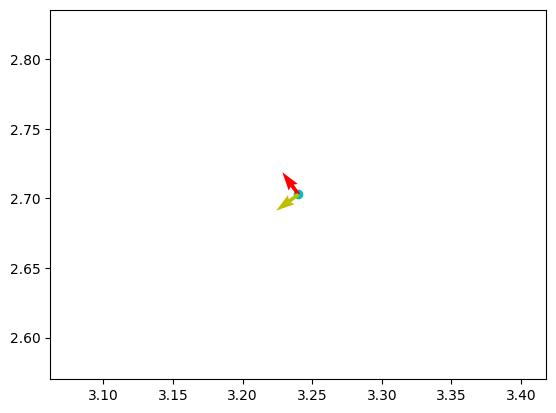

9 10


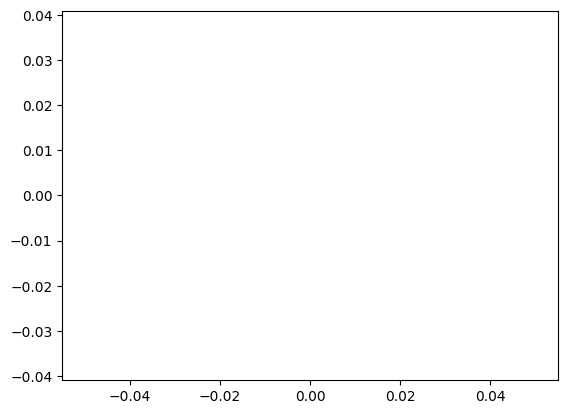

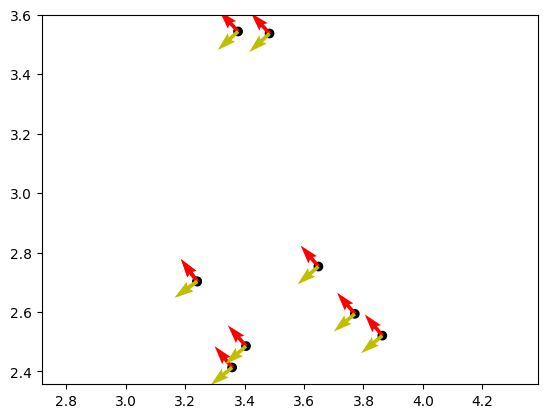

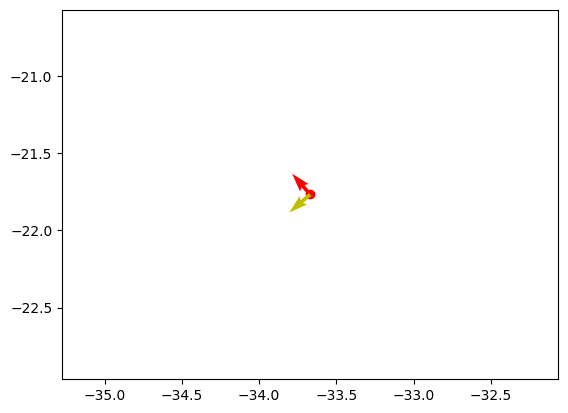

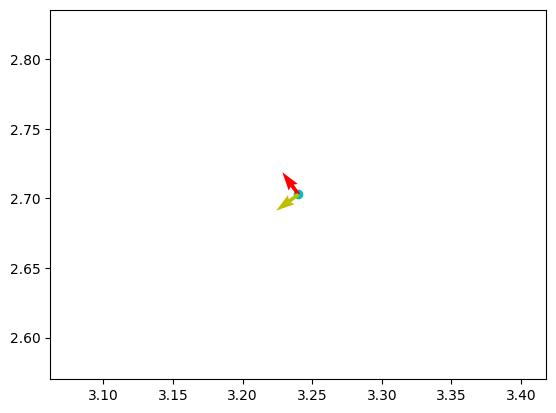

9 10


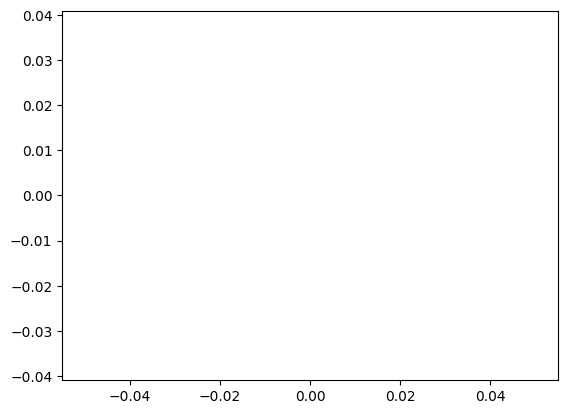

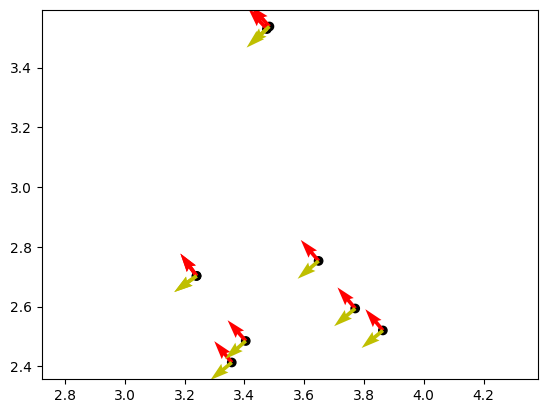

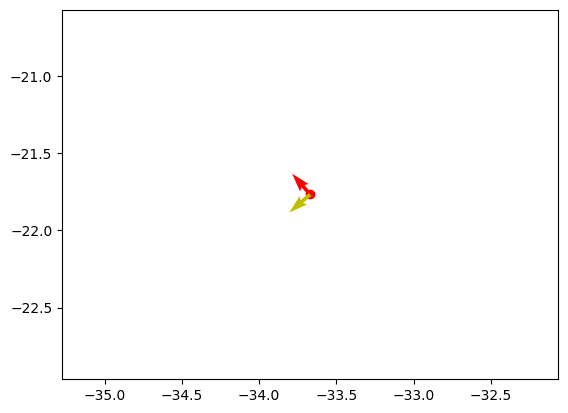

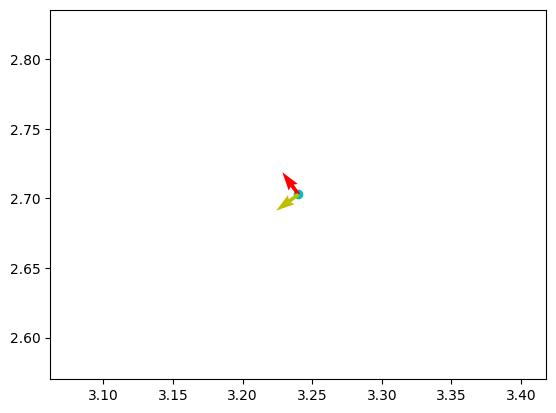

9 10


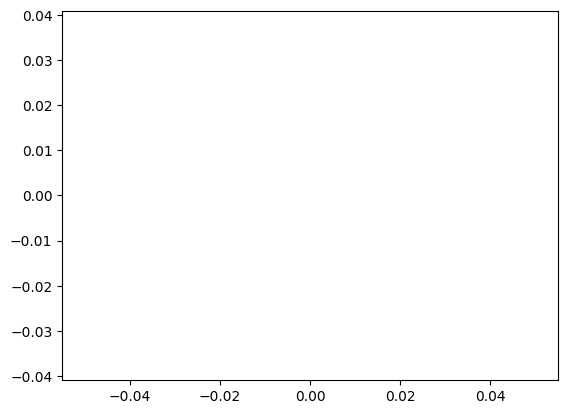

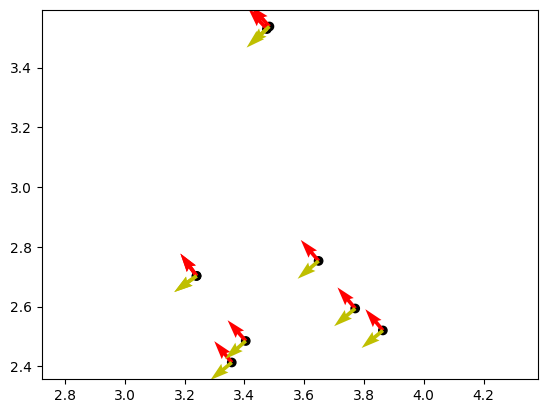

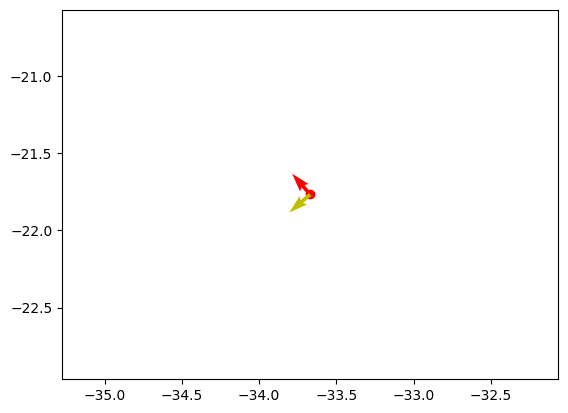

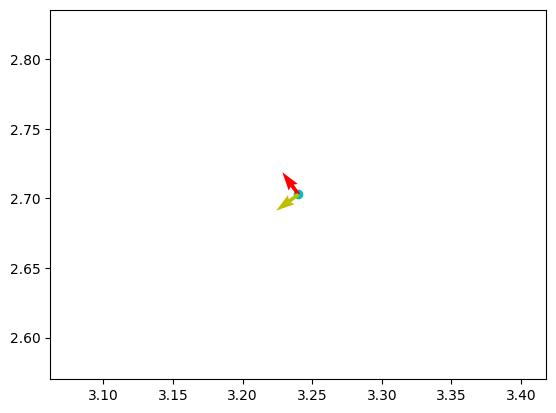

9 10


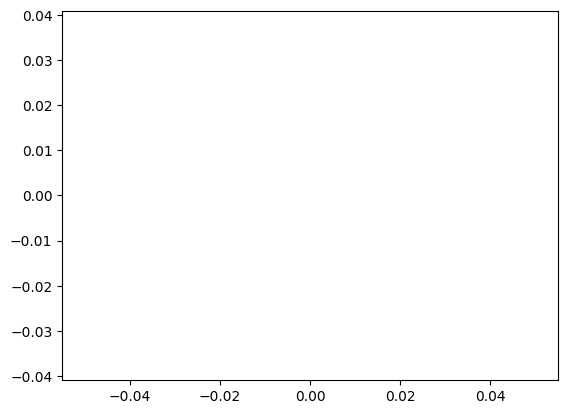

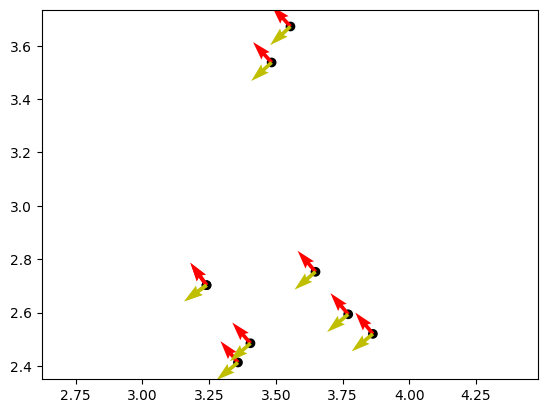

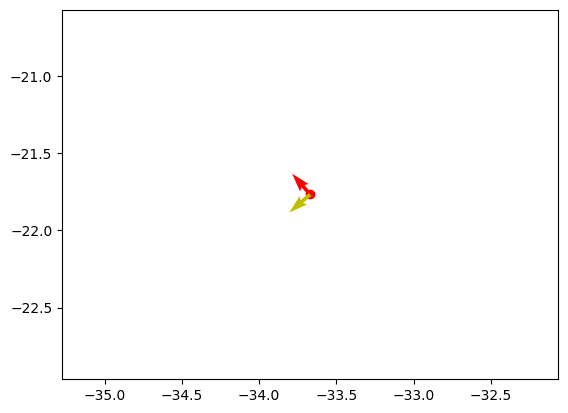

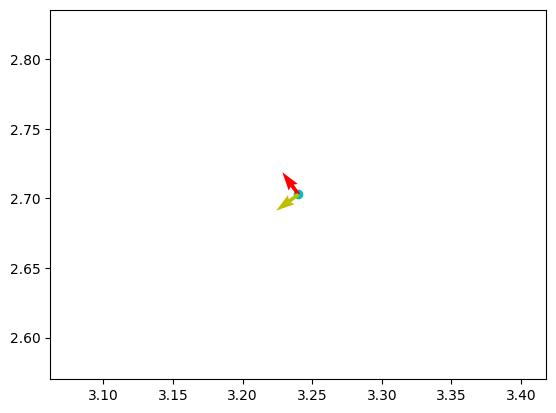

9 10


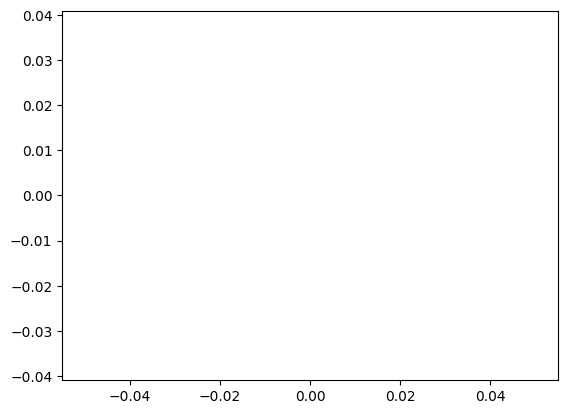

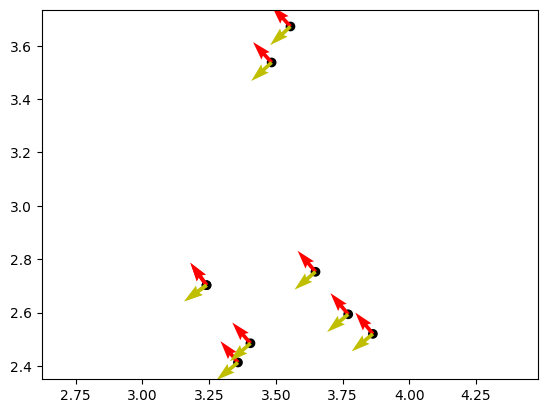

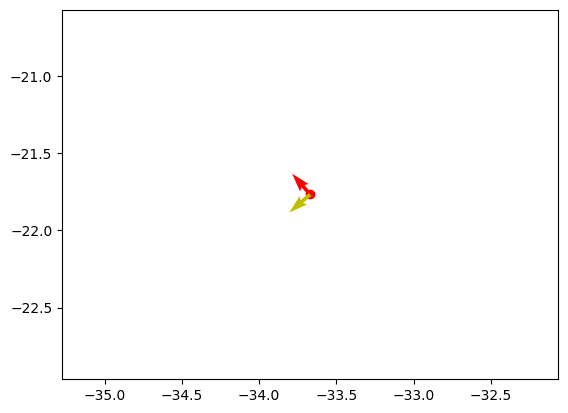

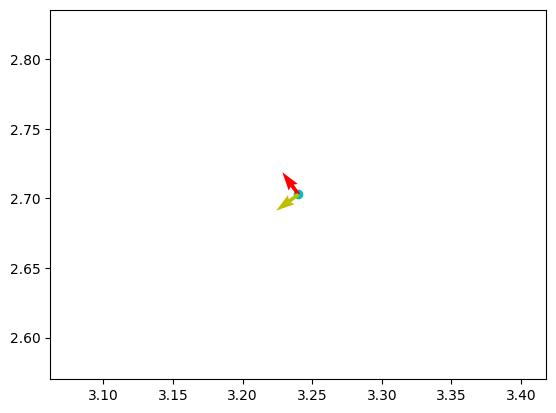

9 10


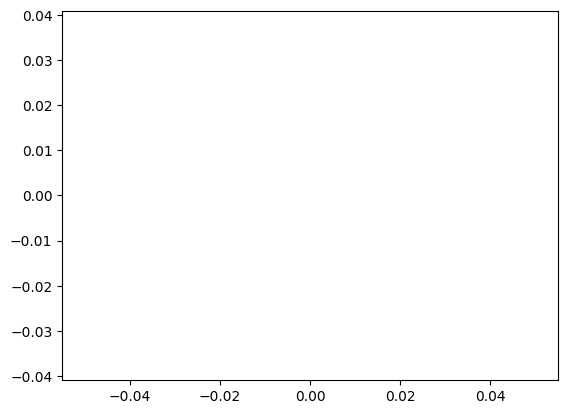

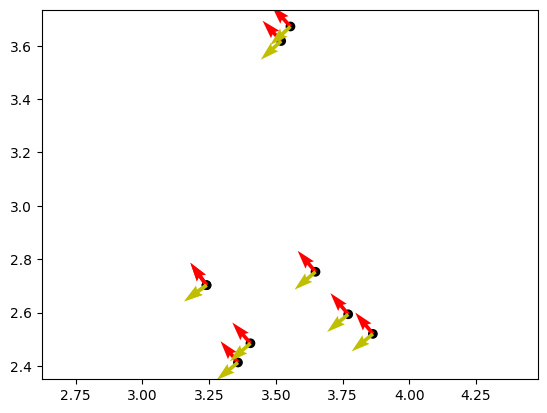

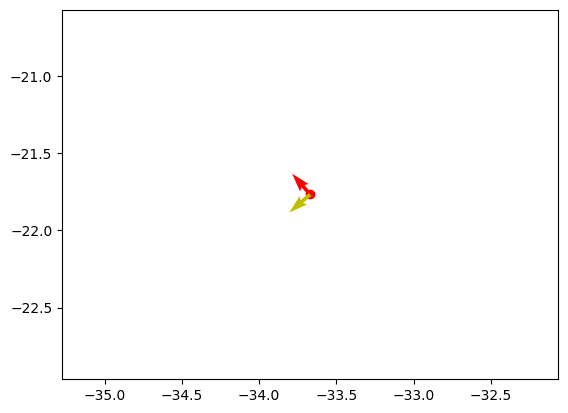

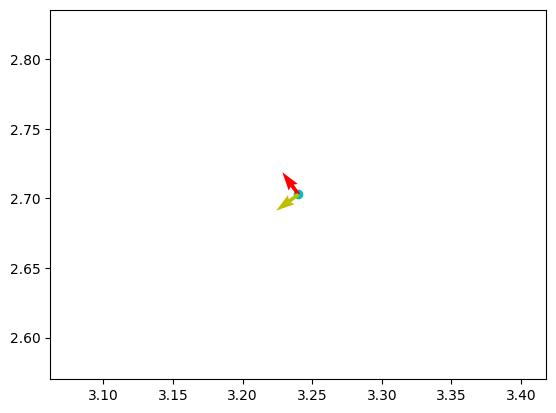

9 10


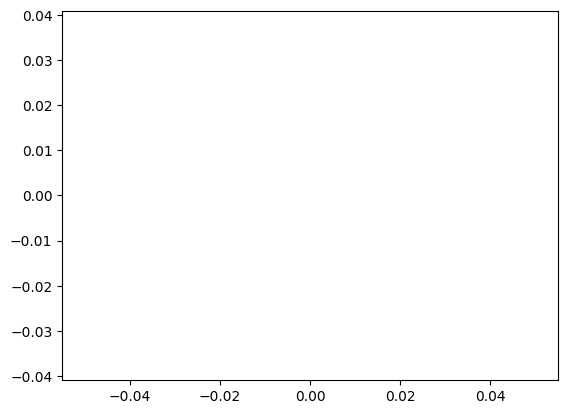

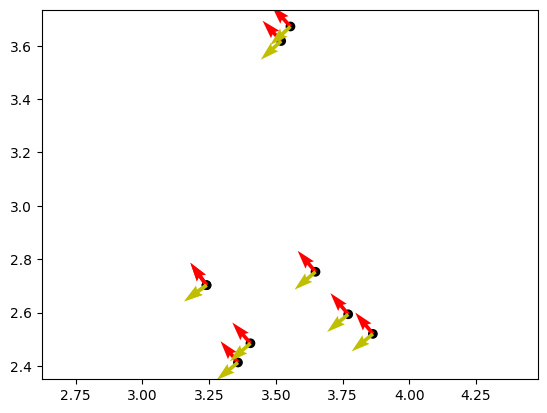

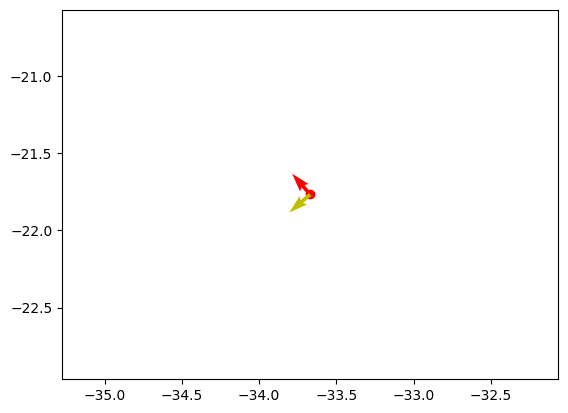

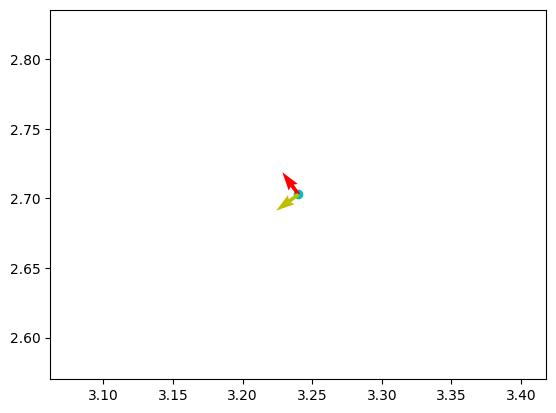

9 10


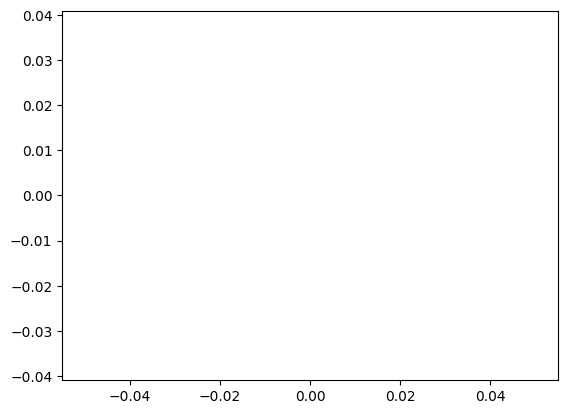

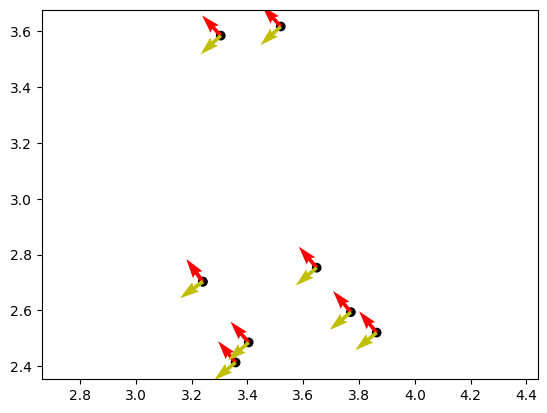

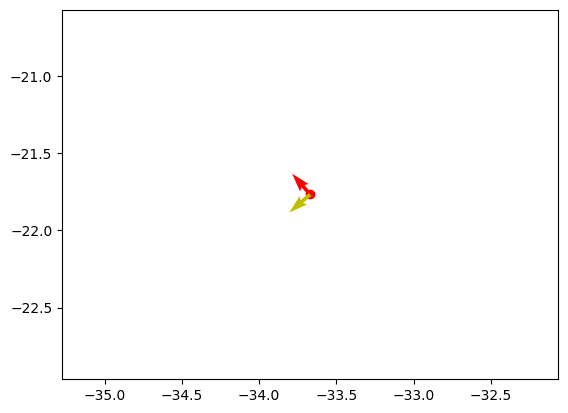

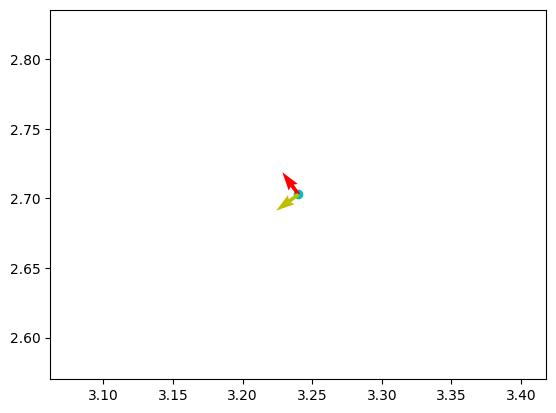

9 10


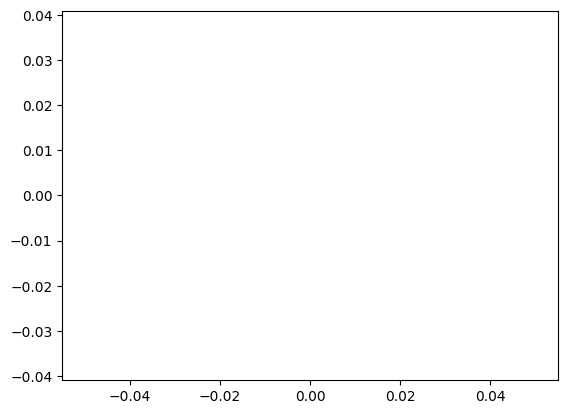

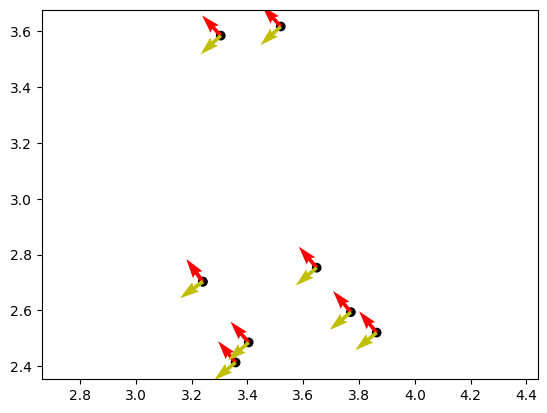

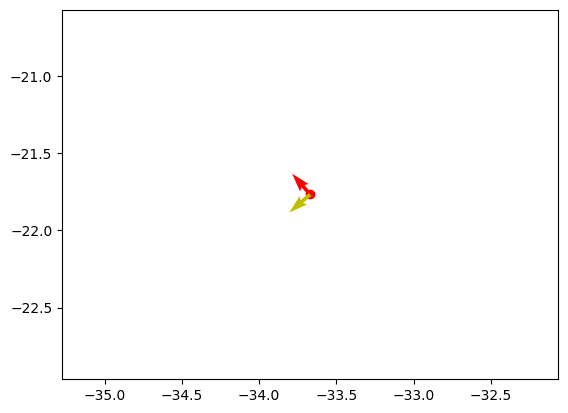

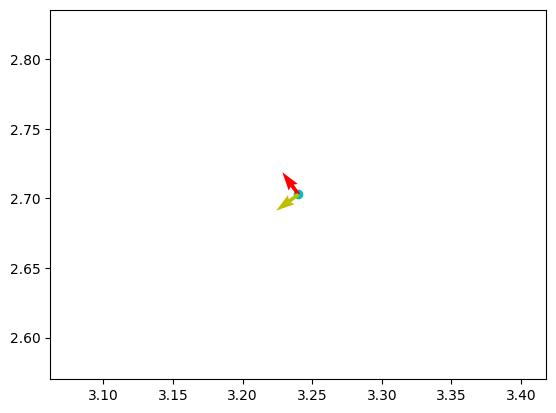

9 10


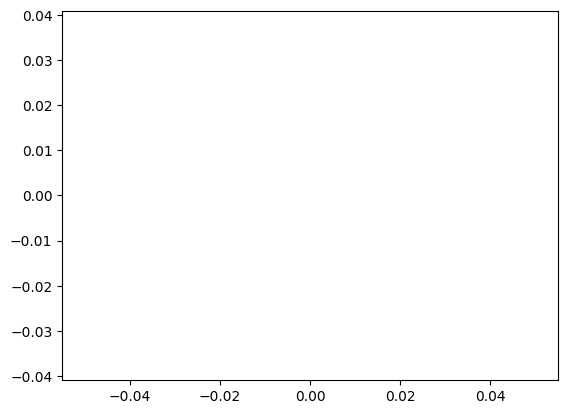

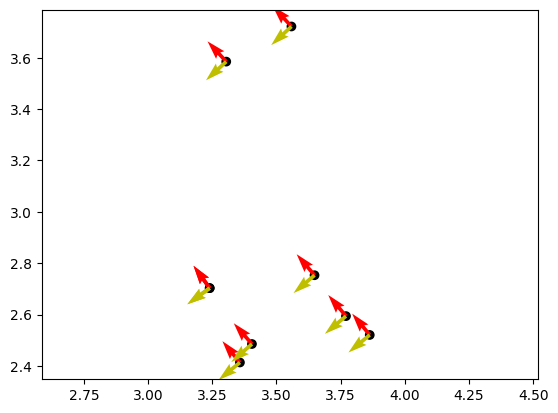

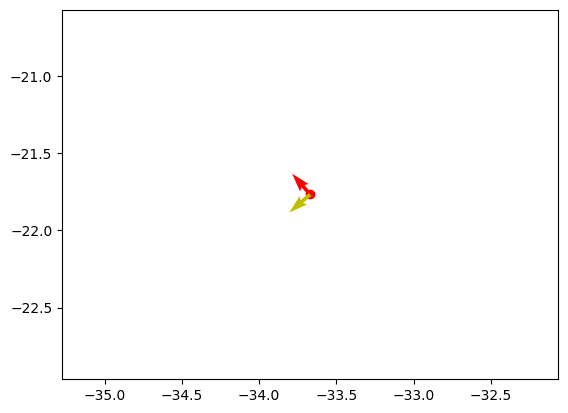

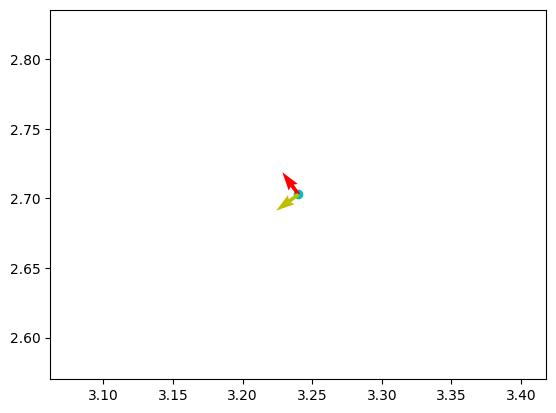

9 10


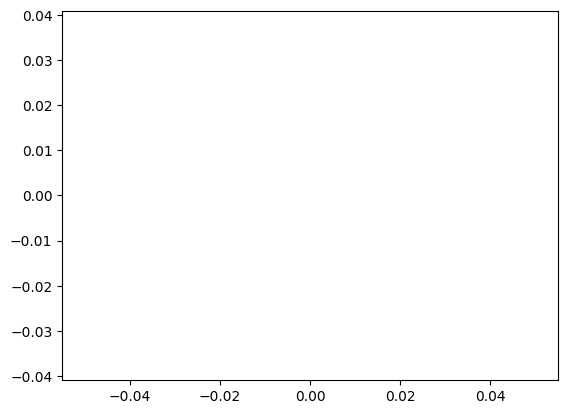

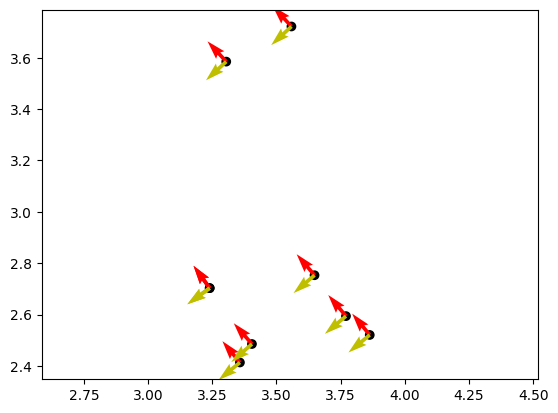

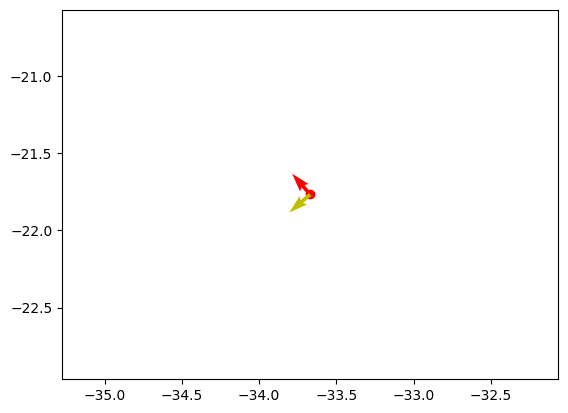

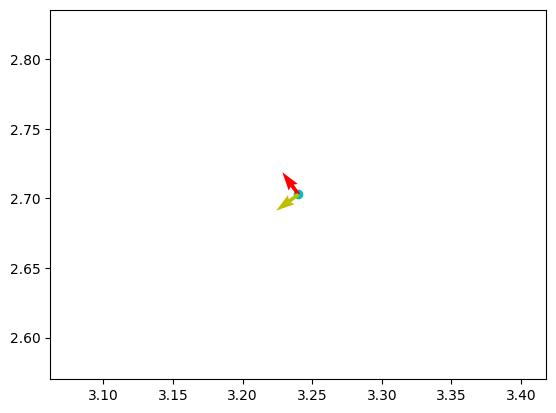

10 10


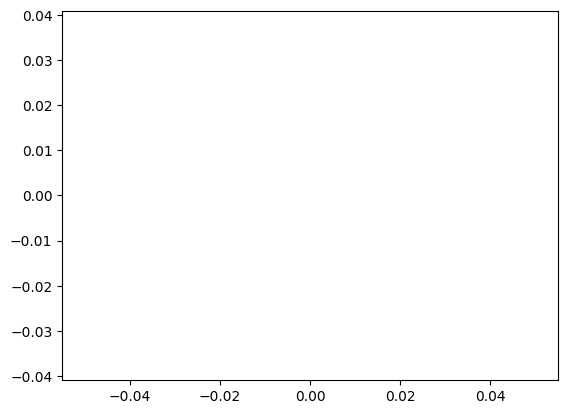

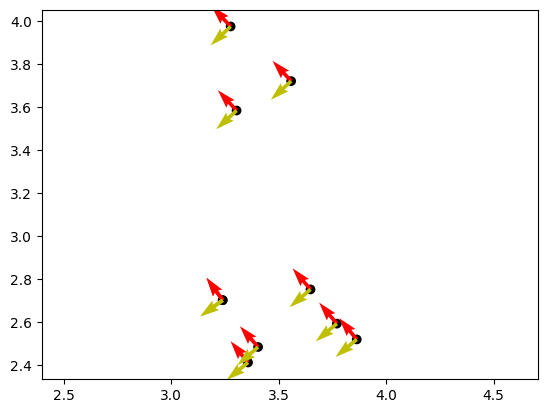

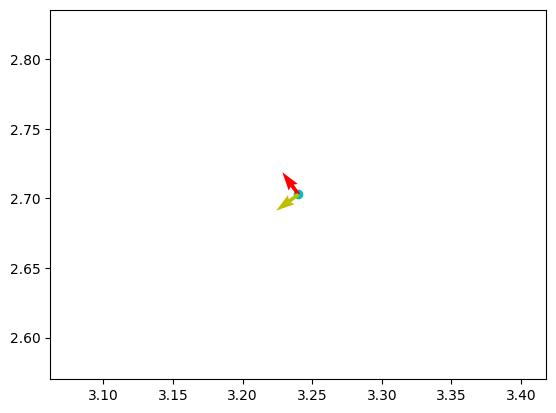

10 10


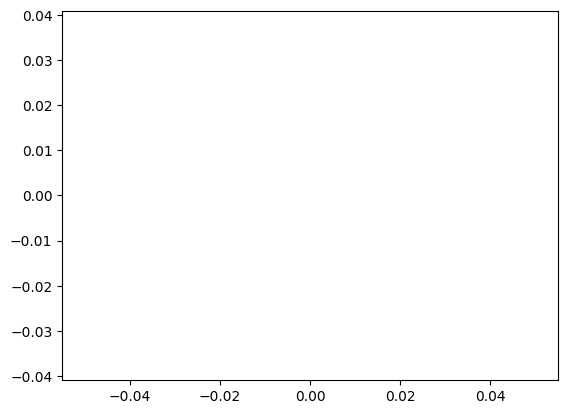

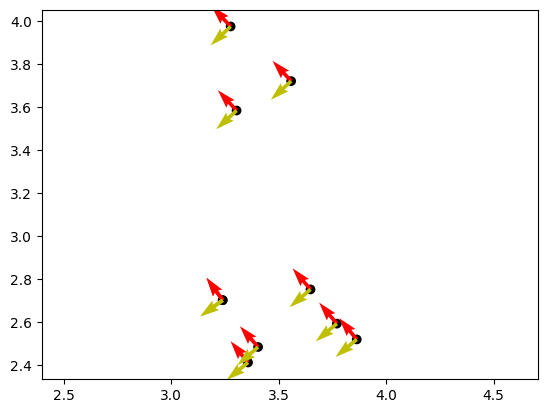

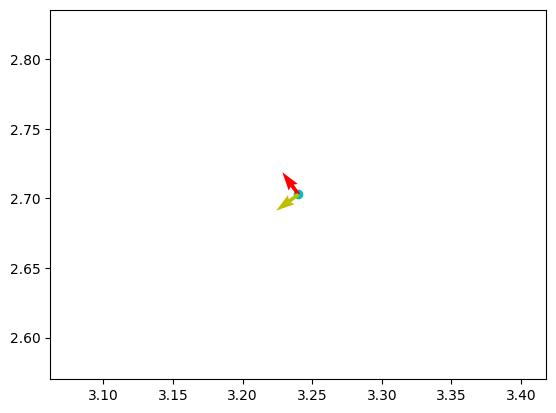

10 10


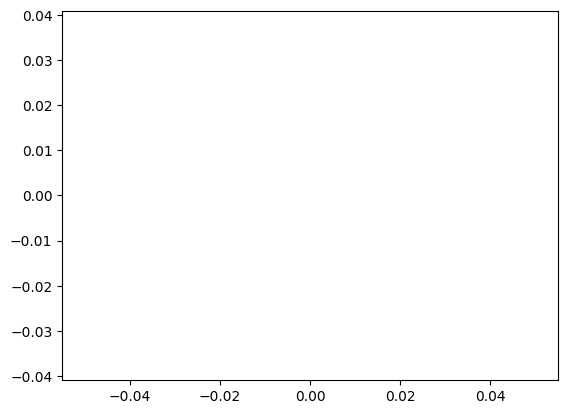

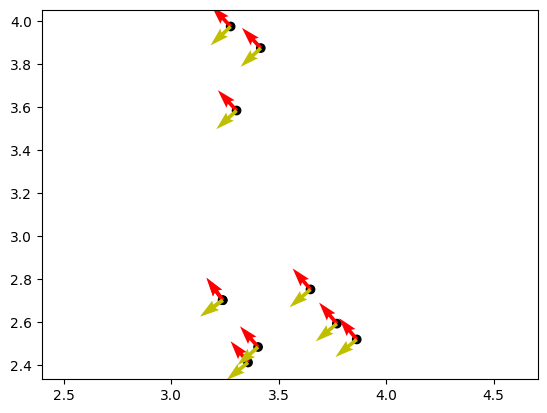

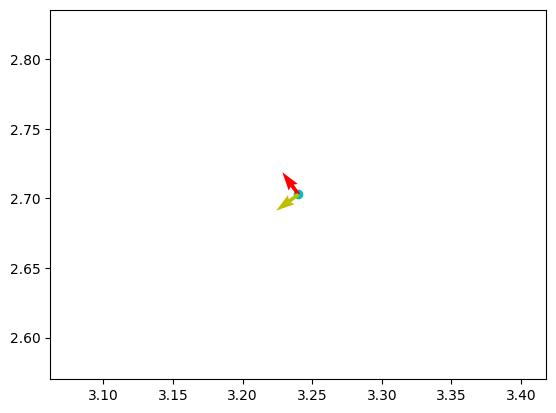

10 10


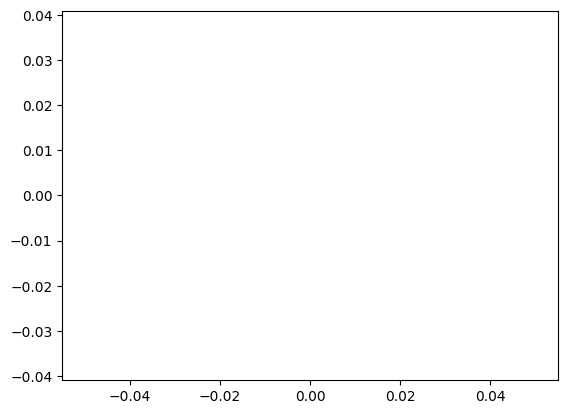

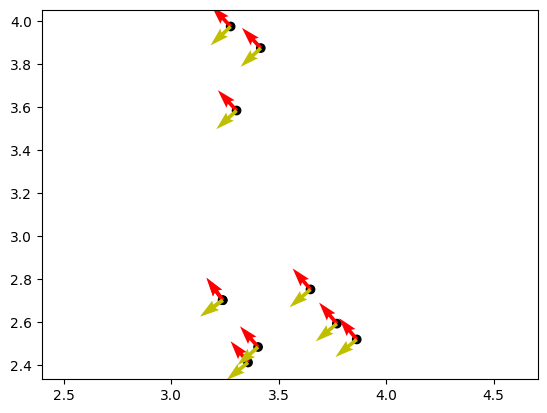

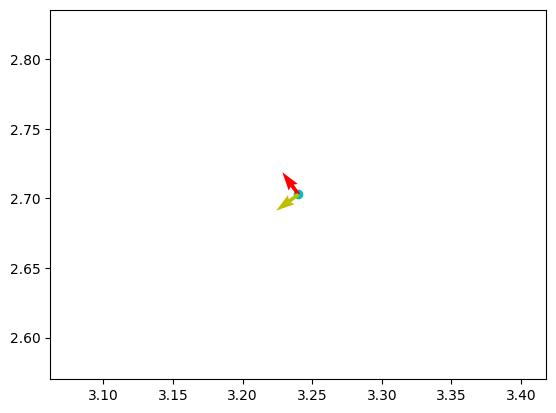

10 10


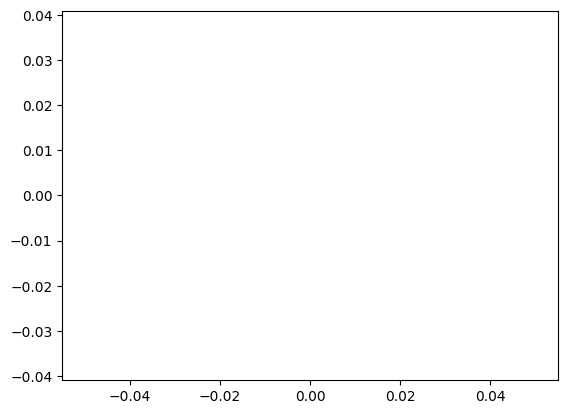

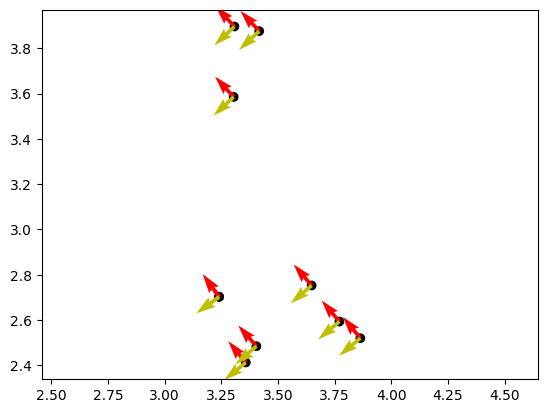

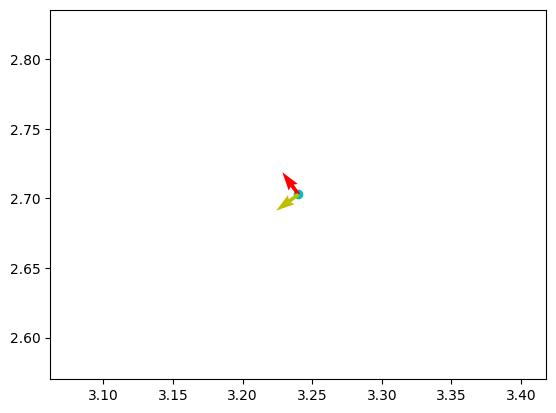

10 10


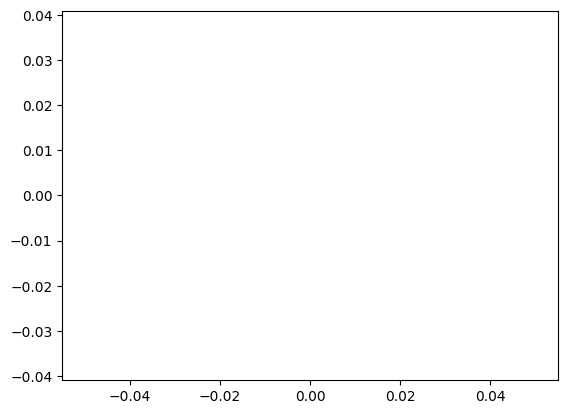

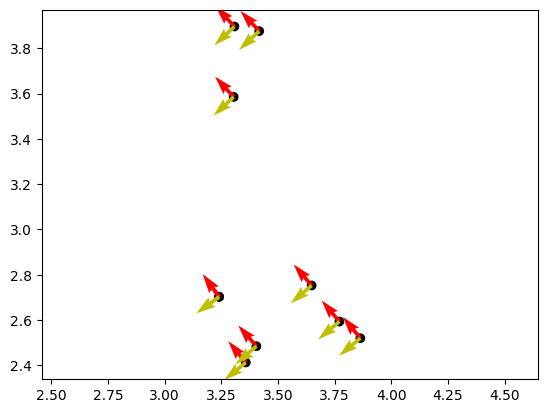

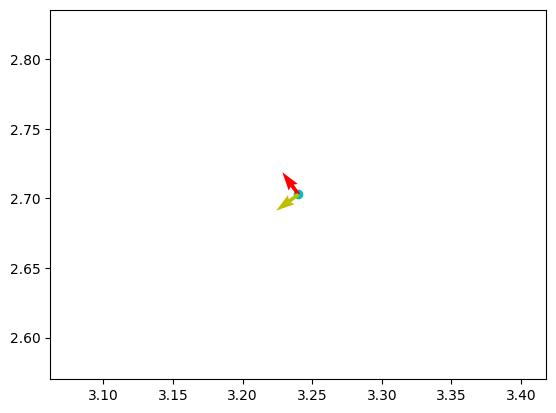

11 11


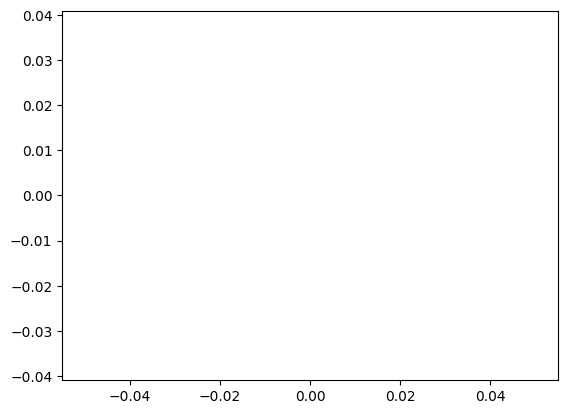

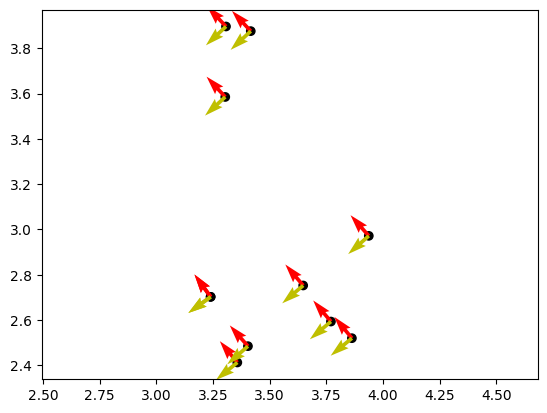

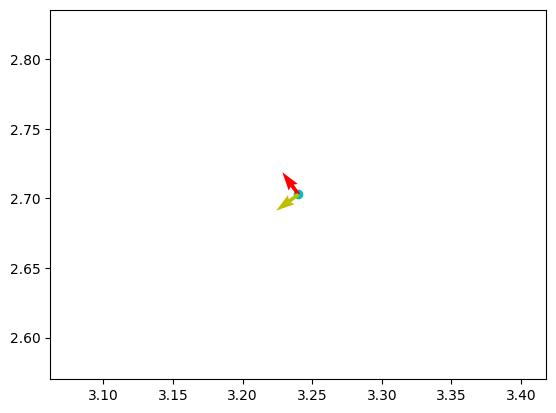

11 11


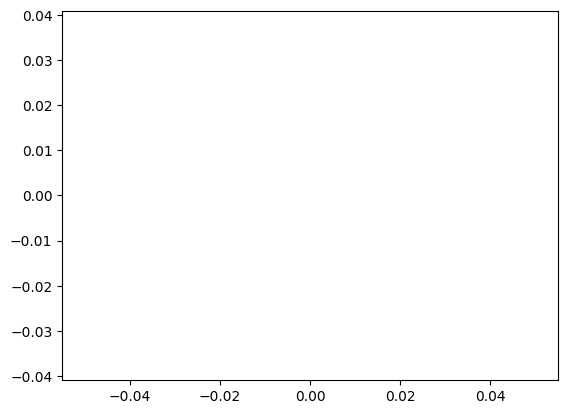

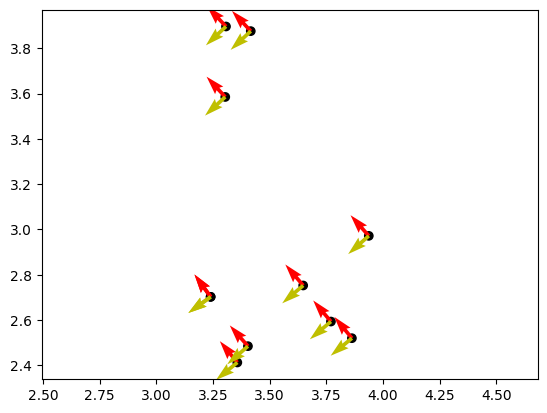

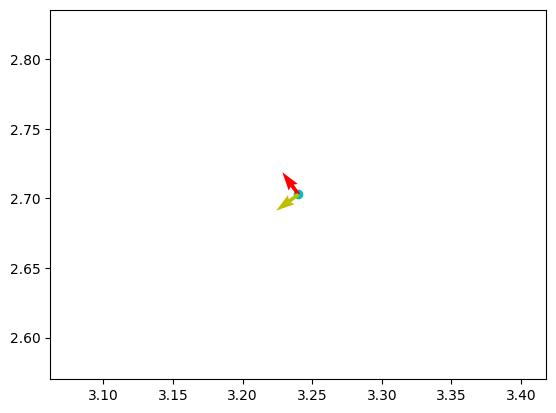

11 11


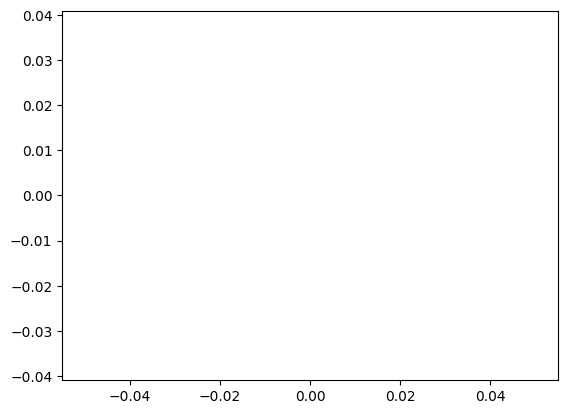

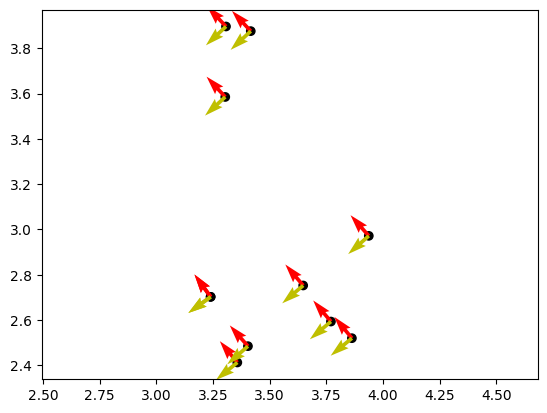

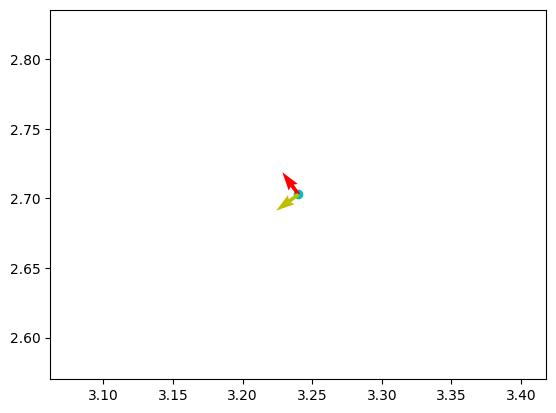

11 11


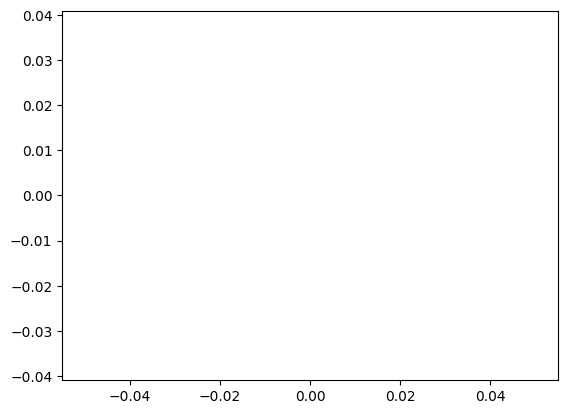

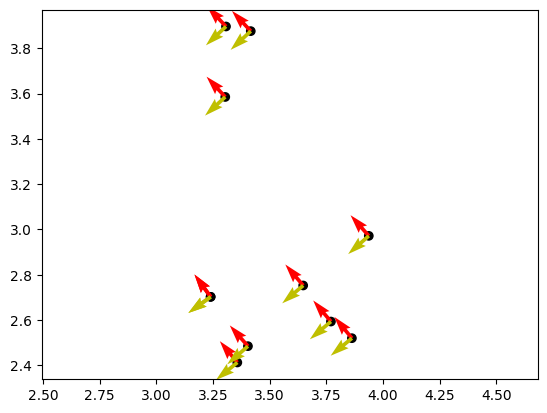

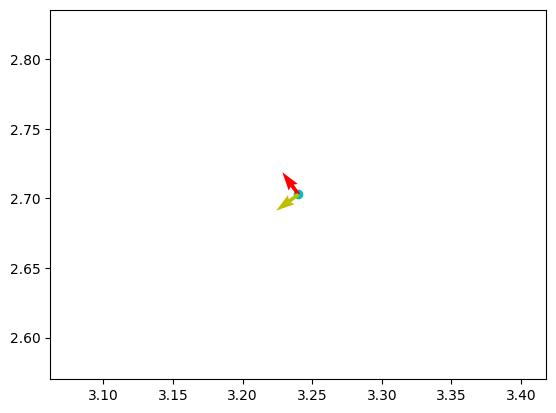

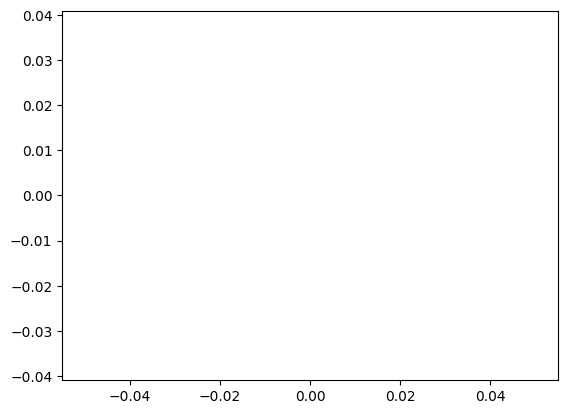

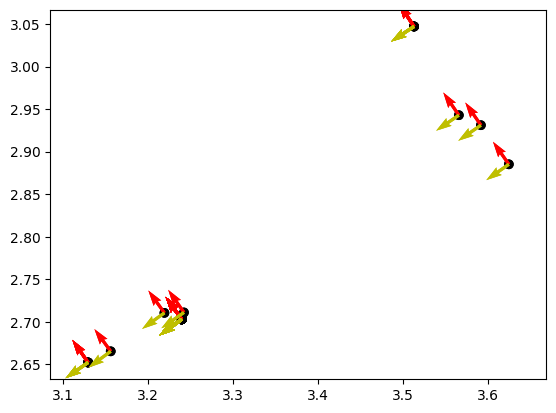

In [7]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_poses_in_ground_plane(poses, colors=None):
    plt.figure()
    ax = plt.axes()
    if colors is None:
        colors = ['k']*poses.shape[0]
    plt.scatter(poses[:,2,3], poses[:,0,3], color=colors)
    ax.axis('equal')
    plt.quiver(poses[:,2,3], poses[:,0,3], poses[:,0,0], poses[:,2,0], color='r')
    plt.quiver(poses[:,2,3], poses[:,0,3], poses[:,0,2], poses[:,2,2], color='y')

def do_filtering(current_alignment, proposed_alignments):
    votes = []
    for (cloudID, proposed_alignment) in proposed_alignments.items():
        other_alignments = [current_alignment] if current_alignment is not None else []
        other_alignments += proposed_alignments.values()
        vote = 0
        inliers = []
        outliers = []
        for other_alignment in other_alignments:
            distance = np.linalg.norm(other_alignment[:,-1] - proposed_alignment[:,-1])
            if distance < 2.0:
                vote += 1
                inliers.append(other_alignment)
            else:
                outliers.append(other_alignment)
        votes.append((vote, proposed_alignment, inliers, outliers))
    
    best = max(votes, key=lambda x: x[0])
    max_votes = len(proposed_alignments) + (1 if current_alignment is not None else 0)
    print(best[0], max_votes)
    fig = plt.figure()
    ax = plt.axes()
    plot_poses_in_ground_plane(np.array(best[2]), ['k']*len(best[2]))
    if len(best[3]) > 0:
        plot_poses_in_ground_plane(np.array(best[3]), ['r']*len(best[3]))
    plot_poses_in_ground_plane(np.expand_dims(np.array(best[1]), axis=0), 'c')
    ax.axis('equal')
    plt.show()
    return best[1]

def do_sequential_processing(file_name):
    with open(file_name) as f:
         d = json.load(f)
    timestamps = np.array(list(map(lambda x: x['timestamp'], d['cloudAnchorResolutions'])))
    proposed_alignments = {}
    consensus_alignments = []
    consensus_alignment = None
    for resolution in d['cloudAnchorResolutions']:
        map_pose = np.array(resolution['mapPose']).reshape((4,4)).swapaxes(0, 1)
        pose = np.array(resolution['pose']).reshape((4,4)).swapaxes(0, 1)
        proposed_alignment = pose @ np.linalg.inv(map_pose)
        proposed_alignments[resolution['cloudID']] = proposed_alignment
        consensus_alignment = do_filtering(consensus_alignment, proposed_alignments)
        consensus_alignments.append(consensus_alignment)
    return np.array(consensus_alignments)

consensus = do_sequential_processing('logs/419_409_27B4CD3E-EC45-4667-94FB-D37E5EC337E2.log')

fig = plt.figure()
ax = plt.axes()
plot_poses_in_ground_plane(consensus)
ax.axis('equal')
plt.show()